In [1]:
# (Conformal Prediction) Computing d values

# Get d values

import ndjson
import pandas as pd
import os
import math
import numpy as np
from numpy import linalg as LA

H = 20
o_len = 20
p_len = 20

priv = []
pred = []
pv = "test_private_"
pd = "test_pred_"

d = "d"
x_cha = "x"
y_cha = "y"
x_l = "x_LSTM"
y_l = "y_LSTM"

d_list = []
x_list = []
y_list = []
x_l_list = []
y_l_list = []

for i in range(p_len):
    priv.append(pv + str(o_len+i))
    pred.append(pd + str(o_len+i) + "/")
    d_list.append(d+str(i+o_len))
    x_list.append(x_cha+str(i+o_len))
    y_list.append(y_cha+str(i+o_len))
    x_l_list.append(x_l+str(i+o_len))
    y_l_list.append(y_l+str(i+o_len))



abs_path_of_notebook = 'C:\\Users\\matth\\Downloads\\Safe Planning in Dynamic Envs with CP\\Safe Planning in Dynamic Envs with CP\\' ##FIXME: change to match your setup


In [2]:

# Modify the pred_lstm and path
from sys import maxunicode

useMaxNorm = True

pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = "/Users/joey/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"
path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"

d_value = {}
x_value = {}
y_value = {}
x_l_value = {}
y_l_value = {}

for q in range(p_len):
    os.chdir(path + str(priv[q]))
    with open('orca_three_synth.ndjson', 'r') as f:
        original_data=ndjson.load(f)    
    os.chdir(path + str(pred[q])+ str(pred_lstm))
    with open('orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)
    
    d_value[d_list[q]] = []
    x_value[x_list[q]] = []
    y_value[y_list[q]] = []
    x_l_value[x_l_list[q]] = []
    y_l_value[y_l_list[q]] = []
    
    number_of_scenes = []
    p_values = []
    s_values = []
    e_values = []
    IDs = []
    # increase if there are more pedestrian
    
    peds = ["Ped 1", "Ped 2", "Ped 3"]
    ID = "ID: "

    for i in range(len(original_data)):
        if list(original_data[i].keys())[0] == 'scene':
            number_of_scenes.append(list(original_data[i].values())[0].get("id"))

    for i in range(len(original_data)):
        if list(original_data[i].keys())[0] == 'track':
            p_values.append(list(original_data[i].values())[0].get("p"))

    p_value = []
    for i in p_values:
        if i not in p_value:
            p_value.append(i)
    
    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            s_values.append(list(predict_data[i].values())[0].get("s"))
            e_values.append(list(predict_data[i].values())[0].get("e"))
        
    for i in range(len(number_of_scenes)):
        IDs.append(number_of_scenes[i])
        IDs[i] = ID + str(IDs[i])

    p_values_for_scene_id = {}
    for i in range(len(s_values)):
        p_values_for_scene_id[IDs[i]] = []
        p = []
        pp = []
        for j in range(len(predict_data)):
            if list(predict_data[j].keys())[0] == 'track':
                if list(predict_data[j].values())[0].get("scene_id") == number_of_scenes[i]:
                    p.append(list(predict_data[j].values())[0].get("p"))
        for k in p:
            if k not in pp:
                pp.append(k)
        p_values_for_scene_id.update({IDs[i] : pp})
    
    x_original_trajectories = {}
    y_original_trajectories = {}

    for i in range(len(s_values)):
        x_original_trajectories[IDs[i]] = {}
        y_original_trajectories[IDs[i]] = {}
        for t in range(3):
            x_original_trajectories[IDs[i]][peds[t]] = []
            y_original_trajectories[IDs[i]][peds[t]] = []   
            x_orig_traj = []
            y_orig_traj = []
            for j in range(len(original_data)):
                if list(original_data[j].keys())[0] == 'track':
                    if list(original_data[j].values())[0].get("p") == p_values_for_scene_id[IDs[i]][t]:
                        for k in range(s_values[i], e_values[i]+1):
                            if list(original_data[j].values())[0].get("f") == k:
                                x_orig_traj.append(list(original_data[j].values())[0].get("x"))
                                y_orig_traj.append(list(original_data[j].values())[0].get("y"))
            x_original_trajectories[IDs[i]].update({peds[t] : x_orig_traj})
            y_original_trajectories[IDs[i]].update({peds[t] : y_orig_traj})

    # Prediction Trajectories
    x_predict_trajectories = {}
    y_predict_trajectories = {}

    for i in range(len(s_values)):
        x_predict_trajectories[IDs[i]] = {}
        y_predict_trajectories[IDs[i]] = {}
        x_pred_traj = []
        y_pred_traj = []
        for j in range(len(predict_data)):
            if list(predict_data[j].keys())[0] == 'track':
                if list(predict_data[j].values())[0].get("scene_id") == number_of_scenes[i]:
                    x_pred_traj.append(list(predict_data[j].values())[0].get("x"))
                    y_pred_traj.append(list(predict_data[j].values())[0].get("y"))
        for t in range(3):
            x_predict_trajectories[IDs[i]][peds[t]] = []
            y_predict_trajectories[IDs[i]][peds[t]] = []
            x_predict_trajectories[IDs[i]].update({peds[t] : x_pred_traj[int(p_len)*t:int(p_len)*(t+1)]})
            y_predict_trajectories[IDs[i]].update({peds[t] : y_pred_traj[int(p_len)*t:int(p_len)*(t+1)]})

    find_th_number_x = []
    find_th_number_y = []

    for i in range(len(IDs)):
        for j in range(len(peds)):
            if not len(x_original_trajectories[IDs[i]][peds[j]]) == (q+int(o_len+p_len)):
                x_original_trajectories[IDs[i]][peds[j]] = [9999] * (q+int(o_len+p_len))
                find_th_number_x.append(np.array([i, j]))

    for i in range(len(IDs)):
        for j in range(len(peds)):
            if not len(y_original_trajectories[IDs[i]][peds[j]]) == (q+int(o_len+p_len)):
                y_original_trajectories[IDs[i]][peds[j]] = [9999] * (q+int(o_len+p_len))
                find_th_number_y.append(np.array([i, j]))
              
    for i in range(len(find_th_number_x)):
        x_predict_trajectories[IDs[find_th_number_x[i][0]]][peds[find_th_number_x[i][1]]] = [0] * 20

    for i in range(len(find_th_number_y)):
        y_predict_trajectories[IDs[find_th_number_y[i][0]]][peds[find_th_number_y[i][1]]] = [0] * 20

    R_value_x = {}
    R_value_y = {}
    R_value = {}

    list_R_value_x = []
    list_R_value_y = []
    list_R_value = []
    for i in range(len(IDs)):
        R_value_x[IDs[i]] = {}
        R_value_y[IDs[i]] = {}
        R_value[IDs[i]] = {}
        for j in range(len(peds)):
            R_value_x[IDs[i]][peds[j]] = [] 
            R_value_y[IDs[i]][peds[j]] = []
            R_value[IDs[i]][peds[j]] = []
            list_R_value_x = []
            list_R_value_y = []
            list_R_value = []
            for k in range(p_len):
                list_R_value_x.append(x_original_trajectories[IDs[i]][peds[j]][k+q+p_len] - x_predict_trajectories[IDs[i]][peds[j]][k])
                list_R_value_y.append(y_original_trajectories[IDs[i]][peds[j]][k+q+p_len] - y_predict_trajectories[IDs[i]][peds[j]][k])
                list_R_value.append(round(LA.norm([list_R_value_x[k], list_R_value_y[k]], 2), 4))
            R_value_x[IDs[i]].update({peds[j] : list_R_value_x})
            R_value_y[IDs[i]].update({peds[j] : list_R_value_y})
            R_value[IDs[i]].update({peds[j] : list_R_value})

    print("find_th_number_x length: " + str(len(find_th_number_x)))
    print("find_th_number_y length: " + str(len(find_th_number_y)))
    
    if not useMaxNorm:
        N = len(IDs) * len(peds) - len(find_th_number_x)
    else:
        N = len(IDs) - len(find_th_number_x)

    th_values = math.ceil((1+N)*(1-(0.05/H)))
    d_value_for_alpha_0_05 = []
    R = []
    numb_N = []
    numb_R = "R"

    for i in range(1,p_len+1):
        R.append(i)
        R[i-1] = numb_R + str(i)

    R_values = {}
    list_R_values = []

    for i in range(len(R)):
        R_values[R[i]] = []
        list_R_values = []

        if not useMaxNorm:
            for j in range(len(IDs)):
                for k in range(len(peds)):
                    list_R_values.append(R_value[IDs[j]][peds[k]][i])
        else:
            for j in range(len(IDs)):
                max_R = 0
                for k in range(len(peds)):
                    max_R = max(max_R, R_value[IDs[j]][peds[k]][i])
                list_R_values.append(max_R)
        list_R_values.sort()
        R_values.update({R[i]: list_R_values})
        d_value_for_alpha_0_05.append(R_values[R[i]][int(th_values)-1])
    
    d_value.update({d_list[q]: d_value_for_alpha_0_05})
    x_value.update({x_list[q]: x_original_trajectories})
    y_value.update({y_list[q]: y_original_trajectories})
    x_l_value.update({x_l_list[q]: x_predict_trajectories})
    y_l_value.update({y_l_list[q]: y_predict_trajectories})
    
    print(q)

import pickle

save_path = "/data2/mcleav/conformalRNNs/icra_2022/code/aaa/maxNorm/"
fid = open(save_path + "d_value.pkl", 'wb')
pickle.dump(d_value, fid)
fid.close()

fid = open(save_path + "x_value.pkl", 'wb')
pickle.dump(x_value, fid)
fid.close()

fid = open(save_path + "y_value.pkl", 'wb')
pickle.dump(y_value, fid)
fid.close()

fid = open(save_path + "x_l_value.pkl", 'wb')
pickle.dump(x_l_value, fid)
fid.close()

fid = open(save_path + "y_l_value.pkl", 'wb')
pickle.dump(y_l_value, fid)
fid.close()


FileNotFoundError: [Errno 2] No such file or directory: '/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/test_private_20'

In [2]:
import pickle

# save_path = abs_path_of_notebook + "maxNorm/"
save_path = "/home/hardik/Desktop/Research/social-navigation/conformal_prediction/maxNorm/"

fid = open(save_path + "d_value.pkl", 'rb')
d_value= pickle.load(fid)
fid.close()

fid = open(save_path + "x_value.pkl", 'rb')
x_value = pickle.load(fid)
fid.close()


fid = open(save_path + "y_value.pkl", 'rb')
y_value = pickle.load(fid)
fid.close()



fid = open(save_path + "x_l_value.pkl", 'rb')
x_l_value = pickle.load(fid)
fid.close()

fid = open(save_path + "y_l_value.pkl", 'rb')
y_l_value = pickle.load(fid)
fid.close()



FileNotFoundError: [Errno 2] No such file or directory: '/home/hardik/Desktop/Research/social-navigation/conformal_prediction/maxNorm/d_value.pkl'

In [33]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = 'allOrcaData/'
path = '/home/hardik/Desktop/Research/social-navigation/conformal_prediction/allOrcaData/'

# (Conformal Prediction) Find an ID, Ped Numbers

# Pedestrian 1
Spec_ID_1 = []

# Modify numbers
x_H10_1 = []
y_H10_1 = []
d_20_1 = []

with open(path + pred[0] + pred_lstm + 'orca_three_synth.ndjson', 'r') as f:
    predict_data=ndjson.load(f)


s_point = 104533
p_point = 3617
Spec_ID_1.append(1997)

x_H10_1.append(x_l_value[x_l_list[0]]['ID: '+str(Spec_ID_1[0])]['Ped 1'])
y_H10_1.append(y_l_value[y_l_list[0]]['ID: '+str(Spec_ID_1[0])]['Ped 1'])
d_20_1.append(d_value[d_list[0]])

for q in range(1, p_len):
    with open(path + pred[q] + pred_lstm + 'orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)
    
    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            if list(predict_data[i].values())[0].get("s") == s_point:
                if list(predict_data[i].values())[0].get("p") == p_point:
                    Spec_ID_1.append(predict_data[i]['scene']['id'])
    
    x_H10_1.append(x_l_value[x_l_list[q]]['ID: '+str(Spec_ID_1[q])]['Ped 1'])
    y_H10_1.append(y_l_value[y_l_list[q]]['ID: '+str(Spec_ID_1[q])]['Ped 1'])
    d_20_1.append(d_value[d_list[q]])
    
original_x_1 = x_value[x_list[0]]['ID: '+str(1997)]['Ped 1']
original_y_1 = y_value[y_list[0]]['ID: '+str(1997)]['Ped 1']

# %cd /Users/joey

In [36]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
path = '/home/hardik/Desktop/Research/social-navigation/conformal_prediction/allOrcaData/'


# (Conformal Prediction) Find an ID, Ped Numbers

# Pedestrian 2
Spec_ID_2 = []

# Modify numbers
x_H10_2 = []
y_H10_2 = []
d_20_2 = []

with open(path + pred[0] + pred_lstm + 'orca_three_synth.ndjson', 'r') as f:
    predict_data=ndjson.load(f)

s_point = 104162
p_point = 3605
Spec_ID_2.append(1994)

x_H10_2.append(x_l_value[x_l_list[0]]['ID: '+str(Spec_ID_2[0])]['Ped 1'])
y_H10_2.append(y_l_value[y_l_list[0]]['ID: '+str(Spec_ID_2[0])]['Ped 1'])
d_20_2.append(d_value[d_list[0]])

for q in range(1, p_len):
    with open(path + pred[q] + pred_lstm + 'orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)
    
    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            if list(predict_data[i].values())[0].get("s") == s_point:
                if list(predict_data[i].values())[0].get("p") == p_point:
                    Spec_ID_2.append(predict_data[i]['scene']['id'])
    
    x_H10_2.append(x_l_value[x_l_list[q]]['ID: '+str(Spec_ID_2[q])]['Ped 1'])
    y_H10_2.append(y_l_value[y_l_list[q]]['ID: '+str(Spec_ID_2[q])]['Ped 1'])
    d_20_2.append(d_value[d_list[q]])
    
original_x_2 = x_value[x_list[0]]['ID: '+str(1994)]['Ped 1']
original_y_2 = y_value[y_list[0]]['ID: '+str(1994)]['Ped 1']

# %cd /Users/joey

In [37]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = 'allOrcaData/'
path = '/home/hardik/Desktop/Research/social-navigation/conformal_prediction/allOrcaData/'


# (Conformal Prediction) Find an ID, Ped Numbers

# Pedestrian 3
Spec_ID_3 = []

# Modify numbers
x_H10_3 = []
y_H10_3 = []
d_20_3 = []

# os.chdir(path + str(pred[0])+ str(pred_lstm))
with open(path + pred[0] + pred_lstm + 'orca_three_synth.ndjson', 'r') as f:
    predict_data=ndjson.load(f)

s_point = 111117
p_point = 3850
Spec_ID_3.append(2125)

x_H10_3.append(x_l_value[x_l_list[0]]['ID: '+str(Spec_ID_3[0])]['Ped 1'])
y_H10_3.append(y_l_value[y_l_list[0]]['ID: '+str(Spec_ID_3[0])]['Ped 1'])
d_20_3.append(d_value[d_list[0]])

for q in range(1, p_len):
    # os.chdir(path + str(pred[q])+ str(pred_lstm))
    # with open('orca_three_synth.ndjson', 'r') as f:
    #     predict_data=ndjson.load(f)
    with open(path + pred[q] + pred_lstm + 'orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)

    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            if list(predict_data[i].values())[0].get("s") == s_point:
                if list(predict_data[i].values())[0].get("p") == p_point:
                    Spec_ID_3.append(predict_data[i]['scene']['id'])
    
    x_H10_3.append(x_l_value[x_l_list[q]]['ID: '+str(Spec_ID_3[q])]['Ped 1'])
    y_H10_3.append(y_l_value[y_l_list[q]]['ID: '+str(Spec_ID_3[q])]['Ped 1'])
    d_20_3.append(d_value[d_list[q]])
    
original_x_3 = x_value[x_list[0]]['ID: '+str(2125)]['Ped 1']
original_y_3 = y_value[y_list[0]]['ID: '+str(2125)]['Ped 1']

# %cd /Users/joey

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      289
Number of nonzeros in inequality constraint Jacobian.:       59
Number of nonzeros in Lagrangian Hessian.............:      157

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality constraints...............:       39
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:       19
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 1.38e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

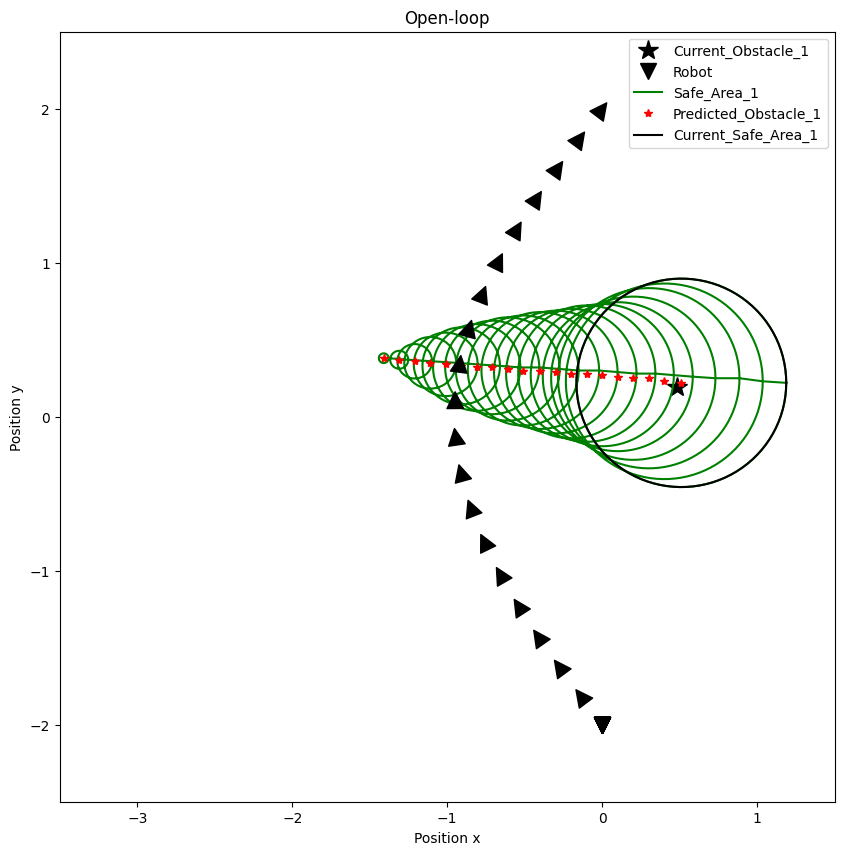

In [39]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# Open-loop MPC

# One Pedestrian with Dynamic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *

opti = casadi.Opti()

predict_x1 = x_H10_1[0]
predict_y1 = y_H10_1[0]
d20_value_H20_1 = d_20_1[0]

eps = 0.2

T = 20

Delta = 1/10
L = 1

predict_x1 = original_x_1[0:T] + predict_x1
predict_y1 = original_y_1[0:T] + predict_y1

x_state = [0]*(T-1)
y_state = [-2]*(T-1)

xref = 0
yref = 2

x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)

uv = opti.variable(T)
delta = opti.variable(T)

opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 1)
opti.set_initial(theta[0], pi)

p_opts = {"expand":True}
s_opts = {"max_iter": 3000}
opti.solver('ipopt', p_opts, s_opts)

obj = 0
for i in range(1, T):
    #opti.subject_to(opti.bounded(-3, V[i], 3))
    opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
    #opti.subject_to(opti.bounded(-3, uv[i], 3))
    opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
    opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
    opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
    opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
    
for i in range(T):
    obj += delta[i-1]**2 + uv[i-1]**2
    opti.minimize(obj)
    opti.subject_to(sqrt((x[i]-predict_x1[i+T])**2+(y[i]-predict_y1[i+T])**2) >= d20_value_H20_1[i]+eps)
    
opti.subject_to(x[0]-x_state[0] == 0)
opti.subject_to(y[0]-y_state[0] == 0)
opti.subject_to(x[T-1]-xref == 0)
opti.subject_to(y[T-1]-yref == 0)

sol = opti.solve()

x_state = x_state + list(sol.value(x)) + [list(sol.value(x))[T-1]]
y_state = y_state + list(sol.value(y)) + [list(sol.value(y))[T-1]]

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-3.5, 1.5),
            ylim =(-2.5, 2.5))
ts = np.linspace(0,2*pi,100)

p1_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)
c1_line, = axis.plot([], [], '-', color = 'g')
af1_line, = axis.plot([], [], '*', color = 'r')
ch1_line, = axis.plot([], [], color = 'k')

arrow = axis.annotate("", xy=(2, 2), xytext=(0, 0), arrowprops={"facecolor": "black"})

x_robot, y_robot = [], []
x_pred1, y_pred1 = [], []
x1_circle, y1_circle = [], []
x_af1, y_af1 = [], []

def init(): 
    p1_line.set_data([], [])
    r_line.set_data([], [])
    c1_line.set_data([], [])
    af1_line.set_data([], [])
    ch1_line.set_data([], [])
    return p1_line, r_line, c1_line, af1_line, ch1_line,

def animate(i):
    global arrow
    if i <= 19:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= 20:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred1, y_pred1 = [], []
    x_p1 = original_x_1[i]
    y_p1 = original_y_1[i]
    x_pred1.append(x_p1)
    y_pred1.append(y_p1)
    p1_line.set_data(x_pred1, y_pred1)
    
    x_af1, y_af1 = [], []
    if i >= T:
        x_a1 = predict_x1[T:T+T]
        y_a1 = predict_y1[T:T+T]
        x_af1 = x_af1 + x_a1
        y_af1 = y_af1 + y_a1
        af1_line.set_data(x_af1, y_af1)
        
    x1_circle, y1_circle = [], []
    if i >= T:
        for j in range(T):
            c_x1 = d20_value_H20_1[j] * np.cos(ts) + predict_x1[T+j]
            c_y1 = d20_value_H20_1[j] * np.sin(ts) + predict_y1[T+j]
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            c1_line.set_data(x1_circle, y1_circle)
    
    xh1_circle, yh1_circle = [], []

    if i >= T:
        ch_x1 = d20_value_H20_1[i-T] * np.cos(ts) + predict_x1[i]
        ch_y1 = d20_value_H20_1[i-T] * np.sin(ts) + predict_y1[i]
        xh1_circle.append(ch_x1)
        yh1_circle.append(ch_y1)
        ch1_line.set_data(xh1_circle, yh1_circle)
    return p1_line, r_line, c1_line, af1_line, ch1_line, arrow

plt.legend(['Current_Obstacle_1', 'Robot', 'Safe_Area_1', 
            'Predicted_Obstacle_1', 'Current_Safe_Area_1'], fontsize = 10)

plt.xlabel('Position x')
plt.ylabel('Position y')
plt.title("Open-loop")

anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
gif_writer = ImageMagickWriter(fps=2)
anim.save('/home/hardik/Desktop/Research/social-navigation/conformal_prediction/open_mpc_dynamic_one_Ped.gif', writer=gif_writer)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      289
Number of nonzeros in inequality constraint Jacobian.:       59
Number of nonzeros in Lagrangian Hessian.............:      155

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality constraints...............:       39
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:       19
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 1.38e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 9.5371044e+00 2.44e+00 7.27e+02  -1.8 2.84e-01   2.4 2.92e-01 1.11e-03f  1
  61r 9.5384386e+00 2.44e+00 5.95e+02  -1.8 1.23e+00   1.9 1.83e-03 3.09e-02f  1
  62r 9.5448666e+00 2.44e+00 3.39e+02  -1.8 4.53e-01   2.3 6.65e-02 3.96e-01f  1
  63r 9.5450307e+00 2.44e+00 4.26e+02  -1.8 1.38e-01   2.7 5.39e-01 2.70e-02f  1
  64r 9.5452919e+00 2.44e+00 4.08e+02  -1.8 3.00e-01   2.3 2.23e-03 1.43e-02f  1
  65r 9.5502114e+00 2.44e+00 1.19e+02  -1.8 1.62e-01   2.7 5.45e-01 7.18e-01f  1
  66r 9.5502600e+00 2.44e+00 1.19e+02  -1.8 6.35e-01   2.2 1.37e-02 2.37e-03f  1
  67r 9.5512988e+00 2.44e+00 4.71e+02  -1.8 1.94e+00   1.7 1.01e-01 1.69e-02f  1
  68r 9.5516920e+00 2.44e+00 4.23e+02  -1.8 9.03e+00   1.2 2.40e-04 2.14e-03f  1
  69r 9.5517381e+00 2.44e+00 3.97e+02  -1.8 4.98e+00   1.7 6.05e-03 6.65e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 9.5517426e+00 2.44e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  2.0530043e+00 2.11e-07 8.36e-02  -1.7 1.14e-03   1.9 1.00e+00 1.00e+00f  1
 181  2.0411649e+00 1.79e-06 9.60e-02  -2.5 3.92e-03   1.4 1.00e+00 1.00e+00f  1
 182  2.0063220e+00 1.54e-05 9.24e-02  -2.5 1.13e-02   0.9 1.00e+00 1.00e+00f  1
 183  1.9079411e+00 1.18e-04 8.59e-02  -2.5 3.13e-02   0.4 1.00e+00 1.00e+00f  1
 184  1.8860767e+00 1.06e-04 1.10e+00  -2.5 4.57e-02  -0.0 1.00e+00 1.45e-01h  1
 185  1.8430320e+00 6.98e-04 1.11e-01  -2.5 7.42e-02  -0.5 1.00e+00 9.50e-01f  1
 186  1.8330354e+00 1.64e-04 3.71e-03  -2.5 3.08e-02  -1.0 1.00e+00 1.00e+00f  1
 187  1.8239025e+00 6.67e-05 4.36e-03  -3.8 2.09e-02  -1.5 9.59e-01 1.00e+00h  1
 188  1.8217739e+00 2.85e-05 1.76e-04  -3.8 1.40e-02  -1.9 1.00e+00 1.00e+00h  1
 189  1.8210044e+00 4.52e-06 1.76e-04  -5.7 5.14e-03  -2.4 9.80e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.8209020e+00 6.41e-07

  66r 1.0332442e+01 2.45e+00 1.00e+03  -1.8 4.61e-01   2.0 3.24e-01 8.42e-03f  1
  67r 1.0337858e+01 2.45e+00 6.03e+02  -1.8 2.14e+00   1.6 1.15e-03 6.42e-02f  1
  68r 1.0340020e+01 2.45e+00 5.19e+02  -1.8 1.90e+00   2.0 4.30e-03 5.79e-02f  1
  69r 1.0340092e+01 2.45e+00 6.83e+02  -1.8 2.84e-01   2.4 2.62e-01 4.17e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 1.0342265e+01 2.45e+00 5.66e+02  -1.8 8.50e-01   1.9 6.40e-03 5.39e-02f  1
  71r 1.0342455e+01 2.45e+00 6.09e+02  -1.8 2.37e+00   1.5 1.69e-02 1.88e-03f  1
  72r 1.0348193e+01 2.45e+00 3.75e+02  -1.8 7.85e-01   1.9 3.15e-04 1.31e-01f  1
  73r 1.0349529e+01 2.45e+00 3.46e+02  -1.8 4.60e-01   2.3 3.79e-01 6.85e-02f  1
  74r 1.0349547e+01 2.45e+00 3.63e+02  -1.8 1.07e+00   1.8 1.20e-01 3.87e-04f  1
  75r 1.0350650e+01 2.45e+00 6.00e+02  -1.8 2.60e+00   1.4 5.81e-02 8.93e-03f  1
  76r 1.0358071e+01 2.45e+00 5.41e+02  -1.8 2.39e+00   0.9 1.32e-03 2.13e-02f  1
  77r 1.0358732e+01 2.45e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1156
Number of nonzeros in inequality constraint Jacobian.:      236
Number of nonzeros in Lagrangian Hessian.............:      563

Total number of variables............................:      480
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320
Total number of inequality constraints...............:      156
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:       76
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 1.73e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 112r 2.4018035e+02 2.41e+00 5.94e+02  -1.8 1.08e+01   1.4 1.21e-02 1.99e-03f  1
 113r 2.4049781e+02 2.41e+00 7.08e+02  -1.8 6.27e-01   1.8 5.46e-02 2.74e-02f  1
 114r 2.4136238e+02 2.41e+00 5.24e+02  -1.8 5.41e+00   1.3 1.25e-04 8.27e-03f  1
 115r 2.4223935e+02 2.41e+00 1.47e+02  -1.8 1.25e-01   2.7 3.19e-01 7.80e-01f  1
 116r 2.4227998e+02 2.41e+00 1.46e+02  -1.8 5.38e-01   2.2 8.64e-03 1.13e-02f  1
 117r 2.4350485e+02 2.41e+00 2.30e+02  -1.8 1.54e-01   2.6 1.96e-01 1.00e+00f  1
 118r 2.4357700e+02 2.41e+00 2.32e+02  -1.8 6.78e-01   2.1 7.32e-03 1.73e-02f  1
 119r 2.4378108e+02 2.41e+00 1.60e+02  -1.8 1.98e-01   2.6 7.68e-01 1.38e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 2.4381241e+02 2.41e+00 4.15e+02  -1.8 3.85e-01   2.1 9.85e-02 5.38e-03f  1
 121r 2.4470881e+02 2.41e+00 6.57e+02  -1.8 1.05e+00   1.6 8.43e-02 4.27e-02f  1
 122r 2.4547901e+02 2.41e+00 5.46e+02  -1.8 3.19e+00   1.1 4.64e-04 9.72e-03f  1
 123r 2.4559404e+02 2.41e+00

 232r 4.4407640e+00 2.32e+00 3.31e+02  -2.7 1.11e+01   0.4 1.08e-02 8.42e-04f  1
 233r 4.4407891e+00 2.32e+00 4.60e+02  -2.7 5.08e+01  -0.0 2.13e-02 8.73e-03f  1
 234r 4.4407921e+00 2.32e+00 4.51e+02  -2.7 7.66e+00   0.4 1.42e-04 2.10e-03f  1
 235r 4.4408243e+00 2.32e+00 4.51e+02  -2.7 2.11e+00   1.7 2.26e-03 1.32e-01f  1
 236r 4.4408245e+00 2.32e+00 3.67e+02  -2.7 4.60e-01   2.1 8.94e-02 1.22e-03f  1
 237r 4.4408272e+00 2.32e+00 3.99e+02  -2.7 7.00e-01   1.7 1.98e-04 1.08e-02f  1
 238r 4.4408286e+00 2.32e+00 3.58e+02  -2.7 2.41e+00   1.2 1.80e-02 3.09e-03f  1
 239r 4.4408401e+00 2.32e+00 4.10e+02  -2.7 5.84e+00   0.7 4.20e-05 1.31e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 4.4408406e+00 2.32e+00 3.31e+02  -2.7 2.09e+01   0.2 3.02e-02 3.21e-04f  1
 241r 4.4408635e+00 2.32e+00 7.80e+02  -2.7 2.39e+00  -0.3 8.54e-01 5.67e-03h  1
 242r 4.4428437e+00 2.32e+00 6.63e+01  -2.7 9.10e-01   0.2 5.29e-01 1.00e+00f  1
 243r 4.4466496e+00 2.31e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r 1.6424258e+00 2.46e+00 1.10e+02  -0.4 3.84e-02   2.4 8.37e-01 3.35e-01f  1
  41r 1.6921826e+00 2.46e+00 8.79e+01  -0.4 3.49e-01   1.9 1.93e-01 2.03e-01f  1
  42r 1.7498305e+00 2.46e+00 3.71e+02  -0.4 4.67e+00   1.4 2.31e-02 4.41e-03f  1
  43r 1.7843100e+00 2.46e+00 1.52e+01  -0.4 2.85e-02   2.7 1.00e+00 1.00e+00f  1
  44r 1.8456168e+00 2.46e+00 8.75e+01  -1.1 6.75e-02   2.2 5.42e-01 4.18e-01f  1
  45r 1.8983608e+00 2.46e+00 1.46e+01  -1.1 3.09e-02   2.7 1.00e+00 1.00e+00f  1
  46r 1.9810236e+00 2.46e+00 2.11e+01  -1.1 1.86e-01   2.2 4.09e-01 3.93e-01f  1
  47r 1.9920172e+00 2.46e+00 4.18e+02  -1.1 3.99e-01   1.7 2.54e-01 7.75e-03f  1
  48r 2.4139348e+00 2.46e+00 4.34e+02  -1.1 1.39e-01   2.1 1.30e-02 1.00e+00f  1
  49r 2.4276465e+00 2.46e+00 4.39e+02  -1.1 1.00e-01   2.6 1.00e+00 1.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 2.5413955e+00 2.46e+00

 134r 1.3347019e+01 2.45e+00 6.12e+02  -1.1 2.16e-01   0.9 8.33e-01 1.60e-01f  1
 135r 1.1954454e+01 2.45e+00 1.07e+02  -1.1 4.75e-01   0.4 1.80e-02 8.97e-01f  1
 136r 1.1374521e+01 2.45e+00 6.32e+01  -1.1 2.10e+00  -0.1 3.65e-01 1.72e-01f  1
 137r 7.3964108e+00 2.44e+00 5.53e+01  -1.1 3.61e+00    -  6.79e-01 3.88e-01f  1
 138r 6.6190277e+00 2.44e+00 1.95e+01  -1.1 2.33e+00    -  6.94e-02 5.73e-01f  1
 139r 6.4225681e+00 2.44e+00 1.02e+01  -1.1 1.12e+00  -0.6 5.26e-01 3.92e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140r 5.9857489e+00 2.43e+00 4.26e+00  -1.1 8.89e-01    -  7.67e-01 1.00e+00f  1
 141r 5.9853017e+00 2.43e+00 1.84e+02  -1.8 3.02e+00   0.7 1.05e-01 8.19e-03f  1
 142r 5.9838414e+00 2.43e+00 1.27e+02  -1.8 1.68e+01    -  1.91e-01 7.39e-03f  1
 143r 5.9497052e+00 2.43e+00 8.27e-01  -1.8 4.43e-01   0.3 1.00e+00 1.00e+00f  1
 144r 5.9264845e+00 2.43e+00 8.77e+00  -2.7 2.15e+01    -  6.97e-02 1.07e-01f  1
 145r 5.9249427e+00 2.43e+00

 237r 5.8602511e+00 2.30e+00 5.66e-01  -2.7 1.65e-03   2.5 1.00e+00 1.00e+00f  1
 238r 5.8602398e+00 2.30e+00 5.05e-01  -2.7 4.41e-03   2.1 1.00e+00 1.00e+00f  1
 239r 5.8602355e+00 2.30e+00 4.76e-01  -2.7 1.56e-03   2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 5.8602228e+00 2.30e+00 8.27e-01  -2.7 8.14e-03   2.0 1.00e+00 1.00e+00f  1
 241r 5.8602180e+00 2.30e+00 1.03e+00  -2.7 3.82e-03   2.4 1.00e+00 1.00e+00f  1
 242r 5.8602037e+00 2.30e+00 1.97e+01  -2.7 3.01e-02   2.0 8.34e-01 1.00e+00f  1
 243r 5.8601984e+00 2.30e+00 1.32e+01  -2.7 1.46e-02   2.4 8.27e-01 1.00e+00f  1
 244r 5.8601964e+00 2.30e+00 2.74e+00  -2.7 4.27e-03   2.8 1.00e+00 1.00e+00f  1
 245r 5.8601904e+00 2.30e+00 9.63e+01  -2.7 2.13e-02   2.3 2.65e-01 1.00e+00f  1
 246r 5.8601882e+00 2.30e+00 6.14e+00  -2.7 9.00e-03   2.8 1.00e+00 1.00e+00f  1
 247r 5.8601824e+00 2.30e+00 7.79e+01  -2.7 7.50e-02   2.3 2.02e-01 8.53e-01f  1
 248r 5.8601799e+00 2.30e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1734
Number of nonzeros in inequality constraint Jacobian.:      354
Number of nonzeros in Lagrangian Hessian.............:      835

Total number of variables............................:      720
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      234
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:      114
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 1.73e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  88r 1.3469245e+01 2.56e+00 9.75e-01  -1.8 6.68e-02   1.2 1.00e+00 1.00e+00f  1
  89r 1.3222054e+01 2.56e+00 2.52e+00  -1.8 3.37e-01   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.3199367e+01 2.56e+00 1.51e+02  -1.8 6.85e-01   1.1 1.00e+00 2.51e-01f  1
  91r 1.3189847e+01 2.56e+00 3.73e+01  -1.8 1.88e-01   1.5 1.00e+00 2.80e-01f  1
  92r 1.3180737e+01 2.56e+00 5.25e+00  -1.8 6.10e-02   2.0 1.00e+00 7.14e-01f  1
  93r 1.3152847e+01 2.56e+00 2.29e+01  -1.8 2.81e-01   1.5 1.00e+00 7.34e-01f  1
  94r 1.3149977e+01 2.56e+00 2.58e+01  -1.8 1.18e-01   1.9 1.00e+00 2.02e-01f  1
  95r 1.3141357e+01 2.56e+00 1.45e+02  -1.8 6.12e-01   1.4 1.00e+00 2.03e-01f  1
  96r 1.3138138e+01 2.56e+00 3.96e+01  -1.8 1.71e-01   1.9 1.00e+00 2.02e-01f  1
  97r 1.3134155e+01 2.56e+00 2.82e+02  -1.8 1.04e+00   1.4 1.00e+00 8.36e-02f  1
  98r 1.3124229e+01 2.55e+00 3.06e+01  -1.8 2.31e-01   1.8 1.00e+00 5.54e-01f  1
  99r 1.3122218e+01 2.55e+00

 206r 1.1669263e+01 2.43e+00 8.58e+02  -1.8 7.66e-01   1.8 1.16e-01 1.31e-02f  1
 207r 1.1668345e+01 2.43e+00 5.88e+02  -1.8 3.85e+00   1.3 5.60e-04 2.48e-02f  1
 208r 1.1668215e+01 2.43e+00 5.44e+02  -1.8 1.10e-01   2.7 1.21e-01 7.44e-02f  1
 209r 1.1667848e+01 2.43e+00 5.02e+02  -1.8 4.82e-01   2.2 2.86e-02 7.01e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r 1.1666951e+01 2.43e+00 2.72e+02  -1.8 1.30e-01   2.6 4.06e-01 4.57e-01f  1
 211r 1.1666939e+01 2.43e+00 3.56e+02  -1.8 3.24e-01   2.1 1.69e-01 2.10e-03f  1
 212r 1.1665050e+01 2.43e+00 2.44e+02  -1.8 1.08e+00   1.7 9.01e-04 1.07e-01f  1
 213r 1.1664996e+01 2.43e+00 2.40e+02  -1.8 7.09e-01   2.1 8.14e-02 8.12e-03f  1
 214r 1.1664137e+01 2.43e+00 1.58e+02  -1.8 1.83e-01   2.5 1.00e+00 3.47e-01f  1
 215r 1.1664125e+01 2.43e+00 3.44e+02  -1.8 4.86e-01   2.0 1.26e-01 1.52e-03f  1
 216r 1.1662891e+01 2.43e+00 3.54e+02  -1.8 1.42e+00   1.6 6.11e-02 5.55e-02f  1
 217r 1.1662735e+01 2.43e+00

 338  7.1490648e+00 1.30e+00 6.99e+05  -1.0 3.31e+01  -0.7 1.92e-02 2.91e-03h  1
 339  2.9519888e+00 2.56e+00 3.61e+05  -1.0 7.82e+00  -1.2 1.81e-03 4.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  2.9407439e+00 2.54e+00 3.58e+05  -1.0 4.00e+00   0.1 4.63e-02 6.13e-03h  1
 341  2.7750146e+00 2.22e+00 2.98e+05  -1.0 1.24e+00   0.5 2.33e-02 1.69e-01f  1
 342  1.8367374e+00 1.67e+00 1.06e+05  -1.0 8.75e-01   0.1 4.73e-02 6.43e-01f  1
 343  1.4285106e+00 2.71e+00 6.14e+04  -1.0 2.03e+00  -0.4 6.88e-01 4.23e-01f  1
 344  1.0559981e+00 7.72e+00 2.05e+03  -1.0 6.35e+00  -0.9 1.24e-01 1.00e+00f  1
 345  1.0544403e+00 4.93e+00 1.00e+03  -1.0 6.37e+00   0.4 3.17e-02 5.10e-01h  1
 346  1.0544241e+00 4.86e+00 9.86e+02  -1.0 3.89e+00   0.9 6.70e-01 1.54e-02h  1
 347  1.0543729e+00 3.99e+00 8.15e+02  -1.0 3.03e+00   1.3 2.48e-01 1.73e-01h  1
 348  1.0543743e+00 3.71e+00 7.64e+02  -1.0 4.07e+00   1.7 3.87e-01 6.29e-02h  1
 349  1.0543950e+00 9.24e-01

  49r 1.3628720e+01 2.55e+00 2.78e+02   0.3 3.08e-01   2.1 1.00e+00 3.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 1.3620254e+01 2.55e+00 2.33e+02   0.3 4.52e+00   1.7 1.66e-02 2.78e-02f  1
  51r 1.3606316e+01 2.55e+00 2.70e+02   0.3 8.59e-01   2.1 3.75e-01 2.06e-01f  1
  52r 1.3534330e+01 2.55e+00 5.41e+02   0.3 9.89e-01   1.6 5.52e-02 1.96e-01f  1
  53r 1.3537704e+01 2.55e+00 3.39e+02   0.3 8.01e-02   2.9 7.99e-01 5.09e-01f  1
  54r 1.3530583e+01 2.55e+00 5.51e+02   0.3 1.79e-01   2.5 9.51e-01 2.49e-01f  1
  55r 1.3493757e+01 2.55e+00 2.89e+02   0.3 4.39e-01   2.0 1.42e-01 2.51e-01f  1
  56r 1.3486644e+01 2.55e+00 2.85e+02   0.3 9.14e+00   1.5 1.03e-02 1.40e-02f  1
  57r 1.3466628e+01 2.55e+00 2.55e+02   0.3 6.43e-01   1.9 7.63e-02 1.15e-01f  1
  58r 1.3449623e+01 2.55e+00 4.56e+02   0.3 1.70e+00   1.5 6.40e-02 2.97e-02f  1
  59r 1.3437417e+01 2.56e+00 3.87e+02   0.3 2.08e+00   1.9 3.87e-02 6.08e-02f  1
iter    objective    inf_pr 

 154r 1.1018232e+01 2.55e+00 1.11e+02  -2.7 1.02e-01   2.6 1.00e+00 2.59e-02f  1
 155r 1.1017277e+01 2.56e+00 6.82e+01  -2.7 4.39e-01   2.1 3.80e-01 3.85e-01f  1
 156r 1.1017271e+01 2.56e+00 1.48e+02  -2.7 1.32e-01   2.6 1.00e+00 6.48e-03f  1
 157r 1.1016888e+01 2.56e+00 1.22e+02  -2.7 5.13e-01   2.1 2.48e-01 1.38e-01f  1
 158r 1.1016877e+01 2.56e+00 1.40e+02  -2.7 1.51e-01   2.5 1.00e+00 1.02e-02f  1
 159r 1.1016494e+01 2.56e+00 1.17e+02  -2.7 5.92e-01   2.0 2.04e-01 1.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 1.1016473e+01 2.56e+00 1.43e+02  -2.7 1.77e-01   2.5 1.00e+00 1.80e-02f  1
 161r 1.1016400e+01 2.56e+00 1.40e+02  -2.7 7.13e-01   2.0 2.42e-02 2.07e-02f  1
 162r 1.1016357e+01 2.56e+00 2.37e+02  -2.7 1.97e-01   2.4 1.00e+00 3.27e-02f  1
 163r 1.1015962e+01 2.56e+00 2.14e+02  -2.7 7.06e-01   1.9 9.52e-02 1.00e-01f  1
 164r 1.1015955e+01 2.56e+00 5.11e+02  -2.7 1.81e-01   2.4 1.00e+00 4.59e-03f  1
 165r 1.1015494e+01 2.56e+00

 261r 1.0444275e+01 2.43e+00 5.03e+02  -2.7 2.77e-01   2.1 2.03e-02 5.63e-03f  1
 262r 1.0443980e+01 2.43e+00 5.48e+02  -2.7 1.09e+00   1.7 7.08e-05 7.31e-02f  1
 263r 1.0443975e+01 2.43e+00 5.45e+02  -2.7 5.70e-01   2.1 6.18e-02 3.39e-03f  1
 264r 1.0443752e+01 2.43e+00 5.20e+02  -2.7 2.54e+00   1.6 5.43e-04 4.91e-02f  1
 265r 1.0443751e+01 2.43e+00 5.19e+02  -2.7 6.31e-01   2.0 9.57e-02 4.12e-04f  1
 266r 1.0443572e+01 2.43e+00 9.60e+02  -2.7 1.22e-01   1.6 1.00e+00 3.52e-02f  1
 267r 1.0428420e+01 2.43e+00 9.00e+00  -2.7 7.30e-02   1.1 5.64e-01 1.00e+00f  1
 268r 1.0384806e+01 2.43e+00 5.24e+00  -2.7 2.18e-01   0.6 1.74e-01 1.00e+00f  1
 269r 1.0269446e+01 2.43e+00 8.58e-01  -2.7 6.49e-01   0.1 9.99e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r 1.0236417e+01 2.43e+00 1.04e+01  -2.7 1.93e+00  -0.4 1.00e+00 1.28e-01f  1
 271r 1.0001648e+01 2.41e+00 8.69e-01  -2.7 6.01e+00  -0.8 2.69e-01 4.81e-01f  1
 272r 9.9884787e+00 2.41e+00

 376  7.3231892e-01 7.57e+00 2.03e-01  -3.8 2.03e+00  -3.9 1.00e+00 1.00e+00h  1
 377  7.3231892e-01 3.61e+00 1.01e-01  -3.8 2.65e-01  -2.6 1.00e+00 1.00e+00h  1
 378  7.3231892e-01 3.65e+00 4.66e-02  -3.8 7.71e-01  -3.1 1.00e+00 1.00e+00h  1
 379  7.3231892e-01 1.52e+00 1.37e-02  -3.8 1.10e+00  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  7.3231892e-01 1.86e+01 1.99e+00  -3.8 2.01e+00  -4.0 1.00e+00 1.00e+00h  1
 381  7.3231892e-01 9.57e+00 1.06e+00  -3.8 4.59e-01  -2.7 1.00e+00 1.00e+00h  1
 382  7.3231892e-01 5.34e+00 6.02e-01  -3.8 9.70e-01  -3.2 1.00e+00 1.00e+00h  1
 383  7.3231892e-01 4.13e+00 4.52e-01  -3.8 2.30e+00  -3.6 1.00e+00 3.91e-01h  2
 384  7.3231892e-01 3.28e+00 3.54e-01  -3.8 1.36e+00  -3.2 1.00e+00 2.75e-01h  2
 385  7.3231892e-01 1.80e+00 1.78e-01  -3.8 8.54e-01  -2.8 1.00e+00 9.25e-01h  1
 386  7.3231892e-01 1.80e+00 1.66e-01  -3.8 8.23e+00  -2.4 1.14e-01 5.24e-02h  2
 387  7.3231892e-01 1.74e+00

  45r 1.6770547e+01 2.57e+00 2.81e+02  -0.4 1.75e-01   2.3 2.37e-01 1.77e-02f  1
  46r 1.7096742e+01 2.56e+00 2.88e+02  -0.4 8.88e-01   1.8 6.47e-02 1.17e-01f  1
  47r 1.7233592e+01 2.56e+00 2.58e+02  -0.4 3.55e-01   2.2 4.63e-01 1.68e-01f  1
  48r 1.7379771e+01 2.56e+00 1.22e+02  -0.4 9.14e-02   2.7 6.07e-01 5.50e-01f  1
  49r 1.7471830e+01 2.56e+00 3.12e+02  -0.4 2.19e-01   2.2 1.95e-01 1.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 1.7502355e+01 2.56e+00 2.14e+02  -0.4 2.56e+00   1.7 2.09e-03 1.95e-02f  1
  51r 1.7479406e+01 2.56e+00 4.21e+02  -0.4 2.45e+00   1.2 3.47e-02 4.63e-03f  1
  52r 1.7662263e+01 2.56e+00 1.93e+02  -0.4 8.04e-01   1.7 3.97e-02 1.25e-01f  1
  53r 1.7713055e+01 2.56e+00 2.35e+02  -0.4 4.64e-01   2.1 4.94e-01 7.81e-02f  1
  54r 1.7782448e+01 2.56e+00 6.27e+02  -0.4 8.58e-01   1.6 2.61e-01 5.22e-02f  1
  55r 1.7796710e+01 2.56e+00 5.04e+02  -0.4 4.07e+00   1.1 2.40e-03 2.88e-02f  1
  56r 1.8154593e+01 2.55e+00

 138r 1.6762665e+01 2.53e+00 3.56e+00  -1.8 1.93e-01   1.3 1.00e+00 1.00e+00f  1
 139r 1.6733930e+01 2.53e+00 5.06e+00  -1.8 1.03e-01   1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140r 1.6730098e+01 2.53e+00 4.12e+02  -1.8 2.05e+00   1.2 7.19e-01 4.49e-02f  1
 141r 1.6719323e+01 2.53e+00 4.26e+01  -1.8 2.18e-01   1.6 1.00e+00 3.36e-01f  1
 142r 1.6717739e+01 2.52e+00 4.28e+02  -1.8 6.68e+00   1.2 2.15e-01 1.66e-02f  1
 143r 1.6696799e+01 2.52e+00 4.35e+01  -1.8 3.49e-01   1.6 1.00e+00 5.82e-01f  1
 144r 1.6696787e+01 2.52e+00 3.47e+02  -1.8 8.22e+02   1.1 1.34e-03 1.08e-04f  1
 145r 1.6684917e+01 2.52e+00 1.27e+02  -1.8 5.92e-01   1.5 1.00e+00 2.95e-01f  1
 146r 1.6669817e+01 2.52e+00 1.78e+01  -1.8 1.94e-01   2.0 1.00e+00 1.00e+00f  1
 147r 1.6666866e+01 2.52e+00 3.22e+02  -1.8 1.11e+00   1.5 1.00e+00 6.55e-02f  1
 148r 1.6650454e+01 2.52e+00 2.25e+01  -1.8 2.77e-01   1.9 1.00e+00 9.70e-01f  1
 149r 1.6649808e+01 2.52e+00

 239r 1.5113711e+01 2.44e+00 1.69e+02  -1.8 1.52e+01   0.9 2.02e-04 6.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 1.5113636e+01 2.44e+00 1.21e+02  -1.8 1.79e+00   1.4 2.93e-01 2.09e-03f  1
 241r 1.5103082e+01 2.44e+00 1.39e+02  -1.8 5.39e+00   0.9 3.23e-03 9.91e-02f  1
 242r 1.5102907e+01 2.44e+00 4.30e+02  -1.8 1.26e+00   1.3 8.47e-01 4.33e-03f  1
 243r 1.5101906e+01 2.44e+00 5.38e+02  -1.8 2.33e-01   1.7 5.18e-01 6.58e-02f  1
 244r 1.5087267e+01 2.44e+00 2.88e+02  -1.8 1.35e-01   1.3 6.20e-02 3.24e-01f  1
 245r 1.4977050e+01 2.44e+00 4.82e+01  -1.8 1.61e-01   0.8 7.61e-01 8.43e-01f  1
 246r 1.4635572e+01 2.44e+00 5.29e+00  -1.8 4.62e-01   0.3 1.00e+00 1.00e+00f  1
 247r 1.4423354e+01 2.43e+00 7.52e+00  -1.8 1.22e+00  -0.2 8.64e-01 2.81e-01f  1
 248r 1.4197492e+01 2.43e+00 4.84e+00  -1.8 3.85e+00  -0.6 9.13e-02 1.54e-01f  1
 249r 1.4175936e+01 2.43e+00 1.95e+01  -1.8 3.18e+01    -  5.31e-02 6.13e-03f  1
iter    objective    inf_pr 

 338r 1.3187149e+01 2.31e+00 4.98e+01  -2.7 1.11e-02   2.6 2.41e-01 6.18e-02f  1
 339r 1.3187649e+01 2.31e+00 9.53e+01  -2.7 1.25e-02   2.1 3.47e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340r 1.3187394e+01 2.31e+00 2.84e+01  -2.7 1.49e-02   1.7 1.00e+00 7.52e-01f  1
 341r 1.3186750e+01 2.31e+00 5.91e-01  -2.7 3.79e-02   1.2 1.00e+00 1.00e+00f  1
 342r 1.3186707e+01 2.31e+00 5.91e-01  -2.7 1.13e-01   0.7 1.00e+00 9.47e-01f  1
 343r 1.3189995e+01 2.31e+00 5.87e-01  -2.7 3.38e-01   0.2 1.00e+00 1.00e+00f  1
 344r 1.3202190e+01 2.30e+00 5.79e-01  -2.7 1.00e+00  -0.2 1.00e+00 1.00e+00f  1
 345r 1.3246176e+01 2.29e+00 6.71e+00  -2.7 2.90e+00  -0.7 8.01e-01 1.00e+00f  1
 346r 1.3246330e+01 2.29e+00 2.54e+01  -2.7 4.07e-03   2.4 6.24e-01 1.00e+00f  1
 347r 1.3246405e+01 2.29e+00 1.01e+01  -2.7 5.56e-03   1.9 4.61e-01 1.00e+00f  1
 348r 1.3246434e+01 2.29e+00 1.08e+00  -2.7 4.63e-03   2.4 1.00e+00 1.00e+00f  1
 349r 1.3246527e+01 2.29e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r 1.3350382e+01 1.98e+00 1.22e+02  -2.7 4.66e-02   2.8 4.94e-01 1.00e+00f  1
 441r 1.3350443e+01 1.77e+00 9.70e+01  -2.7 2.23e-01   2.4 7.27e-01 1.00e+00f  1
 442r 1.3350443e+01 1.77e+00 9.99e+02   0.2 0.00e+00   1.7 0.00e+00 3.83e-07R  5
 443r 1.3438064e+01 1.48e+00 9.86e+02   0.2 4.81e+02    -  7.16e-04 1.33e-02f  1
 444  1.3227364e+01 1.32e+00 3.24e+00  -1.0 1.69e+00   1.2 9.14e-02 1.07e-01f  1
 445  1.3108522e+01 1.29e+00 3.20e+00  -1.0 1.58e+00   0.7 2.20e-02 2.42e-02h  1
 446  1.2345351e+01 1.19e+00 1.20e+01  -1.0 1.56e+00   0.2 1.97e-01 7.63e-02f  1
 447  9.7497249e+00 9.72e-01 1.18e+01  -1.0 1.36e+00  -0.3 1.09e-01 1.83e-01f  1
 448  9.2472451e+00 9.38e-01 1.14e+01  -1.0 6.67e+00  -0.7 3.50e-02 3.49e-02f  1
 449  3.2293403e+00 2.94e+00 5.20e+01  -1.0 9.80e+00  -1.2 6.97e-02 5.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  1.9899118e+00 1.65e+00

  42r 2.1857898e+01 2.59e+00 3.36e+02   0.3 1.32e+00   1.8 7.92e-02 4.84e-02f  1
  43r 2.1758580e+01 2.58e+00 2.28e+02   0.3 3.20e-01   2.2 3.40e-01 3.00e-01f  1
  44r 2.1652074e+01 2.56e+00 1.33e+02   0.3 1.57e-01   2.6 1.00e+00 7.41e-01f  1
  45r 2.1597307e+01 2.55e+00 1.47e+02   0.3 3.10e-01   2.1 3.69e-01 2.69e-01f  1
  46r 2.1536359e+01 2.54e+00 5.83e+01   0.3 1.12e-01   2.6 1.00e+00 8.43e-01f  1
  47r 2.1514356e+01 2.54e+00 1.78e+02  -0.4 4.01e-01   2.1 2.78e-01 1.60e-01f  1
  48r 2.1500107e+01 2.54e+00 1.97e+02  -0.4 1.24e+00   1.6 3.54e-02 6.87e-02f  1
  49r 2.1494398e+01 2.54e+00 1.26e+02  -0.4 4.68e-01   2.0 1.54e-01 1.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 2.1492861e+01 2.53e+00 3.70e+02  -0.4 1.49e-01   2.5 2.17e-01 5.17e-01f  1
  51r 2.1488182e+01 2.53e+00 3.53e+02  -0.4 7.58e-01   2.0 5.58e-02 4.42e-02f  1
  52r 2.1486581e+01 2.53e+00 3.37e+02  -0.4 1.49e-01   2.4 2.96e-01 4.91e-02f  1
  53r 2.1478448e+01 2.53e+00

 165r 1.6622577e+01 2.53e+00 4.51e+02  -1.8 3.65e-01   1.8 5.01e-01 4.07e-03f  1
 166r 1.6621381e+01 2.52e+00 5.43e+02  -1.8 6.41e-01   1.3 4.23e-01 1.87e-01f  1
 167r 1.6620159e+01 2.51e+00 1.26e+02  -1.8 2.65e-01   1.7 2.43e-02 4.97e-01f  1
 168r 1.6620117e+01 2.51e+00 1.67e+02  -1.8 5.85e-01   1.3 1.73e-01 6.15e-03f  1
 169r 1.6618570e+01 2.51e+00 1.41e+02  -1.8 9.91e-01   0.8 5.92e-02 8.70e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 1.6616046e+01 2.51e+00 3.28e+02  -1.8 2.94e-01   1.2 5.56e-01 3.41e-01f  1
 171r 1.6598831e+01 2.50e+00 6.71e+02  -1.8 9.69e-01   0.7 1.02e-02 1.00e+00f  1
 172r 1.6598638e+01 2.50e+00 6.66e+02  -1.8 1.24e+01   0.3 4.44e-02 7.29e-03f  1
 173r 1.6594788e+01 2.49e+00 5.98e+02  -1.8 1.30e+00   0.7 6.36e-02 3.10e-01f  1
 174r 1.6594607e+01 2.49e+00 5.94e+02  -1.8 2.57e+00   0.2 1.47e-01 7.28e-03f  1
 175r 1.6587532e+01 2.49e+00 3.29e+02  -1.8 1.04e+00   0.6 3.31e-03 6.45e-01f  1
 176r 1.6587520e+01 2.49e+00

 285r 1.6611066e+01 2.43e+00 4.73e+02  -1.8 6.36e-01   1.9 2.43e-01 1.69e-01f  1
 286r 1.6611089e+01 2.43e+00 4.62e+02  -1.8 5.08e+00   1.4 2.64e-03 2.51e-02f  1
 287r 1.6611090e+01 2.43e+00 4.61e+02  -1.8 6.86e-01   1.9 2.12e-02 2.48e-03f  1
 288r 1.6611115e+01 2.43e+00 4.52e+02  -1.8 2.74e-01   2.3 2.67e-03 1.89e-01f  1
 289r 1.6611117e+01 2.43e+00 3.71e+02  -1.8 1.69e+00   1.8 7.16e-02 6.94e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 1.6611124e+01 2.43e+00 3.54e+02  -1.8 3.41e-01   2.2 1.61e-01 4.64e-02f  1
 291r 1.6611126e+01 2.43e+00 3.53e+02  -1.8 5.33e-01   1.8 1.99e-03 3.89e-03f  1
 292r 1.6611154e+01 2.43e+00 4.61e+02  -1.8 2.94e-01   2.2 6.56e-01 1.71e-01f  1
 293r 1.6611380e+01 2.43e+00 4.15e+02  -1.8 8.07e-01   1.7 7.83e-02 4.52e-01f  1
 294r 1.6611381e+01 2.43e+00 4.34e+02  -1.8 9.95e+00   1.2 6.79e-03 4.61e-04f  1
 295r 1.6611382e+01 2.43e+00 7.90e+02  -1.8 9.67e-02   1.6 8.39e-01 2.58e-03h  1
 296r 1.6613096e+01 2.43e+00

 409  8.1306177e+00 8.09e-01 4.71e+02  -1.0 3.03e+00  -0.3 3.16e-02 2.99e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  6.3532644e+00 6.78e-01 3.95e+02  -1.0 4.84e+00  -0.8 1.85e-01 1.61e-01f  1
 411  4.9664898e+00 5.44e-01 3.17e+02  -1.0 1.80e+00  -0.4 1.09e-01 1.98e-01f  1
 412  3.5232041e+00 3.20e-01 1.87e+02  -1.0 5.80e-01   0.1 3.44e-01 4.12e-01f  1
 413  2.6492328e+00 2.42e-01 1.41e+02  -1.0 7.43e-01  -0.4 1.80e-01 2.45e-01f  1
 414  1.2272591e+00 6.62e-02 1.13e+01  -1.0 2.88e-01   0.0 4.17e-01 1.00e+00f  1
 415  9.8953130e-01 1.04e-02 4.70e-01  -1.0 9.57e-02   0.4 9.17e-01 1.00e+00f  1
 416  6.7791919e-01 5.56e-03 9.25e-02  -1.7 1.00e-01  -0.0 1.00e+00 1.00e+00f  1
 417  4.3709405e-01 1.39e-03 7.04e-02  -2.5 1.47e-01  -0.5 1.00e+00 9.12e-01f  1
 418  3.5475288e-01 1.13e-02 1.77e-02  -2.5 1.57e-01  -1.0 1.00e+00 1.00e+00f  1
 419  3.4554613e-01 1.83e-03 8.90e-02  -3.8 5.56e-02  -1.5 9.93e-01 8.39e-01h  1
iter    objective    inf_pr 

  48r 3.1070359e+01 2.54e+00 1.98e+02  -0.4 2.90e-01   2.1 1.63e-01 1.41e-01f  1
  49r 3.1326909e+01 2.54e+00 2.50e+02  -0.4 1.33e-01   2.5 5.77e-01 3.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 3.1330151e+01 2.54e+00 2.29e+02  -0.4 6.84e-01   2.0 6.93e-02 8.00e-02f  1
  51r 3.1324606e+01 2.54e+00 2.24e+02  -0.4 1.94e+00   1.6 2.11e-02 2.04e-02f  1
  52r 3.1324941e+01 2.54e+00 4.22e+02  -0.4 3.70e-01   2.0 6.87e-02 1.89e-01f  1
  53r 3.1362439e+01 2.54e+00 1.61e+02  -0.4 1.80e-01   2.4 9.74e-01 6.92e-01f  1
  54r 3.1358070e+01 2.54e+00 1.61e+02  -0.4 4.47e-01   1.9 7.09e-02 2.15e-02f  1
  55r 3.1315099e+01 2.54e+00 1.67e+02  -0.4 2.14e-01   2.4 1.00e+00 5.56e-01f  1
  56r 3.1308225e+01 2.53e+00 5.80e+02  -0.4 4.87e-01   1.9 1.36e-01 3.03e-02f  1
  57r 3.1294101e+01 2.53e+00 5.48e+02  -0.4 1.96e-01   2.3 5.94e-01 1.64e-01f  1
  58r 3.1257738e+01 2.53e+00 3.58e+02  -0.4 4.39e-01   1.8 6.92e-02 1.43e-01f  1
  59r 3.1257232e+01 2.53e+00

 158r 2.6852892e+01 2.52e+00 6.40e+01  -1.8 2.50e-01   2.0 1.00e+00 2.38e-01f  1
 159r 2.6840072e+01 2.52e+00 3.50e+02  -1.8 1.27e+00   1.5 8.12e-01 1.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 2.6826134e+01 2.52e+00 6.26e+01  -1.8 3.72e-01   1.9 1.00e+00 5.51e-01f  1
 161r 2.6818215e+01 2.52e+00 3.16e+01  -1.8 1.38e-01   2.4 1.00e+00 8.35e-01f  1
 162r 2.6811287e+01 2.52e+00 1.61e+02  -1.8 5.68e-01   1.9 7.57e-01 2.44e-01f  1
 163r 2.6808228e+01 2.52e+00 4.24e+01  -1.8 1.84e-01   2.3 1.00e+00 2.87e-01f  1
 164r 2.6803129e+01 2.53e+00 8.11e+01  -1.8 2.23e+00   1.8 2.40e-01 1.60e-01f  1
 165r 2.6803058e+01 2.53e+00 2.50e+02  -1.8 1.16e+00   2.3 7.21e-01 5.94e-03f  1
 166r 2.6798656e+01 2.53e+00 6.97e+01  -1.8 1.55e-01   2.7 1.00e+00 9.81e-01f  1
 167r 2.6794347e+01 2.53e+00 1.22e+02  -1.8 3.09e-01   2.2 1.00e+00 3.20e-01f  1
 168r 2.6790618e+01 2.53e+00 1.68e+02  -1.8 1.44e+00   1.7 1.65e-01 9.26e-02f  1
 169r 2.6789431e+01 2.53e+00

 264r 2.1003973e+01 2.49e+00 4.14e+02  -1.8 7.72e-01   1.6 4.69e-04 1.66e-01f  1
 265r 2.1003726e+01 2.49e+00 3.90e+02  -1.8 6.59e-01   2.0 2.12e-01 5.84e-02f  1
 266r 2.1003724e+01 2.49e+00 2.15e+02  -1.8 2.92e+00   1.5 3.82e-02 1.90e-04f  1
 267r 2.0994760e+01 2.49e+00 1.07e+03  -1.8 2.27e+00   1.0 2.59e-03 2.38e-01f  1
 268r 2.0993742e+01 2.49e+00 6.77e+02  -1.8 9.90e-01   1.5 1.71e-01 7.20e-02f  1
 269r 2.0981795e+01 2.49e+00 1.26e+03  -1.8 2.81e+00   1.0 3.02e-03 2.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r 2.0981641e+01 2.49e+00 1.02e+03  -1.8 1.11e+00   1.4 1.07e-01 9.80e-03f  1
 271r 2.0980313e+01 2.49e+00 1.09e+03  -1.8 2.80e+00   0.9 6.68e-04 2.84e-02f  1
 272r 2.0980311e+01 2.49e+00 1.09e+03  -1.8 1.64e+01   1.4 2.90e-03 7.94e-05f  1
 273r 2.0977827e+01 2.49e+00 6.86e+02  -1.8 4.12e-02   1.8 1.34e-01 3.74e-01h  1
 274r 2.0975103e+01 2.49e+00 7.65e+02  -1.8 7.71e-02   1.3 9.90e-01 1.38e-01f  1
 275r 2.0917345e+01 2.49e+00

 377r 2.0088872e+01 2.29e+00 5.73e+02  -2.7 3.28e-01   2.1 4.97e-02 8.32e-05f  1
 378r 2.0088873e+01 2.29e+00 7.34e+02  -2.7 1.76e+00   1.6 5.92e-02 2.82e-02f  1
 379r 2.0088873e+01 2.29e+00 9.40e+02  -2.7 5.08e+00   1.1 1.48e-02 1.58e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 2.0088873e+01 2.29e+00 7.89e+02  -2.7 1.50e+02   0.7 2.18e-04 8.25e-04f  1
 381r 2.0088873e+01 2.29e+00 7.87e+02  -2.7 5.40e+01   1.1 6.17e-07 9.97e-06f  1
 382r 2.0088874e+01 2.29e+00 5.83e+02  -2.7 2.73e-01   2.4 5.19e-01 2.48e-01f  1
 383r 2.0088874e+01 2.29e+00 5.82e+02  -2.7 8.75e-01   1.9 2.85e-04 2.17e-04f  1
 384r 2.0088875e+01 2.29e+00 4.21e+02  -2.7 3.56e-01   2.4 6.42e-01 1.46e-01f  1
 385r 2.0088875e+01 2.29e+00 8.14e+02  -2.7 5.23e-01   1.9 2.01e-01 3.10e-02f  1
 386r 2.0088877e+01 2.29e+00 5.19e+02  -2.7 1.81e+00   1.4 2.63e-04 4.04e-02f  1
 387r 2.0088878e+01 2.29e+00 4.97e+02  -2.7 2.71e+00   1.8 5.04e-03 3.94e-02f  1
 388r 2.0088878e+01 2.29e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3179
Number of nonzeros in inequality constraint Jacobian.:      649
Number of nonzeros in Lagrangian Hessian.............:     1515

Total number of variables............................:     1320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      880
Total number of inequality constraints...............:      429
        inequality constraints with only lower bounds:      220
   inequality constraints with lower and upper bounds:      209
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 104r 3.0813558e+01 2.47e+00 2.19e+02  -0.4 2.37e-01   2.4 5.11e-01 1.56e-01f  1
 105r 3.0799764e+01 2.47e+00 1.46e+02  -0.4 7.17e-01   1.9 6.13e-02 1.18e-01f  1
 106r 3.0797790e+01 2.47e+00 2.04e+02  -0.4 8.05e-01   1.5 6.97e-02 5.85e-03f  1
 107r 3.0645716e+01 2.46e+00 1.72e+02  -0.4 2.55e+00   1.0 9.49e-02 1.64e-01f  1
 108r 3.0529379e+01 2.46e+00 2.87e+02  -0.4 5.56e+00   0.5 2.49e-02 5.00e-02f  1
 109r 3.0524438e+01 2.46e+00 1.59e+02  -0.4 4.59e-01   0.9 1.80e-01 4.94e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 3.0409575e+01 2.46e+00 5.64e+02  -0.4 2.52e-01   1.4 7.85e-01 2.85e-01f  1
 111r 2.9364487e+01 2.46e+00 8.83e+01  -0.4 4.47e-01   0.9 6.14e-01 1.00e+00f  1
 112r 2.9000744e+01 2.46e+00 4.39e+01  -0.4 7.59e-02   1.3 4.74e-01 1.00e+00f  1
 113r 2.8870283e+01 2.46e+00 2.36e+02  -0.4 9.85e-02   1.7 3.45e-01 1.00e+00f  1
 114r 2.8836584e+01 2.46e+00 6.85e+01  -0.4 7.42e-02   2.2 1.00e+00 7.00e-01f  1
 115r 2.8803537e+01 2.46e+00

 209r 2.3274605e+01 2.42e+00 9.79e+02  -1.8 7.51e-01   1.6 2.84e-02 3.21e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r 2.3274979e+01 2.42e+00 7.84e+02  -1.8 2.03e+00   1.1 9.11e-02 4.38e-02f  1
 211r 2.3279812e+01 2.42e+00 1.18e+03  -1.8 5.62e+00   0.7 3.04e-03 1.95e-01f  1
 212r 2.3279849e+01 2.42e+00 9.35e+02  -1.8 2.39e+00   1.1 9.86e-02 3.94e-03f  1
 213r 2.3279857e+01 2.42e+00 9.10e+02  -1.8 7.18e-02   1.5 6.62e-01 2.04e-03h  1
 214r 2.3290223e+01 2.42e+00 2.38e+02  -1.8 1.42e-01   1.0 3.02e-01 9.72e-01f  1
 215r 2.3320417e+01 2.42e+00 1.73e+00  -1.8 3.40e-01   0.6 1.00e+00 1.00e+00f  1
 216r 2.3424663e+01 2.41e+00 4.13e+00  -1.8 9.53e+00    -  1.36e-01 2.53e-01f  1
 217r 2.3456474e+01 2.41e+00 2.72e+00  -1.8 7.61e+00    -  2.33e-01 1.03e-01f  1
 218r 2.3715276e+01 2.39e+00 1.38e+01  -1.8 6.30e+00    -  2.53e-01 8.98e-01f  1
 219r 2.3717037e+01 2.39e+00 7.48e-01  -1.8 2.22e-01   0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 313  4.7448594e-01 8.00e+00 1.39e+02  -1.0 1.38e+00  -0.2 1.00e+00 1.00e+00h  1
 314  4.6076013e-01 4.73e+00 6.66e+01  -1.0 2.44e-01   1.1 1.00e+00 1.00e+00h  1
 315  4.4533103e-01 4.43e+00 4.16e+01  -1.0 2.07e+00   0.6 7.86e-01 3.90e-01h  1
 316  4.4465339e-01 3.88e+00 5.23e+01  -1.0 1.71e+00   2.0 1.00e+00 3.53e-01h  1
 317  4.3898731e-01 3.13e+00 4.24e+01  -1.0 7.39e+00   1.5 6.31e-01 1.00e+00f  1
 318  4.3689573e-01 1.18e+00 5.81e+02  -1.0 2.54e+00   1.9 3.57e-02 1.00e+00f  1
 319  4.3594081e-01 9.94e-01 4.95e+02  -1.0 8.38e-01   1.4 1.00e+00 1.55e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  4.3501328e-01 6.03e-01 3.17e+02  -1.0 6.34e-01   1.9 1.56e-01 4.01e-01h  1
 321  4.3163661e-01 3.02e-01 1.58e+02  -1.0 4.39e-01   1.4 5.97e-02 4.96e-01h  1
 322  4.3157339e-01 2.95e-01 1.54e+02  -1.0 1.92e-01   1.8 1.35e-01 2.49e-02h  1
 323  4.2635205e-01 8.85e-02 4.50e+01  -1.0 1.88e-01   1.3 5.15e-01 7.00e-01f  1
 324  4.1605179e-01 4.46e-02

  29r 1.7207395e+01 2.50e+00 7.57e+02   0.3 1.20e-01   3.0 1.61e-01 1.45e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 1.7072638e+01 2.50e+00 7.07e+02   0.3 6.28e-01   2.6 1.32e-01 8.66e-02f  1
  31r 1.6814100e+01 2.51e+00 6.80e+02   0.3 8.77e-01   2.1 4.79e-02 3.95e-02f  1
  32r 1.6806112e+01 2.51e+00 6.49e+02   0.3 9.78e-01   1.6 1.03e-01 3.99e-02f  1
  33r 1.7131912e+01 2.51e+00 6.35e+02   0.3 2.09e+00   1.1 6.33e-02 4.52e-02f  1
  34r 1.7552555e+01 2.51e+00 6.39e+02   0.3 8.09e-01   1.6 4.09e-02 1.34e-01f  1
  35r 1.7679629e+01 2.51e+00 5.38e+02   0.3 3.94e-01   2.0 1.54e-01 9.59e-02f  1
  36r 1.8118151e+01 2.52e+00 4.86e+02   0.3 1.07e+00   1.5 1.59e-01 9.82e-02f  1
  37r 1.8474935e+01 2.52e+00 4.21e+02   0.3 4.02e-01   1.9 7.06e-02 1.98e-01f  1
  38r 1.8567182e+01 2.52e+00 4.01e+02   0.3 3.38e+00   1.4 2.74e-02 1.52e-02f  1
  39r 1.8974795e+01 2.52e+00 3.37e+02   0.3 3.56e-01   1.9 1.53e-01 1.79e-01f  1
iter    objective    inf_pr 

 127r 3.6697937e+01 2.45e+00 1.95e+02  -1.1 2.94e-01   2.3 2.63e-01 1.43e-01f  1
 128r 3.6697746e+01 2.45e+00 8.16e+02  -1.1 8.57e-01   1.9 1.48e-01 2.57e-03f  1
 129r 3.6684254e+01 2.45e+00 2.63e+02  -1.1 2.24e-01   2.3 6.44e-03 4.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r 3.6683912e+01 2.45e+00 2.62e+02  -1.1 1.54e+01   1.8 6.37e-03 4.12e-03f  1
 131r 3.6683888e+01 2.45e+00 2.61e+02  -1.1 8.29e+01   1.3 2.35e-03 9.42e-05f  1
 132r 3.6677006e+01 2.45e+00 2.42e+02  -1.1 9.29e-01   1.8 1.48e-02 7.37e-02f  1
 133r 3.6670964e+01 2.45e+00 2.02e+02  -1.1 4.71e-01   2.2 2.97e-01 1.72e-01f  1
 134r 3.6668086e+01 2.45e+00 1.73e+02  -1.1 1.19e-01   2.6 9.66e-01 2.18e-01f  1
 135r 3.6667839e+01 2.45e+00 8.78e+02  -1.1 2.97e-01   2.1 1.85e-01 6.27e-03f  1
 136r 3.6659975e+01 2.45e+00 4.34e+02  -1.1 1.13e+00   1.7 1.30e-03 6.67e-02f  1
 137r 3.6657828e+01 2.45e+00 6.04e+02  -1.1 5.52e-01   2.1 2.86e-01 4.84e-02f  1
 138r 3.6655733e+01 2.45e+00

 226r 2.6853308e+01 2.33e+00 5.44e+00  -2.7 1.30e-02   2.4 8.91e-01 1.00e+00f  1
 227r 2.6853279e+01 2.33e+00 2.84e+00  -2.7 4.08e-03   2.8 1.00e+00 1.00e+00f  1
 228r 2.6853192e+01 2.33e+00 7.60e+01  -2.7 1.85e-02   2.4 2.80e-01 1.00e+00f  1
 229r 2.6853160e+01 2.33e+00 5.04e+00  -2.7 7.14e-03   2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 2.6853063e+01 2.33e+00 6.21e+01  -2.7 5.16e-02   2.3 2.30e-01 1.00e+00f  1
 231r 2.6853027e+01 2.33e+00 2.68e+01  -2.7 2.71e-02   2.7 8.08e-01 1.00e+00f  1
 232r 2.6852976e+01 2.33e+00 4.55e+01  -2.7 1.99e-01   2.3 3.75e-01 4.72e-01f  1
 233r 2.6852935e+01 2.33e+00 1.26e+02  -2.7 7.43e-02   2.7 4.27e-01 1.00e+00f  1
 234r 2.6852852e+01 2.33e+00 2.80e+02  -2.7 4.97e-01   2.2 3.56e-01 6.86e-01f  1
 235r 2.6852852e+01 2.33e+00 1.75e+02  -2.7 1.89e-01   2.6 2.10e-01 4.85e-03f  1
 236r 2.6852845e+01 2.33e+00 6.73e+02  -2.7 4.25e-01   2.2 2.34e-01 4.96e-02f  1
 237r 2.6852843e+01 2.33e+00

 325  5.5666342e-02 1.77e-05 7.04e-02  -1.7 7.95e-03   0.9 1.00e+00 1.00e+00h  1
 326  4.0471183e-02 4.65e-06 5.14e-02  -2.5 1.74e-02   0.5 1.00e+00 1.00e+00f  1
 327  2.1638708e-02 3.00e-05 2.63e-02  -2.5 2.67e-02  -0.0 1.00e+00 1.00e+00f  1
 328  8.4169808e-03 6.37e-05 1.26e-02  -3.8 3.80e-02  -0.5 1.00e+00 1.00e+00h  1
 329  1.5408988e-03 1.12e-04 6.70e-03  -3.8 6.03e-02  -1.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  6.4425266e-05 5.85e-05 1.47e-03  -3.8 3.95e-02  -1.4 1.00e+00 1.00e+00h  1
 331  4.1266099e-07 2.73e-06 1.17e-04  -5.7 9.50e-03  -1.9 1.00e+00 1.00e+00h  1
 332  3.0825140e-10 6.96e-07 6.44e-06  -5.7 1.59e-03  -2.4 1.00e+00 1.00e+00h  1
 333  2.7955493e-14 1.52e-11 3.00e-08  -8.6 2.22e-05  -2.9 1.00e+00 1.00e+00h  1
 334  1.8940407e-18 1.04e-10 8.70e-09  -8.6 1.93e-05  -3.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 334

                                   (scaled)                 (unscaled)
Object

  57r 9.6016657e+00 2.51e+00 4.90e+02  -0.4 5.01e-01   2.0 8.42e-02 1.04e-01f  1
  58r 9.9205188e+00 2.51e+00 2.73e+02  -0.4 1.65e-01   2.5 2.97e-01 4.22e-01f  1
  59r 1.0094312e+01 2.51e+00 3.11e+02  -0.4 9.60e-01   2.0 9.72e-03 6.91e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 1.0120445e+01 2.51e+00 8.45e+02  -0.4 1.89e-01   2.4 5.01e-01 2.89e-02f  1
  61r 1.0235287e+01 2.51e+00 7.94e+02  -0.4 6.62e-01   1.9 3.15e-02 3.93e-02f  1
  62r 1.0400117e+01 2.51e+00 6.81e+02  -0.4 1.51e-01   2.4 1.21e-01 1.58e-01f  1
  63r 1.0464175e+01 2.51e+00 6.57e+02  -0.4 4.95e+00   1.9 2.54e-03 1.87e-02f  1
  64r 1.0482161e+01 2.51e+00 6.73e+02  -0.4 1.78e-01   2.3 2.06e-01 1.49e-02f  1
  65r 1.0921298e+01 2.51e+00 5.79e+02  -0.4 9.84e-01   1.8 4.56e-03 1.10e-01f  1
  66r 1.1031686e+01 2.51e+00 5.35e+02  -0.4 2.05e-01   2.3 9.95e-02 7.67e-02f  1
  67r 1.1083228e+01 2.51e+00 5.29e+02  -0.4 3.30e+00   1.8 7.90e-03 1.10e-02f  1
  68r 1.1445868e+01 2.51e+00

 164r 3.4872721e+01 2.46e+00 3.20e+02  -1.8 4.18e-01   2.0 1.45e-01 9.65e-02f  1
 165r 3.4872611e+01 2.46e+00 2.81e+02  -1.8 2.14e+00   1.6 9.61e-04 6.40e-03f  1
 166r 3.4872148e+01 2.46e+00 3.96e+02  -1.8 9.59e-01   2.0 2.73e-01 7.12e-02f  1
 167r 3.4871681e+01 2.46e+00 3.33e+02  -1.8 2.18e-01   2.4 2.52e-01 1.91e-01f  1
 168r 3.4871444e+01 2.46e+00 3.06e+02  -1.8 1.05e+00   1.9 1.54e-03 3.25e-02f  1
 169r 3.4871418e+01 2.46e+00 3.57e+02  -1.8 2.18e-01   2.4 1.00e+00 9.44e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 3.4870414e+01 2.46e+00 1.80e+02  -1.8 7.60e-01   1.9 7.75e-03 1.22e-01f  1
 171r 3.4870214e+01 2.46e+00 2.85e+02  -1.8 2.80e-01   2.3 1.00e+00 6.46e-02f  1
 172r 3.4870161e+01 2.46e+00 5.91e+02  -1.8 6.10e-01   1.8 1.26e-01 5.79e-03f  1
 173r 3.4869358e+01 2.46e+00 4.25e+02  -1.8 1.87e+00   1.3 1.95e-03 2.91e-02f  1
 174r 3.4869089e+01 2.45e+00 5.05e+02  -1.8 1.78e+01   0.9 2.11e-02 3.29e-03f  1
 175r 3.4865319e+01 2.45e+00

 283r 3.0715150e+01 2.31e+00 9.68e+00  -2.7 8.69e-01  -0.2 4.26e-01 1.00e+00f  1
 284r 3.0715146e+01 2.31e+00 9.74e-01  -2.7 8.10e-03   2.1 1.00e+00 1.00e+00h  1
 285r 3.0715145e+01 2.31e+00 3.84e+00  -2.7 3.40e-03   2.5 8.83e-01 1.00e+00f  1
 286r 3.0715142e+01 2.31e+00 2.48e+00  -2.7 2.31e-02   2.0 1.00e+00 1.00e+00f  1
 287r 3.0715141e+01 2.31e+00 3.06e+00  -2.7 1.07e-02   2.5 1.00e+00 1.00e+00f  1
 288r 3.0715138e+01 2.31e+00 3.78e+02  -2.7 9.07e-02   2.0 4.79e-02 1.00e+00f  1
 289r 3.0715137e+01 2.31e+00 1.33e+02  -2.7 5.71e-02   2.4 2.93e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 3.0715137e+01 2.31e+00 5.98e+01  -2.7 2.89e-02   2.8 7.18e-01 1.00e+00f  1
 291r 3.0715136e+01 2.31e+00 9.02e+01  -2.7 1.63e-01   2.4 3.58e-01 5.84e-01f  1
 292r 3.0715135e+01 2.31e+00 3.97e+01  -2.7 6.60e-02   2.8 9.61e-01 1.00e+00f  1
 293r 3.0715134e+01 2.31e+00 1.80e+02  -2.7 3.48e-01   2.3 5.56e-01 1.00e+00f  1
 294r 3.0715134e+01 2.31e+00

 378  8.2847579e-09 4.97e+00 1.07e-02  -3.8 2.53e+00  -4.6 5.26e-01 2.86e-01h  1
 379  8.2847579e-09 4.52e+00 3.68e-02  -3.8 1.14e+01  -4.1 4.49e-01 1.83e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  8.2847579e-09 4.49e+00 1.53e-01  -3.8 7.77e+01  -3.7 1.10e-01 1.30e-02h  2
 381  8.2847579e-09 4.44e+00 5.12e-01  -3.8 4.26e+01  -3.3 2.41e-01 2.09e-02h  2
 382  8.2847579e-09 3.55e+00 1.27e+00  -3.8 2.01e+01  -2.9 1.00e+00 8.26e-02h  2
 383  8.2847579e-09 3.30e+00 1.12e+00  -3.8 1.11e+01  -3.3 9.60e-02 7.00e-02h  2
 384  8.2847579e-09 3.21e+00 1.00e+00  -3.8 2.95e+01  -3.8 7.91e-02 2.76e-02h  2
 385  8.2847579e-09 3.05e+00 8.70e-01  -3.8 1.62e+01  -3.4 1.01e-01 5.11e-02h  2
 386  8.2847579e-09 2.99e+00 8.22e-01  -3.8 5.26e+01  -3.9 6.09e-02 1.77e-02h  2
 387  8.2847579e-09 2.78e+00 6.88e-01  -3.8 1.75e+01  -3.4 1.36e-01 7.13e-02h  2
 388  8.2847579e-09 2.78e+00 7.25e-01  -3.8 1.19e+03  -3.9 2.72e-03 1.58e-04h  4
 389  8.2847579e-09 2.47e+00

 494  1.2475157e-12 1.03e-02 2.70e-07  -5.7 1.49e-01  -5.7 1.00e+00 1.00e+00h  1
 495  1.2475157e-12 9.63e-02 3.14e-07  -5.7 5.02e-01  -6.2 1.00e+00 1.00e+00h  1
 496  1.2475157e-12 9.26e-02 1.61e-06  -5.7 8.93e-01  -6.7 1.00e+00 1.00e+00h  1
 497  1.2475157e-12 7.80e-02 1.58e-06  -5.7 3.72e+00  -7.2 6.84e-01 3.23e-01h  2
 498  1.2475157e-12 5.42e-01 8.10e-06  -5.7 8.42e+00  -7.6 5.02e-01 7.71e-01h  1
 499  1.2475157e-12 2.20e-01 3.07e-05  -5.7 6.76e-01  -5.4 2.36e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2475157e-12 8.84e-02 2.77e-06  -5.7 2.74e-01  -5.9 1.00e+00 1.00e+00h  1
 501  1.2475157e-12 8.08e-03 2.29e-07  -5.7 4.03e-01  -6.4 1.00e+00 1.00e+00h  1
 502  1.2475157e-12 3.05e-02 5.06e-06  -5.7 1.47e+00  -6.8 1.00e+00 2.28e-01h  2
 503  1.2475157e-12 3.35e-02 1.06e-05  -5.7 8.41e+01  -7.3 9.65e-03 2.90e-03h  3
 504  1.2475157e-12 4.26e-02 2.83e-06  -5.7 3.68e-01  -6.0 1.00e+00 1.00e+00h  1
 505  1.2475157e-12 9.02e-03

 589  1.2475157e-12 4.02e-04 5.16e-06  -5.7 5.77e-02  -4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.2475157e-12 1.15e-03 3.03e-06  -5.7 1.02e-01  -4.5 1.00e+00 1.00e+00h  1
 591  1.2475157e-12 3.32e-03 1.79e-06  -5.7 1.80e-01  -5.0 1.00e+00 1.00e+00h  1
 592  1.2475157e-12 8.96e-03 1.06e-06  -5.7 3.22e-01  -5.5 1.00e+00 1.00e+00h  1
 593  1.2475157e-12 2.27e-02 6.45e-07  -5.7 5.85e-01  -6.0 1.00e+00 1.00e+00h  1
 594  1.2475157e-12 5.59e-02 5.48e-07  -5.7 1.08e+00  -6.4 1.00e+00 1.00e+00h  1
 595  1.2475157e-12 1.18e-01 6.13e-07  -5.7 2.03e+00  -6.9 1.00e+00 1.00e+00h  1
 596  1.2475157e-12 5.71e-01 8.22e-07  -5.7 3.77e+00  -7.4 1.00e+00 1.00e+00h  1
 597  1.2475157e-12 1.88e+01 2.13e-05  -5.7 1.45e+01  -7.9 4.08e-01 1.00e+00h  1
 598  1.2475157e-12 9.69e+00 1.29e-06  -5.7 1.44e+01  -8.3 1.00e+00 1.00e+00h  1
 599  1.2475157e-12 7.26e+00 4.76e-06  -5.7 3.55e+00  -7.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 683  1.2475157e-12 9.65e+01 1.40e-07  -5.7 5.51e+01 -11.0 1.00e+00 1.00e+00h  1
 684  1.2475157e-12 4.62e+01 6.55e-08  -5.7 1.14e+02 -11.4 1.00e+00 1.00e+00h  1
 685  1.2475157e-12 4.93e+01 6.99e-07  -5.7 4.35e+01 -11.0 1.00e+00 1.00e+00h  1
 686  1.2475157e-12 1.78e+01 5.71e-07  -5.7 3.11e+01  -9.7 1.00e+00 1.00e+00h  1
 687  1.2475157e-12 1.34e+01 1.60e-07  -5.7 2.07e+01  -9.3 1.00e+00 1.00e+00h  1
 688  1.2475157e-12 4.84e+00 5.81e-07  -5.7 1.94e+01  -9.7 1.00e+00 1.00e+00h  1
 689  1.2475157e-12 2.22e+00 5.99e-08  -5.7 8.85e+00 -10.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.2475157e-12 1.57e+00 5.34e-08  -5.7 2.03e+01 -10.7 1.00e+00 1.00e+00h  1
 691  1.2475157e-12 1.09e+01 3.05e-08  -5.7 6.07e+01 -11.2 1.00e+00 1.00e+00h  1
 692  1.2475157e-12 1.39e+01 2.47e-07  -5.7 1.92e+02 -11.7 1.00e+00 1.00e+00h  1
 693  1.2475157e-12 7.39e+00 1.65e-08  -5.7 5.34e+02 -12.1 1.00e+00 1.00e+00h  1
 694  1.2475157e-12 1.09e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 3.7874730e+00 2.47e+00 8.96e+02   0.3 3.19e-01   2.5 6.94e-02 5.37e-02f  1
  31r 3.8068082e+00 2.47e+00 8.81e+02   0.3 7.57e-01   2.0 8.01e-02 7.07e-02f  1
  32r 3.8504377e+00 2.48e+00 7.68e+02   0.3 1.80e+00   1.5 9.43e-02 5.22e-02f  1
  33r 3.9186482e+00 2.48e+00 7.55e+02   0.3 6.81e+01   1.0 2.42e-02 1.78e-02f  1
  34r 3.9651080e+00 2.48e+00 7.18e+02   0.3 2.28e+00   1.4 1.36e-01 3.89e-02f  1
  35r 4.1161485e+00 2.49e+00 7.03e+02   0.3 1.05e+01   1.0 1.51e-02 2.82e-02f  1
  36r 4.1757997e+00 2.49e+00 6.58e+02   0.3 2.25e+00   1.4 7.53e-02 3.35e-02f  1
  37r 4.2696635e+00 2.50e+00 5.85e+02   0.3 8.89e-01   1.8 1.00e-01 1.46e-01f  1
  38r 4.3442010e+00 2.50e+00 5.68e+02   0.3 3.48e+00   1.3 2.91e-02 2.79e-02f  1
  39r 4.4446986e+00 2.50e+00 4.96e+02   0.3 8.56e-01   1.8 1.33e-01 1.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r 4.5539788e+00 2.50e+00

 139r 3.8289621e+01 2.45e+00 8.08e+02  -0.4 1.53e+00   1.5 1.07e-01 1.93e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140r 3.8284324e+01 2.45e+00 6.27e+02  -0.4 6.27e-01   1.9 6.77e-03 1.71e-01f  1
 141r 3.8283596e+01 2.45e+00 7.02e+02  -0.4 2.04e-01   2.3 1.00e+00 6.18e-02f  1
 142r 3.8276792e+01 2.45e+00 5.53e+02  -0.4 6.02e-01   1.9 5.48e-03 1.97e-01f  1
 143r 3.8273832e+01 2.45e+00 3.36e+02  -0.4 1.92e-01   2.3 4.68e-01 2.25e-01f  1
 144r 3.8270327e+01 2.45e+00 2.41e+02  -0.4 7.02e-01   1.8 2.05e-01 9.18e-02f  1
 145r 3.8256470e+01 2.45e+00 2.11e+02  -0.4 1.44e+00   1.3 8.69e-02 1.32e-01f  1
 146r 3.8235295e+01 2.45e+00 1.90e+02  -0.4 5.60e+00   0.9 1.13e-01 8.37e-02f  1
 147r 3.8221158e+01 2.45e+00 3.57e+02  -0.4 2.39e+00   1.3 1.73e-03 1.26e-01f  1
 148r 3.8220867e+01 2.45e+00 3.89e+02  -0.4 4.93e-01   1.7 2.74e-01 6.45e-03f  1
 149r 3.8192144e+01 2.45e+00 7.05e+02  -0.4 1.04e+00   1.2 1.00e+00 2.35e-01f  1
iter    objective    inf_pr 

 241r 3.7639226e+01 2.42e+00 5.03e+02  -2.7 1.31e+00   2.1 4.79e-02 5.59e-04f  1
 242r 3.7639226e+01 2.42e+00 4.87e+02  -2.7 1.59e-01   2.5 6.09e-02 1.18e-03f  1
 243r 3.7639245e+01 2.42e+00 3.36e+02  -2.7 2.30e+00   2.0 7.26e-03 6.22e-02f  1
 244r 3.7639245e+01 2.42e+00 3.07e+02  -2.7 2.75e-01   2.4 3.83e-01 1.68e-03f  1
 245r 3.7639267e+01 2.42e+00 2.68e+02  -2.7 3.98e-01   2.0 1.23e-02 6.63e-02f  1
 246r 3.7639294e+01 2.42e+00 2.61e+02  -2.7 2.58e+00   1.5 2.48e-02 2.71e-02f  1
 247r 3.7639294e+01 2.42e+00 4.27e+02  -2.7 3.83e-02   2.8 1.29e-01 4.62e-03f  1
 248r 3.7639304e+01 2.42e+00 2.46e+02  -2.7 1.44e-01   2.3 3.73e-04 6.87e-02f  1
 249r 3.7639356e+01 2.42e+00 8.51e+01  -2.7 8.74e-02   2.8 7.21e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r 3.7639404e+01 2.42e+00 1.26e+02  -2.7 3.44e-01   2.3 9.03e-03 3.04e-01f  1
 251r 3.7639404e+01 2.42e+00 8.76e+01  -2.7 7.48e+00   1.8 1.92e-02 9.74e-05f  1
 252r 3.7639458e+01 2.42e+00

 353r 3.6434825e+01 2.28e+00 2.86e+02  -2.7 6.40e-01   2.1 1.63e-01 1.60e-01f  1
 354r 3.6434825e+01 2.28e+00 2.86e+02  -2.7 9.59e+02   1.6 6.73e-07 2.07e-07f  1
 355r 3.6434810e+01 2.28e+00 2.54e+02  -2.7 2.96e+00   1.2 4.29e-02 1.18e-02f  1
 356r 3.6434793e+01 2.28e+00 2.52e+02  -2.7 1.31e+01   0.7 5.56e-05 4.23e-03f  1
 357r 3.6434792e+01 2.28e+00 2.52e+02  -2.7 3.41e+02   0.2 1.88e-04 3.98e-05f  1
 358r 3.6434785e+01 2.28e+00 4.20e+02  -2.7 1.18e+01   0.6 1.60e-02 1.69e-03f  1
 359r 3.6434701e+01 2.28e+00 4.14e+02  -2.7 3.32e+01   0.2 4.71e-03 5.81e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r 3.6434547e+01 2.28e+00 5.14e+02  -2.7 5.24e+00   0.6 6.10e-02 3.02e-02f  1
 361r 3.6433840e+01 2.28e+00 3.70e+02  -2.7 6.15e+00   0.1 1.45e-04 4.32e-02f  1
 362r 3.6433836e+01 2.28e+00 4.03e+02  -2.7 2.50e-01   2.3 4.56e-03 4.07e-02f  1
 363r 3.6433789e+01 2.28e+00 5.41e+02  -2.7 1.17e+00   1.9 1.43e-02 1.80e-01f  1
 364r 3.6433789e+01 2.28e+00

 453  1.1275486e-08 6.53e+00 3.62e+00  -3.8 6.01e+01  -1.2 7.43e-05 1.31e-05h  1
 454  1.1275486e-08 6.53e+00 7.78e+00  -3.8 1.88e+01  -0.8 8.65e-02 2.25e-05h  1
 455  1.1275486e-08 6.46e+00 8.26e+00  -3.8 5.50e+01  -1.2 1.07e-01 1.01e-02h  1
 456  1.1275486e-08 6.46e+00 1.15e+01  -3.8 1.65e+01  -0.8 2.01e-02 6.54e-04h  1
 457  1.1275486e-08 6.27e+00 1.35e+01  -3.8 2.46e+01  -1.3 6.19e-02 2.91e-02h  1
 458  1.1275486e-08 6.27e+00 3.89e+01  -3.8 6.13e+01  -0.9 3.06e-01 3.20e-04h  1
 459  1.1275486e-08 6.11e+00 3.11e+01  -3.8 1.60e+01  -0.4 4.47e-02 2.49e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  1.1275486e-08 5.87e+00 6.20e+02  -3.8 2.13e+01  -0.9 8.51e-03 1.00e+00h  1
 461  1.1275486e-08 5.98e+00 1.05e+03  -3.8 2.05e+02  -0.5 5.09e-04 4.49e-02h  1
 462  1.1275486e-08 5.93e+00 1.04e+03  -3.8 3.18e+00   1.7 6.59e-03 7.86e-03h  1
 463  1.1275486e-08 5.91e+00 1.03e+03  -3.8 2.78e+00   2.2 1.19e-03 3.15e-03h  2
 464  1.1275486e-08 5.85e+00

  22r 3.2929471e+00 2.45e+00 9.90e+02   0.3 6.84e+01    -  3.67e-03 1.93e-03f  1
  23r 3.5881588e+00 2.46e+00 9.64e+02   0.3 5.40e+01    -  9.85e-03 3.11e-03f  1
  24r 3.3916562e+00 2.47e+00 9.60e+02   0.3 7.96e+01    -  1.11e-02 1.49e-02f  1
  25r 3.3611783e+00 2.48e+00 1.11e+03   0.3 1.14e+00   2.2 2.96e-02 7.82e-02f  1
  26r 3.3220781e+00 2.48e+00 1.18e+03   0.3 2.55e+00   1.7 1.84e-02 3.26e-02f  1
  27r 3.3161373e+00 2.48e+00 1.34e+03   0.3 1.94e-01   3.0 4.23e-02 1.69e-01f  1
  28r 3.3101924e+00 2.48e+00 1.25e+03   0.3 2.97e-01   2.6 6.46e-02 6.31e-02f  1
  29r 3.2839291e+00 2.48e+00 1.12e+03   0.3 6.62e-01   2.1 1.68e-01 5.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 3.1737077e+00 2.48e+00 1.04e+03   0.3 1.44e+00   1.6 4.80e-02 7.15e-02f  1
  31r 3.1670351e+00 2.48e+00 9.99e+02   0.3 6.28e-01   2.0 4.64e-02 6.70e-02f  1
  32r 3.1835257e+00 2.48e+00 9.41e+02   0.3 2.09e+00   1.6 1.06e-01 5.34e-02f  1
  33r 3.1807453e+00 2.49e+00

 118r 3.8129920e+01 2.45e+00 1.25e+02  -1.1 1.16e+00   0.3 3.67e-02 2.05e-01f  1
 119r 3.8117330e+01 2.45e+00 6.20e+01  -1.1 1.15e-01   1.6 6.52e-01 8.18e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 3.8112084e+01 2.45e+00 3.41e+01  -1.1 6.14e-02   2.0 7.05e-01 1.00e+00f  1
 121r 3.8110687e+01 2.45e+00 2.38e+01  -1.1 3.52e-02   2.4 7.15e-01 1.00e+00f  1
 122r 3.8110623e+01 2.45e+00 4.68e+02  -1.1 2.93e-01   2.0 4.40e-01 1.85e-02f  1
 123r 3.8109178e+01 2.45e+00 2.57e+01  -1.1 5.96e-02   2.4 1.00e+00 1.00e+00f  1
 124r 3.8108653e+01 2.45e+00 1.05e+02  -1.1 5.63e-01   1.9 1.03e-01 1.47e-01f  1
 125r 3.8108447e+01 2.45e+00 2.05e+02  -1.1 1.65e-01   2.3 1.00e+00 1.40e-01f  1
 126r 3.8107560e+01 2.45e+00 1.48e+02  -1.1 2.77e-01   1.9 2.12e-01 2.34e-01f  1
 127r 3.8106255e+01 2.45e+00 2.20e+02  -1.1 1.44e-01   2.3 3.30e-02 8.43e-01f  1
 128r 3.8106242e+01 2.45e+00 4.63e+02  -1.1 6.67e-02   2.7 1.00e+00 2.18e-02f  1
 129r 3.8105752e+01 2.45e+00

 219r 3.8472108e+01 2.45e+00 2.79e+02  -1.8 4.03e+00   0.8 2.02e-02 3.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 3.8476691e+01 2.44e+00 3.22e+02  -1.8 1.20e+01   0.4 1.09e-03 3.51e-02f  1
 221r 3.8476728e+01 2.44e+00 2.79e+02  -1.8 4.31e+00   0.8 4.65e-02 7.05e-04f  1
 222r 3.8488377e+01 2.44e+00 7.74e+02  -1.8 6.10e-01   0.3 9.11e-01 8.04e-02f  1
 223r 3.8546023e+01 2.44e+00 7.64e+01  -1.8 2.36e-01   0.7 1.36e-01 1.00e+00f  1
 224r 3.8699267e+01 2.44e+00 1.96e+00  -1.8 6.65e-01   0.3 1.00e+00 1.00e+00f  1
 225r 3.8829827e+01 2.44e+00 2.27e+00  -1.8 1.69e+00  -0.2 4.98e-01 4.01e-01f  1
 226r 3.8918637e+01 2.43e+00 7.46e+00  -1.8 2.71e+01    -  4.39e-02 8.32e-02f  1
 227r 3.9045178e+01 2.43e+00 2.98e+01  -1.8 4.17e+00  -0.7 1.00e+00 2.46e-01f  1
 228r 3.9185974e+01 2.42e+00 2.59e+01  -1.8 1.33e+01    -  4.83e-02 1.58e-01f  1
 229r 3.9187819e+01 2.42e+00 2.40e+01  -1.8 2.57e-01   1.5 3.22e-01 3.80e-01f  1
iter    objective    inf_pr 

 324r 3.8867977e+01 2.28e+00 3.70e+02  -2.7 3.72e+00   1.2 1.17e-04 2.82e-02f  1
 325r 3.8867977e+01 2.28e+00 4.80e+02  -2.7 1.05e+00   1.6 3.89e-02 9.72e-04f  1
 326r 3.8867978e+01 2.28e+00 4.11e+02  -2.7 1.63e+01   1.1 9.88e-06 1.37e-03f  1
 327r 3.8867979e+01 2.28e+00 3.32e+02  -2.7 2.65e-01   2.5 1.42e-02 1.91e-01f  1
 328r 3.8867979e+01 2.28e+00 3.27e+02  -2.7 1.04e+00   2.0 3.42e-04 1.36e-02f  1
 329r 3.8867979e+01 2.28e+00 3.26e+02  -2.7 2.27e-01   2.4 5.20e-02 4.08e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r 3.8867980e+01 2.28e+00 3.10e+02  -2.7 1.20e+00   1.9 1.55e-03 4.62e-02f  1
 331r 3.8867980e+01 2.28e+00 3.12e+02  -2.7 2.56e-01   2.4 2.38e-01 4.86e-04f  1
 332r 3.8867983e+01 2.28e+00 2.71e+02  -2.7 8.19e-01   1.9 1.66e-04 1.38e-01f  1
 333r 3.8867983e+01 2.28e+00 2.63e+02  -2.7 3.65e-01   2.3 1.95e-01 1.58e-02f  1
 334r 3.8867983e+01 2.28e+00 4.15e+02  -2.7 6.49e-01   1.8 1.27e-01 2.12e-04f  1
 335r 3.8867984e+01 2.28e+00

  13r 1.3143315e-01 2.20e+00 9.96e+02   0.3 1.22e+02    -  2.01e-03 2.12e-03f  1
  14r 4.8619007e-01 2.27e+00 9.93e+02   0.3 6.29e+01    -  2.83e-03 2.67e-03f  1
  15r 1.5535976e+00 2.31e+00 9.90e+02   0.3 9.77e+01   0.0 3.36e-03 2.81e-03f  1
  16r 1.2247039e-01 2.41e+00 9.83e+02   0.3 4.44e+01   0.4 5.08e-03 1.04e-02f  1
  17r 1.5726064e-01 2.44e+00 1.01e+03   0.3 2.68e+01   0.9 5.85e-04 8.45e-03f  1
  18r 2.0161610e-01 2.47e+00 1.03e+03   0.3 4.68e+00   1.3 1.01e-02 1.73e-02f  1
  19r 2.2269055e-01 2.48e+00 9.50e+02   0.3 2.65e+00   1.7 3.33e-02 2.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 2.3202881e-01 2.48e+00 9.37e+02   0.3 6.51e+01   1.2 1.76e-02 2.97e-03f  1
  21r 2.8885027e-01 2.49e+00 9.73e+02   0.3 1.85e+00   1.7 1.71e-02 4.57e-02f  1
  22r 3.1339024e-01 2.49e+00 8.57e+02   0.3 7.40e-01   2.1 7.23e-02 4.96e-02f  1
  23r 3.5143856e-01 2.49e+00 8.48e+02   0.3 5.59e+00   1.6 5.94e-03 2.35e-02f  1
  24r 3.5541912e-01 2.49e+00

 121r 3.9549650e+01 2.53e+00 3.37e+02  -0.4 6.99e+00   1.8 3.03e-04 7.60e-04f  1
 122r 3.9550010e+01 2.53e+00 7.57e+02  -0.4 2.53e-01   2.2 1.26e-01 3.54e-02f  1
 123r 3.9551108e+01 2.53e+00 8.20e+02  -0.4 3.38e+00   1.8 1.76e-03 3.62e-02f  1
 124r 3.9551302e+01 2.53e+00 1.06e+03  -0.4 4.06e-01   2.2 2.96e-01 1.69e-02f  1
 125r 3.9553580e+01 2.53e+00 7.45e+02  -0.4 1.31e+00   1.7 6.28e-03 6.69e-02f  1
 126r 3.9554696e+01 2.53e+00 6.63e+02  -0.4 7.45e-01   2.1 1.67e-01 8.60e-02f  1
 127r 3.9554857e+01 2.53e+00 7.91e+02  -0.4 1.52e+00   1.7 7.13e-02 4.23e-03f  1
 128r 3.9558021e+01 2.53e+00 5.15e+02  -0.4 7.24e-01   2.1 1.04e-02 2.16e-01f  1
 129r 3.9558069e+01 2.53e+00 6.65e+02  -0.4 3.28e+00   1.6 3.15e-02 1.12e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r 3.9560336e+01 2.53e+00 5.04e+02  -0.4 8.35e-01   2.0 5.53e-03 1.38e-01f  1
 131r 3.9560414e+01 2.53e+00 5.85e+02  -0.4 1.62e-01   2.5 2.37e-01 1.27e-02f  1
 132r 3.9563861e+01 2.53e+00

 221r 4.3598203e+01 2.44e+00 1.40e+01  -1.1 7.02e-01  -0.3 1.00e+00 5.76e-01f  1
 222r 4.5696400e+01 2.43e+00 4.63e+00  -1.1 1.81e+00    -  7.57e-01 1.00e+00f  1
 223r 4.4591302e+01 2.43e+00 2.01e+00  -1.8 5.18e-01    -  6.29e-01 9.53e-01f  1
 224r 4.4496138e+01 2.42e+00 1.63e+01  -1.8 3.63e+00  -0.8 6.51e-01 1.00e+00f  1
 225r 4.4495616e+01 2.42e+00 2.70e+01  -1.8 1.72e-01   1.5 5.91e-01 5.24e-01f  1
 226r 4.4495251e+01 2.42e+00 1.30e+02  -1.8 5.37e-02   1.9 2.22e-02 1.00e+00f  1
 227r 4.4495142e+01 2.42e+00 4.52e+01  -1.8 5.06e-02   2.3 6.38e-01 1.00e+00f  1
 228r 4.4495100e+01 2.42e+00 1.50e+01  -1.8 2.63e-02   2.8 1.00e+00 1.00e+00f  1
 229r 4.4495004e+01 2.42e+00 3.50e+01  -1.8 1.57e-01   2.3 9.21e-01 7.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 4.4495003e+01 2.42e+00 1.71e+02  -1.8 7.67e-02   2.7 1.00e+00 1.74e-02f  1
 231r 4.4494975e+01 2.42e+00 2.24e+02  -1.8 9.95e-02   2.2 2.23e-01 1.75e-01f  1
 232r 4.4494961e+01 2.42e+00

 319r 4.3461422e+01 2.33e+00 7.69e+02  -2.7 2.22e-01   2.5 4.06e-02 2.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r 4.3461422e+01 2.33e+00 7.69e+02  -2.7 2.00e+00   2.0 5.24e-04 1.01e-04f  1
 321r 4.3461422e+01 2.33e+00 7.51e+02  -2.7 2.90e-01   2.5 2.70e-01 1.78e-03f  1
 322r 4.3461419e+01 2.33e+00 7.27e+02  -2.7 4.77e-01   2.0 1.66e-04 3.57e-02f  1
 323r 4.3461416e+01 2.33e+00 6.05e+02  -2.7 2.82e-01   2.4 4.24e-01 8.87e-02f  1
 324r 4.3461413e+01 2.33e+00 5.55e+02  -2.7 8.38e-01   1.9 4.81e-02 3.79e-02f  1
 325r 4.3461408e+01 2.33e+00 5.74e+02  -2.7 2.37e+00   1.5 9.40e-03 1.30e-02f  1
 326r 4.3461406e+01 2.33e+00 6.45e+02  -2.7 1.04e+00   1.9 3.69e-05 1.75e-02f  1
 327r 4.3461406e+01 2.33e+00 5.68e+02  -2.7 2.22e-01   2.3 1.53e-01 1.07e-03f  1
 328r 4.3461404e+01 2.33e+00 4.36e+02  -2.7 6.81e-02   2.7 6.55e-04 1.83e-01f  1
 329r 4.3461392e+01 2.33e+00 3.86e+02  -2.7 4.41e-01   2.3 6.72e-02 2.48e-01f  1
iter    objective    inf_pr 

 432  9.9384768e-01 2.16e-05 1.13e+02  -1.0 6.09e-03   2.9 9.18e-01 1.00e+00f  1
 433  9.9152371e-01 6.33e-04 1.51e+01  -1.0 5.31e-02   2.4 1.00e+00 1.00e+00f  1
 434  9.8462509e-01 2.29e-04 2.11e+00  -1.0 2.19e-02   1.9 1.00e+00 1.00e+00f  1
 435  9.6456715e-01 1.10e-03 1.51e+00  -1.0 5.07e-02   1.5 1.00e+00 1.00e+00f  1
 436  9.0960396e-01 1.87e-03 7.84e-01  -1.0 7.31e-02   1.0 1.00e+00 1.00e+00f  1
 437  7.9455360e-01 2.23e-04 1.29e-01  -1.7 4.03e-02   0.5 1.00e+00 1.00e+00f  1
 438  6.0967461e-01 1.51e-04 9.66e-02  -2.5 9.08e-02   0.0 1.00e+00 1.00e+00f  1
 439  3.8783026e-01 8.21e-04 6.61e-02  -2.5 1.86e-01  -0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.4366507e-01 2.49e-03 4.06e-02  -2.5 3.25e-01  -0.9 1.00e+00 1.00e+00f  1
 441  1.4400864e-02 2.42e-02 1.86e-02  -2.5 4.20e-01  -1.4 1.00e+00 1.00e+00h  1
 442  4.6595012e-03 1.31e-04 1.06e-02  -3.8 9.98e-02  -1.0 1.00e+00 1.00e+00h  1
 443  4.6880262e-04 1.24e-04

  58r 4.3329632e+00 2.52e+00 2.54e+02  -0.4 4.67e-01   2.1 9.29e-02 2.20e-01f  1
  59r 4.4654706e+00 2.52e+00 3.12e+02  -0.4 1.36e-01   2.5 2.13e-01 4.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 4.4850894e+00 2.52e+00 2.71e+02  -0.4 1.09e+00   2.0 1.32e-01 4.81e-02f  1
  61r 4.5017772e+00 2.52e+00 5.51e+02  -0.4 1.30e-01   2.4 2.33e-01 9.28e-02f  1
  62r 4.5191656e+00 2.52e+00 5.26e+02  -0.4 1.77e+00   2.0 1.71e-02 3.90e-02f  1
  63r 4.6277996e+00 2.52e+00 6.17e+02  -0.4 1.85e-01   2.4 1.48e-01 5.60e-01f  1
  64r 4.6297535e+00 2.52e+00 5.76e+02  -0.4 2.56e+00   1.9 5.57e-02 3.58e-03f  1
  65r 4.6663223e+00 2.52e+00 4.75e+02  -0.4 2.18e-01   2.3 1.32e-01 1.74e-01f  1
  66r 4.7082461e+00 2.52e+00 2.46e+02  -0.4 7.17e-02   2.8 5.20e-01 4.82e-01f  1
  67r 4.7801373e+00 2.52e+00 1.67e+02  -0.4 2.86e-01   2.3 1.94e-01 2.94e-01f  1
  68r 4.7804465e+00 2.52e+00 2.96e+02  -0.4 3.08e+01   1.8 2.26e-03 3.80e-04f  1
  69r 4.8179440e+00 2.52e+00

 163r 4.9578935e+01 2.48e+00 3.52e+01  -1.1 1.09e-01   2.5 8.65e-01 5.70e-01f  1
 164r 4.9584583e+01 2.45e+00 9.76e+01  -1.1 1.05e+00   2.1 1.00e+00 2.56e-01f  1
 165r 4.9586323e+01 2.45e+00 2.38e+02  -1.1 1.12e+00   2.5 1.00e+00 2.08e-01f  1
 166r 4.9589465e+01 2.45e+00 1.09e+02  -1.1 1.32e-01   2.9 1.00e+00 1.00e+00f  1
 167r 4.9593290e+01 2.45e+00 9.87e+01  -1.1 3.20e-01   2.4 1.00e+00 4.09e-01f  1
 168r 4.9597209e+01 2.45e+00 8.97e+01  -1.1 8.70e-01   2.0 1.78e-01 1.42e-01f  1
 169r 4.9605221e+01 2.45e+00 7.47e+01  -1.1 2.70e-01   2.4 1.00e+00 7.67e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 4.9606626e+01 2.45e+00 1.61e+02  -1.1 7.16e-01   1.9 1.96e-01 4.59e-02f  1
 171r 4.9612163e+01 2.45e+00 7.79e+01  -1.1 2.21e-01   2.3 1.00e+00 4.75e-01f  1
 172r 4.9627599e+01 2.45e+00 1.16e+02  -1.1 8.27e-01   1.9 2.07e-01 4.52e-01f  1
 173r 4.9633941e+01 2.45e+00 8.43e+01  -1.1 2.71e-01   2.3 4.01e-01 4.92e-01f  1
 174r 4.9638785e+01 2.45e+00

 257r 5.6439519e+01 2.41e+00 4.68e+02  -1.8 8.97e-01   2.0 1.03e-01 8.23e-02f  1
 258r 5.6439523e+01 2.41e+00 4.61e+02  -1.8 1.29e+00   1.6 3.05e-02 1.58e-03f  1
 259r 5.6439545e+01 2.41e+00 4.49e+02  -1.8 7.60e-01   2.0 1.14e-03 2.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r 5.6439590e+01 2.41e+00 3.76e+02  -1.8 2.37e-01   2.4 4.68e-02 1.32e-01f  1
 261r 5.6439591e+01 2.41e+00 3.76e+02  -1.8 1.30e+00   1.9 1.85e-03 9.64e-04f  1
 262r 5.6439641e+01 2.41e+00 3.24e+02  -1.8 2.54e-01   2.4 4.01e-01 1.30e-01f  1
 263r 5.6439642e+01 2.41e+00 3.28e+02  -1.8 5.26e-01   1.9 6.23e-02 8.76e-04f  1
 264r 5.6439775e+01 2.41e+00 5.72e+02  -1.8 1.76e+00   1.4 8.73e-02 3.56e-02f  1
 265r 5.6439947e+01 2.41e+00 5.21e+02  -1.8 6.84e+00   0.9 9.05e-03 1.39e-02f  1
 266r 5.6439949e+01 2.41e+00 5.18e+02  -1.8 2.47e+00   1.4 1.16e-04 5.55e-04f  1
 267r 5.6439957e+01 2.41e+00 5.15e+02  -1.8 8.86e-01   1.8 2.79e-02 4.94e-03f  1
 268r 5.6439982e+01 2.41e+00

 351r 5.6491960e+01 2.31e+00 5.22e+02  -4.0 1.14e+00   1.6 9.84e-06 2.32e-02f  1
 352r 5.6491962e+01 2.31e+00 4.53e+02  -4.0 7.93e-01   2.1 4.64e-02 1.30e-01f  1
 353r 5.6491962e+01 2.31e+00 4.57e+02  -4.0 1.96e-01   2.5 3.79e-01 5.27e-05f  1
 354r 5.6491962e+01 2.31e+00 4.46e+02  -4.0 3.92e-01   2.0 4.20e-03 2.43e-02f  1
 355r 5.6491962e+01 2.31e+00 4.45e+02  -4.0 4.02e+00   1.5 6.85e-05 1.77e-04f  1
 356r 5.6491963e+01 2.31e+00 4.22e+02  -4.0 1.62e+00   2.0 3.21e-02 5.35e-02f  1
 357r 5.6491963e+01 2.31e+00 4.10e+02  -4.0 2.83e-01   2.4 7.53e-02 3.34e-05f  1
 358r 5.6491964e+01 2.31e+00 7.16e+02  -4.0 5.24e-01   1.9 1.72e-01 2.10e-02f  1
 359r 5.6491964e+01 2.31e+00 5.94e+02  -4.0 9.50e+00   1.4 1.56e-05 7.38e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r 5.6491964e+01 2.31e+00 6.79e+02  -4.0 1.04e+01   1.0 4.08e-03 1.69e-06f  1
 361r 5.6491965e+01 2.31e+00 5.70e+02  -4.0 3.23e+00   1.4 8.56e-07 1.08e-02f  1
 362r 5.6491966e+01 2.31e+00

 454  3.0610604e+00 1.98e-03 2.51e-05  -3.8 1.27e-01  -3.7 1.00e+00 1.00e+00h  1
 455  3.0610604e+00 2.76e-04 2.50e-05  -3.8 4.75e-02  -3.3 1.00e+00 1.00e+00h  1
 456  3.0610593e+00 5.47e-07 2.49e-06  -5.7 4.88e-03  -3.8 1.00e+00 1.00e+00h  1
 457  3.0610597e+00 3.55e-09 2.50e-08  -8.6 4.27e-04  -4.2 1.00e+00 1.00e+00h  1
 458  3.0610597e+00 6.56e-12 2.15e-10  -9.0 1.10e-05  -4.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 458

                                   (scaled)                 (unscaled)
Objective...............:   3.0610597495285496e+00    3.0610597495285496e+00
Dual infeasibility......:   2.1450456936204339e-10    2.1450456936204339e-10
Constraint violation....:   6.5589755848804998e-12    6.5589755848804998e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909350554217772e-10    9.0909350554217772e-10
Overall NLP error.......:   9.0909350554217772e-10    9.0909350554217772e-10


Number of objective function

  75r 5.6211221e+00 2.53e+00 4.08e+02  -0.4 4.25e-01   2.1 4.90e-02 1.47e-01f  1
  76r 5.6447869e+00 2.53e+00 3.32e+02  -0.4 1.06e-01   2.5 2.28e-01 3.92e-02f  1
  77r 5.7923012e+00 2.53e+00 1.79e+02  -0.4 4.16e-02   2.9 3.72e-01 6.44e-01f  1
  78r 5.9323467e+00 2.53e+00 1.62e+02  -0.4 1.24e-01   2.5 1.86e-01 2.03e-01f  1
  79r 6.0871736e+00 2.53e+00 3.44e+02  -0.4 4.36e-02   2.9 1.71e-01 5.89e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 6.3228982e+00 2.53e+00 2.56e+02  -0.4 1.47e-01   2.4 5.21e-01 2.96e-01f  1
  81r 6.4332576e+00 2.53e+00 1.96e+02  -0.4 5.32e-02   2.8 4.58e-01 3.64e-01f  1
  82r 7.2064585e+00 2.53e+00 4.70e+02  -0.4 1.73e-01   2.4 8.01e-02 8.24e-01f  1
  83r 7.3636064e+00 2.53e+00 2.10e+02  -0.4 4.57e-01   1.9 2.97e-01 5.46e-02f  1
  84r 7.8487335e+00 2.53e+00 1.89e+02  -0.4 2.81e+00   1.4 6.53e-02 5.63e-02f  1
  85r 8.3679898e+00 2.53e+00 1.80e+02  -0.4 4.82e-01   1.8 1.42e-01 1.53e-01f  1
  86r 9.0454839e+00 2.53e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 8.4662050e+01 2.45e+00 1.86e+02  -1.1 7.87e-02   2.6 1.00e+00 6.32e-01f  1
 181r 8.5024101e+01 2.45e+00 1.77e+02  -1.1 7.45e-01   2.1 6.94e-02 8.25e-02f  1
 182r 8.5048350e+01 2.45e+00 4.93e+02  -1.1 1.17e+00   1.6 7.06e-02 1.85e-03f  1
 183r 8.7191866e+01 2.45e+00 6.68e+02  -1.1 5.63e-01   2.0 2.65e-03 4.31e-01f  1
 184r 8.7215623e+01 2.45e+00 6.61e+02  -1.1 1.83e-01   2.5 3.39e-01 1.26e-02f  1
 185r 8.9389526e+01 2.45e+00 8.16e+02  -1.1 3.16e-01   2.0 9.41e-02 3.85e-01f  1
 186r 9.0615624e+01 2.45e+00 3.77e+02  -1.1 2.68e-01   2.4 8.94e-02 5.72e-01f  1
 187r 9.0671380e+01 2.45e+00 3.73e+02  -1.1 4.29e+00   1.9 4.24e-02 8.68e-03f  1
 188r 9.0683214e+01 2.45e+00 8.97e+02  -1.1 1.81e-01   2.3 2.54e-01 4.90e-03f  1
 189r 9.0861391e+01 2.45e+00 7.73e+02  -1.1 8.71e-01   1.9 1.95e-03 2.47e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 9.0875410e+01 2.45e+00

 273r 1.0559668e+02 2.42e+00 3.92e+02  -2.7 1.54e+00   1.6 4.84e-02 2.94e-05f  1
 274r 1.0559658e+02 2.42e+00 5.85e+02  -2.7 1.34e+01   1.2 2.00e-02 6.03e-03f  1
 275r 1.0559644e+02 2.42e+00 5.41e+02  -2.7 1.78e+00   1.6 1.17e-02 1.82e-02f  1
 276r 1.0559642e+02 2.42e+00 5.31e+02  -2.7 6.53e-01   2.0 9.24e-05 5.64e-03f  1
 277r 1.0559620e+02 2.42e+00 4.32e+02  -2.7 1.96e-01   2.4 1.66e-02 1.83e-01f  1
 278r 1.0559606e+02 2.42e+00 4.15e+02  -2.7 1.19e+00   2.0 3.26e-02 3.99e-02f  1
 279r 1.0559603e+02 2.42e+00 4.08e+02  -2.7 2.29e-01   2.4 1.12e-01 1.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 1.0559603e+02 2.42e+00 6.35e+02  -2.7 5.71e-01   1.9 1.58e-01 1.02e-03f  1
 281r 1.0559549e+02 2.42e+00 4.60e+02  -2.7 2.21e+00   1.4 2.27e-04 5.27e-02f  1
 282r 1.0559549e+02 2.42e+00 4.59e+02  -2.7 4.07e+00   1.9 1.91e-03 7.83e-04f  1
 283r 1.0559534e+02 2.42e+00 4.18e+02  -2.7 3.14e-01   2.3 1.02e-01 9.15e-02f  1
 284r 1.0559534e+02 2.42e+00

 376r 1.0397246e+02 2.28e+00 2.99e+02  -2.7 1.66e-01   0.9 4.56e-01 3.71e-01h  1
 377r 1.0397095e+02 2.28e+00 2.46e+02  -2.7 5.22e-01   0.5 3.29e-01 1.73e-01f  1
 378r 1.0395353e+02 2.28e+00 1.44e+02  -2.7 1.40e+00  -0.0 9.31e-01 6.54e-01f  1
 379r 1.0393471e+02 2.28e+00 1.07e+02  -2.7 3.77e+00  -0.5 3.34e-02 2.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 1.0389905e+02 2.28e+00 9.27e+01  -2.7 8.82e+00  -1.0 1.54e-01 1.37e-01f  1
 381r 1.0388750e+02 2.28e+00 1.03e+01  -2.7 5.62e-01   0.4 6.37e-01 1.00e+00f  1
 382r 1.0386941e+02 2.27e+00 4.16e+00  -2.7 1.57e+00  -0.1 7.45e-01 5.09e-01f  1
 383r 1.0351636e+02 2.24e+00 2.47e+01  -2.7 2.91e+01    -  2.38e-01 1.58e-01f  1
 384r 1.0346518e+02 2.24e+00 7.19e+01  -2.7 3.89e+01    -  1.42e-01 2.73e-02f  1
 385r 1.0340198e+02 2.21e+00 1.89e+01  -2.7 3.35e+00  -0.6 2.10e-03 6.95e-01f  1
 386r 1.0340180e+02 2.21e+00 4.93e+01  -2.7 1.28e-02   2.5 4.42e-01 1.00e+00f  1
 387r 1.0340159e+02 2.20e+00

  21r 1.6375409e-01 2.48e+00 8.44e+02   0.3 3.07e+00   1.7 3.59e-02 4.76e-02f  1
  22r 1.7469131e-01 2.48e+00 8.37e+02   0.3 1.69e+00   2.1 1.17e-01 2.75e-02f  1
  23r 2.0969141e-01 2.48e+00 8.50e+02   0.3 4.95e-01   2.5 1.25e-01 2.22e-01f  1
  24r 2.2493960e-01 2.48e+00 8.56e+02   0.3 3.72e+00   2.0 1.86e-02 2.81e-02f  1
  25r 2.5232990e-01 2.48e+00 9.14e+02   0.3 6.98e-01   2.5 6.50e-02 1.33e-01f  1
  26r 2.5244058e-01 2.48e+00 9.14e+02   0.3 1.16e+02   2.0 2.28e-03 1.58e-04f  1
  27r 2.6665593e-01 2.49e+00 8.64e+02   0.3 7.78e-01   2.4 7.90e-02 5.76e-02f  1
  28r 2.7925850e-01 2.48e+00 7.40e+02   0.3 2.09e-01   2.8 1.58e-01 1.43e-01f  1
  29r 2.9923465e-01 2.49e+00 6.89e+02   0.3 6.18e-01   2.4 9.56e-02 6.81e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 3.7456440e-01 2.49e+00 6.43e+02   0.3 1.50e+00   1.9 4.78e-02 6.81e-02f  1
  31r 4.1999595e-01 2.49e+00 5.68e+02   0.3 6.59e-01   2.3 1.04e-01 1.19e-01f  1
  32r 4.5102796e-01 2.49e+00

 121r 1.5852432e+01 2.46e+00 2.22e+02  -1.1 1.32e+00   1.8 5.36e-02 2.43e-03f  1
 122r 1.5883314e+01 2.46e+00 2.52e+02  -1.1 1.42e+01   1.3 4.64e-03 3.73e-03f  1
 123r 1.6291398e+01 2.46e+00 1.75e+02  -1.1 1.21e+00   1.8 1.17e-01 1.30e-01f  1
 124r 1.6908177e+01 2.46e+00 1.87e+02  -1.1 4.09e-01   2.2 1.83e-02 5.14e-01f  1
 125r 1.6918243e+01 2.46e+00 1.32e+02  -1.1 1.46e-01   2.6 6.81e-01 2.22e-02f  1
 126r 1.6989751e+01 2.46e+00 1.55e+02  -1.1 7.71e-01   2.1 1.63e-01 5.25e-02f  1
 127r 1.7097513e+01 2.46e+00 6.26e+02  -1.1 1.60e-01   2.6 9.18e-01 2.10e-01f  1
 128r 1.7350071e+01 2.46e+00 5.16e+02  -1.1 7.98e-01   2.1 2.43e-03 1.64e-01f  1
 129r 1.7383715e+01 2.46e+00 4.96e+02  -1.1 2.31e-01   2.5 3.48e-01 5.78e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r 1.7443110e+01 2.46e+00 4.97e+02  -1.1 7.58e-01   2.0 1.14e-01 3.40e-02f  1
 131r 1.7733997e+01 2.46e+00 7.07e+02  -1.1 1.48e-01   2.5 1.27e-01 4.42e-01f  1
 132r 1.7779283e+01 2.46e+00

 222r 1.5987204e+02 2.42e+00 4.99e+02  -2.7 2.48e+00   1.5 2.09e-04 7.40e-02f  1
 223r 1.5987078e+02 2.42e+00 2.90e+02  -2.7 5.65e-02   2.8 5.06e-01 1.00e+00f  1
 224r 1.5987075e+02 2.42e+00 3.35e+02  -2.7 1.85e-01   2.3 2.47e-01 5.94e-03f  1
 225r 1.5986935e+02 2.42e+00 3.34e+02  -2.7 9.83e-01   1.9 4.71e-01 1.24e-01f  1
 226r 1.5986935e+02 2.42e+00 3.33e+02  -2.7 2.66e-01   2.3 1.93e-03 1.46e-03f  1
 227r 1.5986871e+02 2.42e+00 4.66e+02  -2.7 2.80e+00   1.8 1.62e-01 4.97e-02f  1
 228r 1.5986871e+02 2.42e+00 4.18e+02  -2.7 3.75e-01   2.2 3.26e-01 1.01e-03f  1
 229r 1.5986764e+02 2.42e+00 3.86e+02  -2.7 8.00e-01   1.8 5.96e-02 7.50e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 1.5986700e+02 2.42e+00 5.24e+02  -2.7 2.67e-01   2.2 8.96e-04 1.19e-01f  1
 231r 1.5986698e+02 2.42e+00 3.53e+02  -2.7 1.18e+00   1.7 9.09e-02 8.10e-04f  1
 232r 1.5986374e+02 2.42e+00 1.55e+03  -2.7 2.59e-01   2.1 1.65e-02 5.37e-01f  1
 233r 1.5986371e+02 2.42e+00

 322r 1.0785295e+02 2.32e+00 3.65e+02  -2.7 1.05e+00   1.7 6.11e-04 6.44e-02f  1
 323r 1.0785295e+02 2.32e+00 4.18e+02  -2.7 5.87e+02   1.2 8.73e-05 4.95e-06f  1
 324r 1.0785097e+02 2.32e+00 1.82e+02  -2.7 1.75e-01   2.5 1.97e-03 6.73e-01f  1
 325r 1.0785097e+02 2.32e+00 1.57e+02  -2.7 7.37e-01   2.1 3.97e-02 2.96e-04f  1
 326r 1.0785067e+02 2.32e+00 1.68e+02  -2.7 1.45e+00   1.6 4.67e-02 1.14e-02f  1
 327r 1.0784943e+02 2.32e+00 2.00e+02  -2.7 8.24e-01   2.0 4.50e-04 1.24e-01f  1
 328r 1.0784943e+02 2.32e+00 1.13e+02  -2.7 2.69e-01   2.4 2.70e-01 7.63e-04f  1
 329r 1.0784927e+02 2.32e+00 7.43e+02  -2.7 5.33e-01   2.0 1.79e-01 1.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r 1.0784883e+02 2.32e+00 6.45e+02  -2.7 1.96e+00   1.5 9.30e-04 1.33e-02f  1
 331r 1.0784874e+02 2.32e+00 6.00e+02  -2.7 4.03e+01   1.0 2.09e-04 9.05e-04f  1
 332r 1.0784781e+02 2.32e+00 5.31e+02  -2.7 3.02e-01   2.3 7.89e-01 1.98e-01f  1
 333r 1.0784750e+02 2.32e+00

 434  2.9060762e+00 4.57e-02 4.44e-05  -3.8 2.25e-01  -3.7 1.00e+00 1.00e+00h  1
 435  2.9060762e+00 4.01e-03 4.85e-05  -3.8 9.84e-02  -3.3 1.00e+00 1.00e+00h  1
 436  2.9060762e+00 1.02e+00 8.03e-04  -3.8 5.88e-01  -3.8 1.00e+00 1.00e+00h  1
 437  2.9060762e+00 3.98e-01 4.15e-04  -3.8 5.43e-01  -4.3 1.00e+00 1.00e+00h  1
 438  2.9060762e+00 2.60e-01 2.34e-04  -3.8 1.59e+00  -4.7 1.00e+00 1.00e+00h  1
 439  2.9060762e+00 4.08e-02 4.86e-05  -3.8 1.19e-01  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  2.9060762e+00 9.12e-02 2.61e-05  -3.8 2.39e-01  -3.9 1.00e+00 1.00e+00h  1
 441  2.9060762e+00 3.12e-03 2.62e-05  -3.8 7.68e-02  -3.5 1.00e+00 1.00e+00h  1
 442  2.9060762e+00 9.63e-03 2.64e-05  -3.8 2.32e-01  -3.9 1.00e+00 1.00e+00h  1
 443  2.9060762e+00 1.51e-03 2.65e-05  -3.8 8.72e-02  -3.5 1.00e+00 1.00e+00h  1
 444  2.9060762e+00 5.86e-02 6.15e-05  -3.8 6.04e-01  -4.0 1.00e+00 1.00e+00h  1
 445  2.9060762e+00 4.34e-03

  42  2.0793936e-05 2.94e+00 6.08e+06  -1.0 3.46e+01   3.7 2.88e-05 3.41e-05h  1
  43  2.0177793e-05 2.93e+00 6.03e+06  -1.0 2.07e+01   4.2 4.32e-03 4.79e-03h  1
  44  1.9844593e-05 2.93e+00 6.04e+06  -1.0 7.78e+01   3.7 2.50e-03 1.85e-03h  1
  45  1.9827959e-05 2.93e+00 6.59e+06  -1.0 2.21e+01   4.1 1.69e-02 8.63e-05h  1
  46  1.8961164e-05 2.91e+00 6.53e+06  -1.0 1.16e+01   4.5 3.80e-03 4.85e-03h  1
  47  1.8434573e-05 2.91e+00 6.44e+06  -1.0 2.46e+01   4.0 4.85e-05 2.38e-03h  1
  48  1.8400864e-05 2.91e+00 6.45e+06  -1.0 1.26e+01   4.5 5.61e-04 1.45e-04h  1
  49  1.8296374e-05 2.91e+00 7.03e+06  -1.0 4.72e+01   4.0 1.52e-02 4.35e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.7323587e-05 2.90e+00 6.77e+06  -1.0 1.37e+01   4.4 3.31e-04 4.34e-03h  1
  51  1.7281761e-05 2.90e+00 6.76e+06  -1.0 2.24e+02   3.9 4.27e-07 1.61e-04f  1
  52  1.7144905e-05 2.90e+00 6.81e+06  -1.0 3.76e+00   5.3 4.29e-03 6.43e-04h  1
  53  1.6893101e-05 2.89e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  6.1860651e-02 1.14e+00 1.49e+06  -1.0 1.23e+01   3.8 6.24e-04 2.15e-03h  1
 141  6.2284724e-02 1.13e+00 1.49e+06  -1.0 3.94e+00   4.2 3.23e-04 4.08e-03h  1
 142  6.3780302e-02 1.12e+00 1.47e+06  -1.0 5.53e+00   3.7 1.23e-02 9.13e-03h  1
 143  6.4271561e-02 1.12e+00 1.43e+06  -1.0 3.97e+00   4.2 2.19e-02 4.60e-03h  1
 144  6.8628346e-02 1.09e+00 1.44e+06  -1.0 6.21e+00   3.7 6.43e-04 2.24e-02h  1
 145  6.8689007e-02 1.09e+00 1.43e+06  -1.0 3.94e+00   4.1 4.47e-03 5.41e-04h  1
 146  6.8792872e-02 1.09e+00 1.41e+06  -1.0 3.24e+00   4.5 2.22e-02 1.03e-03h  1
 147  7.0399330e-02 1.07e+00 1.40e+06  -1.0 3.99e+00   4.1 7.30e-03 1.39e-02h  1
 148  7.0485426e-02 1.07e+00 1.36e+06  -1.0 3.31e+00   4.5 3.04e-02 8.44e-04h  1
 149  7.3962606e-02 1.04e+00 1.36e+06  -1.0 4.00e+00   4.0 6.48e-04 2.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  7.4012645e-02 1.04e+00

 251  2.2850033e-06 2.16e-01 2.55e-01  -1.0 2.92e-01   0.1 1.00e+00 1.00e+00f  1
 252  3.1210408e-06 3.75e-02 1.05e-01  -1.7 6.62e-02   0.5 1.00e+00 1.00e+00h  1
 253  1.0851667e-06 7.27e-04 1.81e-02  -2.5 1.30e-02   0.0 1.00e+00 1.00e+00h  1
 254  6.2792096e-08 1.64e-06 4.23e-04  -3.8 1.17e-03  -0.5 1.00e+00 1.00e+00h  1
 255  5.1093379e-10 3.09e-09 7.39e-06  -5.7 6.29e-05  -0.9 1.00e+00 1.00e+00h  1
 256  5.4232086e-13 9.79e-13 2.19e-07  -8.6 5.59e-06  -1.4 1.00e+00 1.00e+00h  1
 257  7.5777363e-17 4.77e-13 6.68e-09  -8.6 5.12e-07  -1.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 257

                                   (scaled)                 (unscaled)
Objective...............:   7.5777363020806946e-17    7.5777363020806946e-17
Dual infeasibility......:   6.6820455069676644e-09    6.6820455069676644e-09
Constraint violation....:   4.7739590058881731e-13    4.7739590058881731e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.......

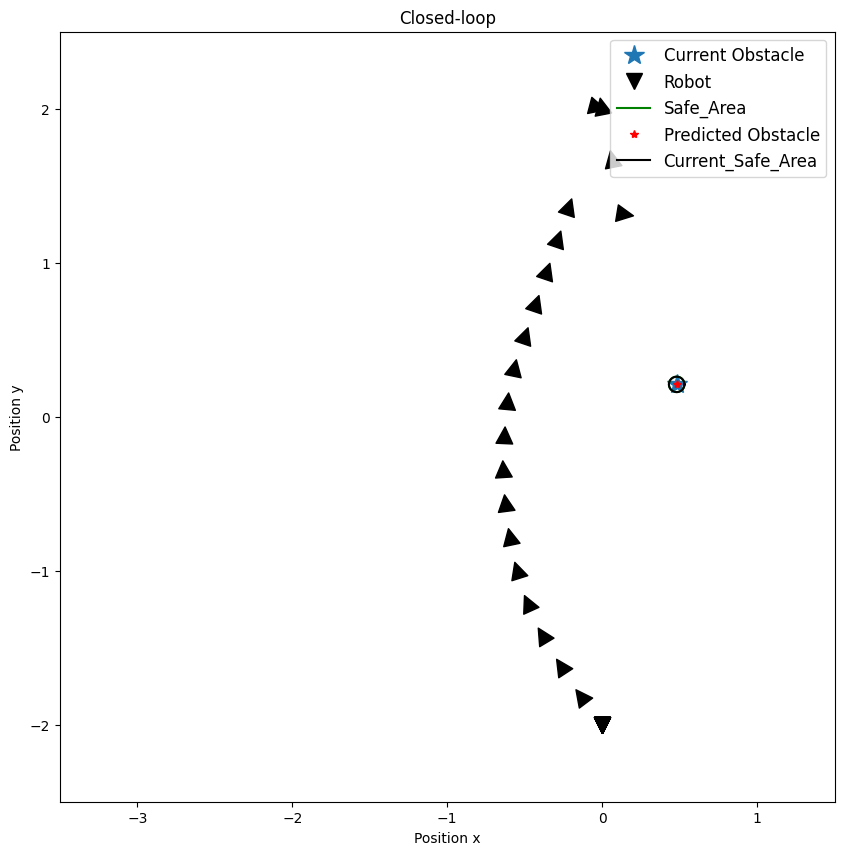

In [40]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# Closed-loop MPC

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *

opti = casadi.Opti()

eps = 0.2
L = 1
Delta = 1/10
T = 20
H = 20

for i in range(T):
    x_H10_1[i] = original_x_1[0:T] + x_H10_1[i]
    y_H10_1[i] = original_y_1[0:T] + y_H10_1[i]

x_state = [0]*T
y_state = [-2]*T

x_current = 0
y_current = -2

xref = 0
yref = 2

x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)
uv = opti.variable(T)
delta = opti.variable(T)

opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 1)
opti.set_initial(theta[0], pi)

p_opts = {"expand":True}
s_opts = {"max_iter": 3000}
opti.solver('ipopt', p_opts, s_opts)

for t in range(T):
    obj = 0
    for i in range(1, T):
        #opti.subject_to(opti.bounded(0, V[i], 3))
        opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
        #opti.subject_to(opti.bounded(-3, uv[i], 3))
        opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
        opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
        opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
        opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
        
        obj += delta[i-1]**2 + uv[i-1]**2
        opti.minimize(obj)
        
    for tau in range(H):
        opti.subject_to(sqrt((x[tau]-x_H10_1[t][T+tau])**2+(y[tau]-y_H10_1[t][T+tau])**2) >= d_20_1[t][tau]+eps)
            
    opti.subject_to(x[0]-x_current == 0)
    opti.subject_to(y[0]-y_current == 0)
    opti.subject_to(x[T-t-1]-xref == 0)
    opti.subject_to(y[T-t-1]-yref == 0)

    sol = opti.solve()

    x_current = sol.value(x)[1]
    y_current = sol.value(y)[1]
    
    x_state.append(x_current)
    y_state.append(y_current)
    
    x = opti.variable(T)
    y = opti.variable(T)
    V = opti.variable(T)
    theta = opti.variable(T)

    uv = opti.variable(T)
    delta = opti.variable(T)
    
    opti.set_initial(x[0], x_current)
    opti.set_initial(y[0], y_current)
    
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-3.5, 1.5),
            ylim =(-2.5, 2.5))
ts = np.linspace(0,2*pi,100)

p_line, = axis.plot([], [], '*', markersize = 15)
r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)
c_line, = axis.plot([], [], color = 'g')
af_line, = axis.plot([], [], '*', color = 'r')

arrow = axis.annotate("", xy=(2, 2), xytext=(0, 0), arrowprops={"facecolor": "black"})

x_robot, y_robot = [], []
x_pred, y_pred = [], []
x_circle, y_circle = [], []
x_af, y_af = [], []
ch_line, = axis.plot([], [], color = 'k')

def init(): 
    p_line.set_data([], [])
    c_line.set_data([], [])
    r_line.set_data([], [])
    af_line.set_data([], [])
    ch_line.set_data([], [])
    return p_line, r_line, c_line, af_line, ch_line,

def animate(i):
    global arrow
    if i <= 19:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= 20:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred, y_pred = [], []
    if i >= T:
        x_p = x_H10_1[i-T][T]
        y_p = y_H10_1[i-T][T]
        x_pred.append(x_p)
        y_pred.append(y_p)
        p_line.set_data(x_pred, y_pred)
    elif i <= T-1:
        x_p = x_H10_1[0][i]
        y_p = y_H10_1[0][i]
        x_pred.append(x_p)
        y_pred.append(y_p)
        p_line.set_data(x_pred, y_pred)

    x_af, y_af = [], []
    if T <= i <= T+T-1:
        for j in range(T+T-i):
            x_a = x_H10_1[i-T][T+j]
            y_a = y_H10_1[i-T][T+j]
            x_af.append(x_a)
            y_af.append(y_a)
            af_line.set_data(x_af, y_af)
    #if T <= i <= T+10-1:
    #    for j in range(H):
    #        x_a = x_H10_1[i-T][T+j]
    #        y_a = y_H10_1[i-T][T+j]
    #        x_af.append(x_a)
    #        y_af.append(y_a)
    #        af_line.set_data(x_af, y_af)
            
    x_circle, y_circle = [], []
    if T <= i <= T+T-1:
        for j in range(T+T-i):
            c_x = d_20_1[i-T][j] * np.cos(ts) + x_H10_1[i-T][T+j]
            c_y = d_20_1[i-T][j] * np.sin(ts) + y_H10_1[i-T][T+j]
            x_circle.append(c_x)
            y_circle.append(c_y)
            c_line.set_data(x_circle, y_circle)
    #if T <= i <= T+10-1:
    #    for j in range(H):
    #        c_x = d_20_1[i-T][j] * np.cos(ts) + x_H10_1[i-T][T+j]
    #        c_y = d_20_1[i-T][j] * np.sin(ts) + y_H10_1[i-T][T+j]
    #        x_circle.append(c_x)
    #        y_circle.append(c_y)
    #        c_line.set_data(x_circle, y_circle)
            
    xh_circle, yh_circle = [], []
    if i >= T:
        ch_x = d_20_1[i-T][0] * np.cos(ts) + x_H10_1[i-T][T]
        ch_y = d_20_1[i-T][0] * np.sin(ts) + y_H10_1[i-T][T]
        xh_circle.append(ch_x)
        yh_circle.append(ch_y)
        ch_line.set_data(xh_circle, yh_circle)
    return p_line, r_line, c_line, af_line, ch_line, arrow

plt.legend(['Current Obstacle', 'Robot', 'Safe_Area', 'Predicted Obstacle', 'Current_Safe_Area'], fontsize = 12)
plt.xlabel('Position x')
plt.ylabel('Position y')
plt.title("Closed-loop")

anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
gif_writer = ImageMagickWriter(fps=2)
anim.save('/home/hardik/Desktop/Research/social-navigation/conformal_prediction/closed_mpc_dynamic_one_ped.gif', writer=gif_writer)

40
40
Pred x1: [-3.41, -3.31, -3.21, -3.11, -3.01, -2.91, -2.81, -2.71, -2.61, -2.51, -2.41, -2.31, -2.21, -2.11, -2.01, -1.91, -1.81, -1.71, -1.61, -1.51, -3.41, -3.31, -3.21, -3.11, -3.01, -2.91, -2.81, -2.71, -2.61, -2.51, -2.41, -2.31, -2.21, -2.11, -2.01, -1.91, -1.81, -1.71, -1.61, -1.51, -1.41, -1.31, -1.21, -1.11, -1.01, -0.91, -0.81, -0.71, -0.61, -0.51, -0.4, -0.3, -0.2, -0.1, -0.0, 0.1, 0.2, 0.3, 0.4, 0.51]
Pred y1: [0.55, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.43, 0.42, 0.41, 0.4, 0.39, 0.55, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.32, 0.31, 0.3, 0.3, 0.29, 0.28, 0.28, 0.27, 0.26, 0.25, 0.25, 0.23, 0.22]
D1: [0.0316, 0.0583, 0.1118, 0.1676, 0.2059, 0.25, 0.2816, 0.3036, 0.3353, 0.3574, 0.3795, 0.3985, 0.4206, 0.4427, 0.4617, 0.4838, 0.53, 0.5852, 0.6351, 0.6768]
Pred x2: [3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.81, 2.71, 2

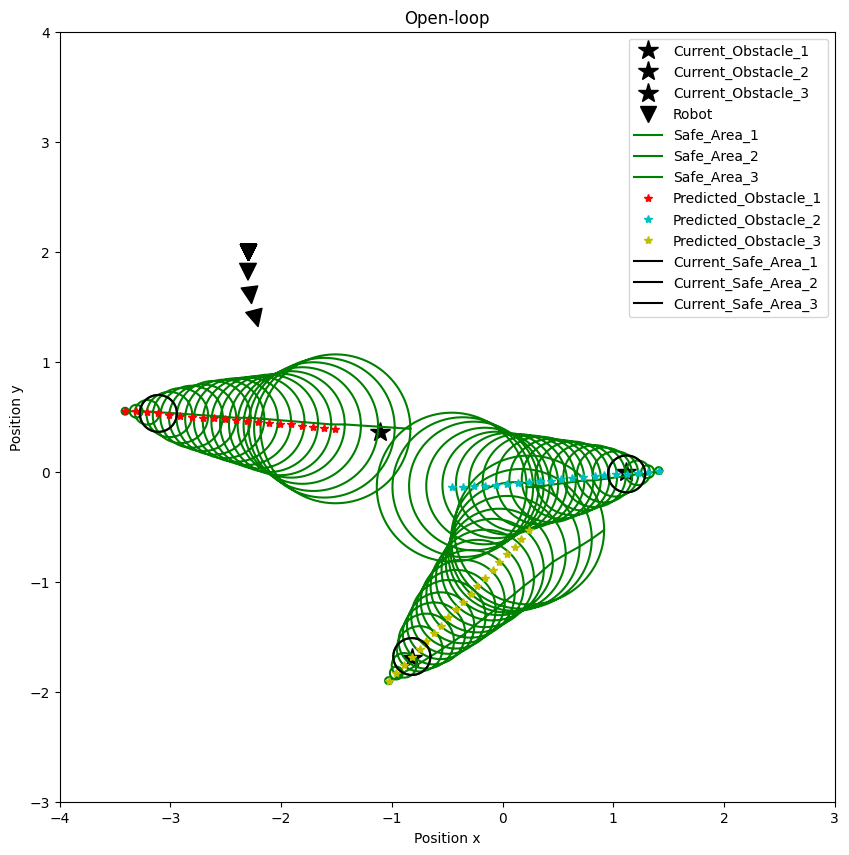

In [44]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# Open-loop MPC

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *
import imageio

opti = casadi.Opti()

predict_x1 = x_H10_1[0]
predict_y1 = y_H10_1[0]

print(len(predict_x1))
print(len(predict_y1))


predict_x2 = x_H10_2[0]
predict_y2 = y_H10_2[0]

predict_x3 = x_H10_3[0]
predict_y3 = y_H10_3[0]

d20_value_H20_1 = d_20_1[0]
d20_value_H20_2 = d_20_2[0]
d20_value_H20_3 = d_20_3[0]


T = 20
eps = 0
Delta = 1/8
L = 1

x_state = [-2.3]*(T-1)
y_state = [2]*(T-1)
v_state = [1]*(T-1)
theta_state = [0]*(T-1)
uv_state = [0]*(T-1)
delta_state = [0]*(T-1)

xref = 0.9
yref = -2.2

predict_x1 = original_x_1[0:T] + predict_x1
predict_y1 = original_y_1[0:T] + predict_y1

predict_x2 = original_x_2[0:T] + predict_x2
predict_y2 = original_y_2[0:T] + predict_y2

predict_x3 = original_x_3[0:T] + predict_x3
predict_y3 = original_y_3[0:T] + predict_y3

print("Pred x1: " + str(predict_x1))
print("Pred y1: " + str(predict_y1))
print("D1: " + str(d20_value_H20_1))

print("Pred x2: " + str(predict_x2))
print("Pred y2: " + str(predict_y2))
print("D2: " + str(d20_value_H20_2))

print("Pred x3: " + str(predict_x3))
print("Pred y3: " + str(predict_y3))
print("D3: " + str(d20_value_H20_3))


print("d vals")
print(d20_value_H20_1)
print(d20_value_H20_2)
print(d20_value_H20_3)


x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)

uv = opti.variable(T)
delta = opti.variable(T)

opti.subject_to(x[0]-x_state[0] == 0)
opti.subject_to(y[0]-y_state[0] == 0)
opti.subject_to(V[0] == 0)
opti.subject_to(theta[0] == -pi/2)


opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 1)
opti.set_initial(theta[0], -pi/2)

p_opts = {"expand":True}
s_opts = {"max_iter": 3000}
opti.solver('ipopt', p_opts, s_opts)

obj = 0

opti.subject_to(opti.bounded(-pi/6, delta[0], pi/6))
opti.subject_to(opti.bounded(-20, uv[0], 20))
for i in range(1, T):
    opti.subject_to(opti.bounded(0, V[i], 100))
    opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
    opti.subject_to(opti.bounded(-20, uv[i], 20))
    
    opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
    opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
    opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
    opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
    
for i in range(T):
    # obj += (4*delta[i-1])**2 + uv[i-1]**2
    # obj += uv[i-1]**2
    obj += V[i]**2

    opti.subject_to(sqrt((x[i]-predict_x1[i+T])**2+(y[i]-predict_y1[i+T])**2) >= d20_value_H20_1[i]+eps)
    opti.subject_to(sqrt((x[i]-predict_x2[i+T])**2+(y[i]-predict_y2[i+T])**2) >= d20_value_H20_2[i]+eps)
    opti.subject_to(sqrt((x[i]-predict_x3[i+T])**2+(y[i]-predict_y3[i+T])**2) >= d20_value_H20_3[i]+eps)

print("Obst 1 x,y,d")
print(predict_x1)
print(predict_y1)
print(d20_value_H20_1)

print("Obst 2 x,y,d")
print(predict_x2)
print(predict_y2)
print(d20_value_H20_2)

print("Obst 1 x,y,d")
print(predict_x3)
print(predict_y3)
print(d20_value_H20_3)

opti.minimize(obj)

# obj += V[T]**2

# opti.subject_to(x[T-1]-xref == 0)
# opti.subject_to(y[T-1]-yref == 0)
opti.subject_to((x[T-1]-xref)**2 + (y[T-1]-yref)**2 <= 0.4**2)
# opti.subject_to(V[T-1]**2 <= 0.5)

sol = opti.solve()

print("Obj value: " + str(sol.value(obj)))

x_state = x_state + list(sol.value(x)) + [list(sol.value(x))[T-1]]
y_state = y_state + list(sol.value(y)) + [list(sol.value(y))[T-1]]
v_state = v_state + list(sol.value(V)) + [list(sol.value(V))[T-1]]
theta_state = theta_state + list(sol.value(theta)) + [list(sol.value(theta))[T-1]]
uv_state = uv_state + list(sol.value(uv)) + [list(sol.value(theta))[T-1]]
delta_state = delta_state + list(sol.value(delta)) + [list(sol.value(delta))[T-1]]

print("x_states: " + str(x_state))
print("y_states: " + str(y_state))
print("v_states: " + str(v_state))
print("theta_states: " + str(theta_state))
print("uv_states: " + str(uv_state))
print("delta_states: " + str(delta_state))

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-4, 3),
            ylim =(-3, 4))

ts = np.linspace(0,2*pi,100)

arrow = axis.annotate("", xy=(0, 0), xytext=(0, 0), arrowprops={"facecolor": "black"})

p1_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p2_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p3_line, = axis.plot([], [], '*', color = 'k', markersize = 15)

r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)

c1_line, = axis.plot([], [], '-', color = 'g')
c2_line, = axis.plot([], [], '-', color = 'g')
c3_line, = axis.plot([], [], '-', color = 'g')

af1_line, = axis.plot([], [], '*', color = 'r')
af2_line, = axis.plot([], [], '*', color = 'c')
af3_line, = axis.plot([], [], '*', color = 'y')

ch1_line, = axis.plot([], [], color = 'k')
ch2_line, = axis.plot([], [], color = 'k')
ch3_line, = axis.plot([], [], color = 'k')

x_robot, y_robot = [], []

x_pred1, y_pred1 = [], []
x_pred2, y_pred2 = [], []
x_pred3, y_pred3 = [], []

x1_circle, y1_circle = [], []
x2_circle, y2_circle = [], []
x3_circle, y3_circle = [], []

x_af1, y_af1 = [], []
x_af2, y_af2 = [], []
x_af3, y_af3 = [], []

def init(): 
    p1_line.set_data([], [])
    p2_line.set_data([], [])
    p3_line.set_data([], [])
    
    r_line.set_data([], [])
    
    c1_line.set_data([], [])
    c2_line.set_data([], [])
    c3_line.set_data([], [])
    
    af1_line.set_data([], [])
    af2_line.set_data([], [])
    af3_line.set_data([], [])
    
    ch1_line.set_data([], [])
    ch2_line.set_data([], [])
    ch3_line.set_data([], [])
    
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line,

def animate(i):
    global arrow
    if i <= T-1:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= T:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred1, y_pred1 = [], []
    x_p1 = original_x_1[i]
    y_p1 = original_y_1[i]
    x_pred1.append(x_p1)
    y_pred1.append(y_p1)
    p1_line.set_data(x_pred1, y_pred1)
    
    x_pred2, y_pred2 = [], []
    x_p2 = original_x_2[i]
    y_p2 = original_y_2[i]
    x_pred2.append(x_p2)
    y_pred2.append(y_p2)
    p2_line.set_data(x_pred2, y_pred2)
    
    x_pred3, y_pred3 = [], []
    x_p3 = original_x_3[i]
    y_p3 = original_y_3[i]
    x_pred3.append(x_p3)
    y_pred3.append(y_p3)
    p3_line.set_data(x_pred3, y_pred3)
    
    x_af1, y_af1 = [], []
    x_af2, y_af2 = [], []
    x_af3, y_af3 = [], []
    if i >= T:
        x_a1 = predict_x1[T:T+T]
        y_a1 = predict_y1[T:T+T]
        x_af1 = x_af1 + x_a1
        y_af1 = y_af1 + y_a1
        af1_line.set_data(x_af1, y_af1)
    
        x_a2 = predict_x2[T:T+T]
        y_a2 = predict_y2[T:T+T]
        x_af2 = x_af2 + x_a2
        y_af2 = y_af2 + y_a2
        af2_line.set_data(x_af2, y_af2)
        
        x_a3 = predict_x3[T:T+T]
        y_a3 = predict_y3[T:T+T]
        x_af3 = x_af3 + x_a3
        y_af3 = y_af3 + y_a3
        af3_line.set_data(x_af3, y_af3)
        
    x1_circle, y1_circle = [], []
    x2_circle, y2_circle = [], []
    x3_circle, y3_circle = [], []
    if i >= T:
        for j in range(T):
            c_x1 = d20_value_H20_1[j] * np.cos(ts) + predict_x1[T+j]
            c_y1 = d20_value_H20_1[j] * np.sin(ts) + predict_y1[T+j]
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            c1_line.set_data(x1_circle, y1_circle)
            
            c_x2 = d20_value_H20_2[j] * np.cos(ts) + predict_x2[T+j]
            c_y2 = d20_value_H20_2[j] * np.sin(ts) + predict_y2[T+j]
            x2_circle.append(c_x2)
            y2_circle.append(c_y2)
            c2_line.set_data(x2_circle, y2_circle)
            
            c_x3 = d20_value_H20_3[j] * np.cos(ts) + predict_x3[T+j]
            c_y3 = d20_value_H20_3[j] * np.sin(ts) + predict_y3[T+j]
            x3_circle.append(c_x3)
            y3_circle.append(c_y3)
            c3_line.set_data(x3_circle, y3_circle)
    
    xh1_circle, yh1_circle = [], []
    xh2_circle, yh2_circle = [], []
    xh3_circle, yh3_circle = [], []
    if i >= T:
        ch_x1 = d20_value_H20_1[i-T] * np.cos(ts) + predict_x1[i]
        ch_y1 = d20_value_H20_1[i-T] * np.sin(ts) + predict_y1[i]
        xh1_circle.append(ch_x1)
        yh1_circle.append(ch_y1)
        ch1_line.set_data(xh1_circle, yh1_circle)
        
        ch_x2 = d20_value_H20_2[i-T] * np.cos(ts) + predict_x2[i]
        ch_y2 = d20_value_H20_2[i-T] * np.sin(ts) + predict_y2[i]
        xh2_circle.append(ch_x2)
        yh2_circle.append(ch_y2)
        ch2_line.set_data(xh2_circle, yh2_circle)
        
        ch_x3 = d20_value_H20_3[i-T] * np.cos(ts) + predict_x3[i]
        ch_y3 = d20_value_H20_3[i-T] * np.sin(ts) + predict_y3[i]
        xh3_circle.append(ch_x3)
        yh3_circle.append(ch_y3)
        ch3_line.set_data(xh3_circle, yh3_circle)
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line, arrow


for i in range(T+20):
    # plt.grid()

    if i <=T+3:
        plt.legend(['Current_Obstacle_1', 'Current_Obstacle_2', 'Current_Obstacle_3', 
                    'Robot', 'Safe_Area_1', 'Safe_Area_2', 'Safe_Area_3', 'Predicted_Obstacle_1', 
                    'Predicted_Obstacle_2', 'Predicted_Obstacle_3', 'Current_Safe_Area_1', 
                    'Current_Safe_Area_2', 'Current_Safe_Area_3'], fontsize = 10)

        plt.xlabel('Position x')
        plt.ylabel('Position y')
        plt.title("Open-loop")
    else:
        break

    animate(i)

    plt.savefig("/home/hardik/Desktop/Research/social-navigation/conformal_prediction/figures/openLoop_maxNorm/fig_%02i.png" % i)

    

# anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
# gif_writer = ImageMagickWriter(fps=2)
# anim.save('open_mpc_dynamic_three_ped.gif', writer=gif_writer)

20
60
d vals
[[0.0316, 0.0583, 0.1118, 0.1676, 0.2059, 0.25, 0.2816, 0.3036, 0.3353, 0.3574, 0.3795, 0.3985, 0.4206, 0.4427, 0.4617, 0.4838, 0.53, 0.5852, 0.6351, 0.6768], [0.0224, 0.0316, 0.0608, 0.103, 0.1476, 0.1836, 0.2247, 0.2608, 0.2968, 0.3245, 0.3551, 0.3912, 0.4327, 0.4743, 0.5108, 0.5423, 0.5701, 0.5924, 0.6239, 0.6462], [0.0224, 0.0447, 0.0806, 0.1281, 0.164, 0.2062, 0.2421, 0.278, 0.314, 0.3421, 0.3701, 0.4061, 0.4482, 0.4833, 0.5148, 0.5423, 0.5646, 0.5962, 0.6185, 0.6555], [0.0224, 0.0447, 0.0943, 0.1304, 0.1703, 0.1903, 0.23, 0.24, 0.2602, 0.2702, 0.2902, 0.3102, 0.3471, 0.3883, 0.4374, 0.4707, 0.4653, 0.4627, 0.4768, 0.4884], [0.0224, 0.05, 0.0583, 0.0943, 0.1166, 0.1389, 0.1612, 0.1836, 0.211, 0.2335, 0.2778, 0.3191, 0.3606, 0.4159, 0.4383, 0.4428, 0.4418, 0.4405, 0.4501, 0.4501], [0.02, 0.0361, 0.051, 0.0806, 0.102, 0.1204, 0.1414, 0.1655, 0.1887, 0.2335, 0.2683, 0.2941, 0.3162, 0.3245, 0.3467, 0.3551, 0.3636, 0.378, 0.414, 0.4441], [0.0224, 0.0361, 0.05, 0.0707, 0.09

  47  9.7902753e+01 4.15e-03 8.07e-01  -1.0 1.52e+01    -  8.98e-01 1.00e+00f  1
  48  9.7235761e+01 5.13e-04 5.00e-01  -1.7 3.08e-01  -1.3 8.80e-01 1.00e+00f  1
  49  9.7129617e+01 6.84e-03 3.43e-01  -1.7 4.45e+00    -  6.07e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  9.7128145e+01 1.17e-03 2.18e-02  -1.7 3.29e-01  -1.8 1.00e+00 1.00e+00h  1
  51  9.6925408e+01 3.22e-04 2.19e-01  -3.8 6.02e-01    -  8.33e-01 9.86e-01h  1
  52  9.6904248e+01 1.24e-04 2.61e-02  -3.8 2.24e-01    -  9.30e-01 1.00e+00h  1
  53  9.6900799e+01 1.63e-03 5.83e-05  -3.8 2.43e+00    -  1.00e+00 1.00e+00h  1
  54  9.6900386e+01 1.24e-02 1.13e-04  -3.8 5.14e+00    -  1.00e+00 1.00e+00h  1
  55  9.6900329e+01 2.99e-03 6.06e-05  -3.8 3.20e+00    -  1.00e+00 1.00e+00h  1
  56  9.6900325e+01 2.58e-04 1.20e-06  -3.8 8.95e-01    -  1.00e+00 1.00e+00h  1
  57  9.6898439e+01 4.70e-07 2.61e-06  -5.7 3.59e-02    -  1.00e+00 1.00e+00h  1
  58  9.6898406e+01 7.30e-07

  39  1.0671214e+02 1.91e-01 5.09e+01  -1.0 2.03e+00  -0.5 3.60e-01 2.46e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  9.4290325e+01 4.11e-02 7.63e+01  -1.0 1.90e+01    -  1.43e-01 9.24e-01f  1
  41  9.4059516e+01 1.40e-02 2.85e+01  -1.0 1.21e+01    -  2.53e-01 9.53e-01f  1
  42  9.1493338e+01 6.23e-03 1.46e+01  -1.0 8.38e+00    -  4.68e-01 6.29e-01f  1
  43  9.1582892e+01 7.54e-03 7.58e+00  -1.0 3.27e+00    -  6.37e-01 1.00e+00f  1
  44  9.1345724e+01 8.25e-03 5.54e+00  -1.0 4.87e+00    -  3.54e-01 1.00e+00f  1
  45  9.1285486e+01 8.16e-03 6.41e+00  -1.0 5.84e+01    -  7.28e-02 1.16e-02f  2
  46  9.1235064e+01 1.11e-02 2.11e+00  -1.0 4.98e-01  -1.0 7.68e-01 6.34e-01f  1
  47  9.1130229e+01 1.99e-02 4.97e-01  -1.0 1.48e+01    -  8.38e-01 8.80e-01f  1
  48  9.0448852e+01 1.12e-03 5.49e-01  -1.7 1.38e+00    -  8.61e-01 1.00e+00f  1
  49  9.0383065e+01 5.28e-03 2.72e-02  -1.7 2.69e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  21r 1.4384345e+01 5.43e+00 9.82e+02   0.7 2.41e+02   0.4 4.59e-04 1.55e-03f  1
  22r 1.8178902e+01 5.43e+00 9.78e+02   0.7 1.95e+02    -  4.14e-03 4.75e-03f  1
  23r 1.9266168e+01 5.43e+00 9.60e+02   0.7 2.68e+01   0.8 2.19e-02 6.30e-03f  1
  24r 2.1834401e+01 5.43e+00 9.52e+02   0.7 4.48e+01   0.3 8.79e-03 9.57e-03f  1
  25r 2.5576051e+01 5.44e+00 9.28e+02   0.7 1.87e+01   0.7 2.58e-02 2.72e-02f  1
  26r 2.6508630e+01 5.43e+00 9.20e+02   0.7 1.62e+01   0.3 6.49e-03 8.26e-03f  1
  27r 2.7094613e+01 5.43e+00 9.17e+02   0.7 5.44e+01  -0.2 8.27e-03 4.12e-03f  1
  28r 3.1845912e+01 5.40e+00 9.00e+02   0.7 4.16e+01    -  1.79e-02 2.56e-02f  1
  29r 3.2096686e+01 5.40e+00 9.01e+02   0.7 1.76e+02    -  5.31e-04 2.39e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 3.3168047e+01 5.38e+00 9.00e+02   0.7 3.55e+01    -  3.75e-02 1.10e-02f  1
  31r 3.3281650e+01 5.37e+00 8.94e+02   0.7 7.27e+01    -  9.61e-04 4.76e-03f  1
  32r 3.4585333e+01 5.35e+00

 144  8.0461659e+01 2.48e-03 6.36e-10  -8.6 8.91e-01  -9.8 1.00e+00 1.00e+00h  1
 145  8.0461659e+01 9.39e-03 5.90e-09  -8.6 3.74e+00 -10.3 1.00e+00 1.00e+00h  1
 146  8.0461659e+01 8.37e-03 8.48e-09  -8.6 7.70e+00 -10.8 1.00e+00 1.00e+00H  1
 147  8.0461659e+01 6.41e-03 2.67e-09  -8.6 4.08e-01  -9.4 1.00e+00 1.00e+00H  1
 148  8.0461659e+01 4.00e-04 4.30e-10  -8.6 9.18e-01  -9.9 1.00e+00 1.00e+00h  1
 149  8.0461659e+01 1.79e-03 3.01e-09  -8.6 2.98e+00 -10.4 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  8.0461659e+01 2.30e-04 1.92e-10  -8.6 4.36e-01 -10.0 1.00e+00 1.00e+00h  1
 151  8.0461659e+01 3.49e-04 8.03e-10  -8.6 2.00e+00 -10.5 1.00e+00 1.00e+00H  1
 152  8.0461659e+01 1.32e-03 7.04e-09  -8.6 7.85e+01 -10.9 1.24e-01 2.72e-02h  3
 153  8.0461659e+01 1.35e-03 1.59e-08  -8.6 1.19e+01    -  1.00e+00 4.51e-02h  5
 154  8.0461659e+01 6.52e-04 9.39e-10  -8.6 3.66e+00    -  1.00e+00 1.00e+00H  1
 155  8.0461659e+01 1.74e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 1.7937683e+01 5.44e+00 9.45e+02   0.7 5.72e+02    -  3.52e-03 1.53e-03f  1
  21r 2.1379484e+01 5.44e+00 9.33e+02   0.7 6.21e+01   0.1 1.94e-02 1.24e-02f  1
  22r 2.2544594e+01 5.44e+00 9.05e+02   0.7 5.84e+00   1.5 6.87e-02 3.33e-02f  1
  23r 2.4898728e+01 5.43e+00 8.77e+02   0.7 1.22e+01   1.0 3.45e-02 3.55e-02f  1
  24r 2.5823187e+01 5.42e+00 8.35e+02   0.7 3.91e+00   1.4 1.10e-01 5.33e-02f  1
  25r 2.5872982e+01 5.41e+00 8.24e+02   0.7 5.83e+00   1.8 2.05e-02 1.30e-02f  1
  26r 2.6046528e+01 5.32e+00 8.46e+02   0.7 7.94e-01   2.3 6.12e-02 1.55e-01f  1
  27r 2.6152032e+01 5.23e+00 9.58e+02   0.7 1.03e+00   2.7 1.11e-01 1.83e-01f  1
  28r 2.6207093e+01 5.15e+00 7.69e+02   0.7 3.91e-01   3.1 3.03e-01 2.80e-01f  1
  29r 2.6259579e+01 5.08e+00 6.25e+02   0.7 2.05e-01   3.5 9.10e-01 5.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 2.6350633e+01 4.96e+00

 113r 6.8328924e+01 9.10e-06 1.90e-07  -7.1 1.22e-02    -  1.00e+00 1.00e+00h  1
 114r 6.8267801e+01 4.68e-07 1.87e-08  -7.1 5.83e-03    -  1.00e+00 1.00e+00h  1
 115r 6.8259265e+01 1.83e-09 3.48e-10  -7.1 1.45e-03    -  1.00e+00 1.00e+00h  1
 116r 6.8148557e+01 9.67e-06 2.13e-06  -9.0 4.48e-02    -  1.00e+00 1.00e+00h  1
 117r 6.8144567e+01 3.30e-08 5.40e-09  -9.0 2.75e-03    -  1.00e+00 1.00e+00h  1
 118r 6.8121324e+01 6.80e-07 7.25e-10  -9.0 1.19e-02    -  1.00e+00 1.00e+00h  1
 119r 6.8117115e+01 2.37e-08 2.48e-11  -9.0 2.21e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 6.8116961e+01 3.32e-11 1.14e-13  -9.0 8.19e-05    -  1.00e+00 1.00e+00h  1
 121  6.8116064e+01 2.91e-10 4.45e+00  -8.6 1.78e+01    -  2.94e-02 6.58e-06f  7
 122  6.8001422e+01 9.68e-02 4.45e+00  -8.6 5.92e+02    -  1.17e-03 8.42e-04f  1
 123  6.6931499e+01 9.73e-02 4.41e+00  -8.6 2.02e+01    -  2.31e-02 7.90e-03f  1
 124  6.6218786e+01 9.79e-02

Obst 1 x,y,d
[-3.41, -3.31, -3.21, -3.11, -3.01, -2.91, -2.81, -2.71, -2.61, -2.51, -2.41, -2.31, -2.21, -2.11, -2.01, -1.91, -1.81, -1.71, -1.61, -1.51, -3.41, -3.31, -3.21, -3.11, -3.01, -2.91, -2.81, -2.71, -2.61, -2.51, -2.41, -2.31, -2.21, -2.11, -2.01, -1.91, -1.81, -1.71, -1.61, -1.51, -0.91, -0.82, -0.71, -0.62, -0.52, -0.42, -0.32, -0.22, -0.12, -0.03, 0.07, 0.17, 0.27, 0.37, 0.47, 0.57, 0.67, 0.77, 0.87, 0.98]
[0.55, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.43, 0.42, 0.41, 0.4, 0.39, 0.55, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.43, 0.42, 0.41, 0.4, 0.39, 0.34, 0.32, 0.31, 0.3, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.21, 0.2, 0.19, 0.17, 0.16, 0.14, 0.13, 0.11, 0.1]
[0.02, 0.0361, 0.051, 0.0806, 0.102, 0.1204, 0.1414, 0.1655, 0.1887, 0.2335, 0.2683, 0.2941, 0.3162, 0.3245, 0.3467, 0.3551, 0.3636, 0.378, 0.414, 0.4441]
Obst 2 x,y,d
[3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.81, 2.71, 2.61, 2.51,

  69  6.2502463e+01 1.02e+00 7.40e+03  -1.0 7.69e+00   0.6 6.46e-01 1.83e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  6.4100004e+01 6.56e-01 7.16e+03  -1.0 6.83e+00   0.2 2.48e-01 3.92e-01h  1
  71  6.4159610e+01 6.33e-01 3.45e+03  -1.0 6.32e+00  -0.3 2.74e-01 3.41e-02h  1
  72  6.4816338e+01 4.63e-01 3.76e+03  -1.0 2.64e+00   0.1 1.49e-01 2.80e-01f  1
  73  6.5326763e+01 2.49e-01 3.03e+03  -1.0 8.62e+00  -0.4 3.70e-01 4.99e-01f  1
  74  6.6087138e+01 2.76e-02 2.97e+03  -1.0 1.23e+00   0.1 4.22e-01 1.00e+00f  1
  75  6.6098605e+01 8.57e-03 5.34e+02  -1.0 1.61e-01   1.4 8.20e-01 8.12e-01f  1
  76  6.6099379e+01 2.91e-03 6.17e+02  -1.0 5.51e-02   1.8 1.00e+00 3.67e-01f  1
  77  6.6088459e+01 1.31e-05 2.95e+00  -1.0 4.90e-02   1.3 1.00e+00 1.00e+00f  1
  78  6.6036882e+01 2.69e-04 1.18e+01  -1.0 1.56e-01   0.9 7.79e-01 1.00e+00f  1
  79  6.6019553e+01 2.80e-04 1.15e+01  -1.0 5.06e-02   1.3 9.10e-01 9.13e-01f  1
iter    objective    inf_pr 

 164  6.3266789e+01 2.57e-04 4.57e-13  -8.6 1.21e-01    -  1.00e+00 1.00e+00h  1
 165  6.3266789e+01 2.84e-08 2.84e-14  -8.6 1.14e-03    -  1.00e+00 1.00e+00h  1
 166  6.3266789e+01 3.55e-15 2.51e-14  -8.6 1.39e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 166

                                   (scaled)                 (unscaled)
Objective...............:   6.3266788580237758e+01    6.3266788580237758e+01
Dual infeasibility......:   2.5059035600428338e-14    2.5059035600428338e-14
Constraint violation....:   3.5527136788005009e-15    3.5527136788005009e-15
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800634e-09    2.5059035596800634e-09
Overall NLP error.......:   2.5059035596800634e-09    2.5059035596800634e-09


Number of objective function evaluations             = 253
Number of objective gradient evaluations             = 139
Number of equality constraint evaluations            = 253
Number of ine

  18r 1.1170833e+01 5.41e+00 9.94e+02   0.7 3.58e+02    -  1.42e-03 2.30e-03f  1
  19r 1.3800385e+01 5.43e+00 9.86e+02   0.7 4.29e+01   0.9 7.50e-03 1.48e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 1.4606470e+01 5.43e+00 9.84e+02   0.7 9.13e+02    -  1.86e-03 9.26e-04f  1
  21r 1.8414219e+01 5.43e+00 9.83e+02   0.7 8.72e+01    -  1.41e-03 3.91e-03f  1
  22r 1.8634064e+01 5.43e+00 9.81e+02   0.7 1.72e+02   0.4 1.81e-03 1.01e-03f  1
  23r 1.9782683e+01 5.43e+00 9.78e+02   0.7 5.63e+01   0.8 3.45e-03 8.16e-03f  1
  24r 2.1143139e+01 5.44e+00 9.65e+02   0.7 1.69e+01   1.2 1.23e-02 1.81e-02f  1
  25r 2.4223777e+01 5.44e+00 9.64e+02   0.7 4.71e+01   0.7 1.34e-03 1.03e-02f  1
  26r 2.4475028e+01 5.44e+00 9.57e+02   0.7 1.49e+02   0.3 6.53e-03 1.51e-03f  1
  27r 2.6480286e+01 5.45e+00 9.79e+02   0.7 3.53e+01   0.7 6.19e-03 1.87e-02f  1
  28r 2.6488768e+01 5.45e+00 9.77e+02   0.7 1.33e+03   0.2 3.93e-04 6.06e-05f  1
  29r 2.6628194e+01 5.45e+00

 125  5.9793482e+01 2.49e-03 5.94e+00  -1.0 2.21e-01  -0.2 7.96e-01 8.91e-01f  1
 126  5.9714217e+01 7.17e-03 4.18e+00  -1.0 6.84e-01  -0.7 6.09e-01 1.00e+00f  1
 127  5.9550075e+01 3.26e-03 8.78e+00  -1.0 8.48e-01  -1.2 5.38e-01 1.00e+00f  1
 128  5.9309750e+01 6.19e-03 2.03e+00  -1.0 1.65e+00  -1.7 1.00e+00 1.00e+00f  1
 129  5.9151706e+01 1.43e-02 9.41e-01  -1.0 3.03e+00  -2.1 5.14e-01 7.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  5.9063103e+01 1.25e-02 8.19e-01  -1.7 4.08e+01  -2.6 1.83e-01 1.27e-01H  1
 131  5.8590268e+01 1.06e-03 5.81e-01  -1.7 2.04e+00  -2.2 7.57e-01 1.00e+00h  1
 132  5.8508346e+01 7.72e-03 1.67e-01  -1.7 1.20e+01    -  7.21e-01 1.00e+00f  1
 133  5.8427758e+01 3.53e-04 8.54e-02  -2.5 4.77e-01  -2.7 8.58e-01 1.00e+00h  1
 134  5.8416545e+01 5.16e-04 5.51e-03  -2.5 3.91e-01  -3.2 1.00e+00 1.00e+00h  1
 135  5.8403656e+01 5.02e-06 5.12e-04  -3.8 2.20e-01  -3.6 1.00e+00 1.00e+00h  1
 136  5.8400997e+01 7.67e-08

   9r 6.5325182e-02 5.48e+00 9.99e+02   0.7 3.26e+03    -  6.71e-04 1.20e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r 1.4930909e-01 5.49e+00 9.98e+02   0.7 6.30e+02    -  1.99e-03 9.10e-04f  1
  11r 4.0677174e-01 5.51e+00 9.97e+02   0.7 3.78e+02   0.0 5.24e-03 2.80e-03f  1
  12r 9.7919990e-01 5.53e+00 9.94e+02   0.7 1.22e+02    -  1.81e-03 2.41e-03f  1
  13r 1.1787090e+00 5.53e+00 9.87e+02   0.7 1.64e+01   1.3 4.10e-02 9.30e-03f  1
  14r 2.7939442e+00 5.52e+00 9.83e+02   0.7 1.59e+02    -  3.96e-03 3.70e-03f  1
  15r 3.3749276e+00 5.52e+00 9.57e+02   0.7 7.83e+00   1.8 2.76e-02 4.39e-02f  1
  16r 4.1187528e+00 5.50e+00 9.48e+02   0.7 1.68e+01   1.3 1.74e-02 1.46e-02f  1
  17r 5.5177743e+00 5.48e+00 9.37e+02   0.7 4.71e+01   0.8 5.61e-03 1.16e-02f  1
  18r 6.3144079e+00 5.48e+00 9.24e+02   0.7 1.82e+01   1.2 9.71e-03 1.63e-02f  1
  19r 6.7775987e+00 5.48e+00 9.20e+02   0.7 8.19e+01   0.7 3.11e-03 4.22e-03f  1
iter    objective    inf_pr 

 106  5.5499080e+01 2.97e-04 5.56e+00  -1.0 7.52e-02   0.7 8.74e-01 1.00e+00f  1
 107  5.5468867e+01 6.56e-04 1.90e+00  -1.0 2.11e-01   0.2 9.56e-01 1.00e+00f  1
 108  5.5457916e+01 4.35e-04 2.17e+00  -1.0 1.01e-01   0.7 8.73e-01 1.00e+00f  1
 109  5.5427207e+01 1.10e-02 4.79e+01  -1.0 5.16e-01   0.2 4.67e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.5347405e+01 2.21e-03 2.70e+01  -1.0 2.39e-01  -0.3 2.74e-01 1.00e+00f  1
 111  5.5168167e+01 5.42e-02 8.58e+00  -1.0 5.29e-01  -0.8 5.99e-01 1.00e+00f  1
 112  5.4863161e+01 1.50e-02 6.07e+00  -1.0 1.20e+00  -1.3 4.29e-01 1.00e+00f  1
 113  5.4505765e+01 3.59e-03 1.73e+00  -1.0 2.14e+00  -1.7 7.03e-01 1.00e+00f  1
 114  5.4409010e+01 9.89e-03 9.24e-01  -1.0 6.18e+00  -2.2 5.20e-01 3.26e-01f  1
 115  5.3862227e+01 1.10e-03 4.56e-01  -1.7 1.70e+00  -1.8 8.59e-01 1.00e+00h  1
 116  5.3785986e+01 6.82e-04 2.46e-02  -1.7 5.60e-01  -1.4 1.00e+00 1.00e+00h  1
 117  5.3626919e+01 4.00e-05

   5  2.1033641e-03 5.47e+00 5.52e+02  -1.0 3.48e+02    -  1.75e-03 4.61e-04f  1
   6  2.3667500e-03 5.47e+00 1.47e+03  -1.0 3.27e+02    -  1.06e-03 2.46e-04h  1
   7  2.8525236e-03 5.47e+00 4.48e+03  -1.0 5.64e+02    -  1.10e-03 4.21e-04h  1
   8r 2.8525236e-03 5.47e+00 1.00e+03   0.7 0.00e+00    -  0.00e+00 3.24e-07R  5
   9r 5.5751118e-02 5.48e+00 9.99e+02   0.7 3.26e+03    -  6.71e-04 1.20e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r 1.3026855e-01 5.49e+00 9.98e+02   0.7 6.30e+02    -  1.99e-03 9.10e-04f  1
  11r 3.6352526e-01 5.51e+00 9.97e+02   0.7 3.78e+02   0.0 5.24e-03 2.80e-03f  1
  12r 8.5118172e-01 5.53e+00 9.94e+02   0.7 1.22e+02    -  1.81e-03 2.41e-03f  1
  13r 1.0196504e+00 5.53e+00 9.87e+02   0.7 1.64e+01   1.3 4.10e-02 9.30e-03f  1
  14r 1.7376970e+00 5.52e+00 9.83e+02   0.7 1.58e+02    -  3.96e-03 3.70e-03f  1
  15r 2.1611322e+00 5.52e+00 9.57e+02   0.7 7.84e+00   1.8 2.76e-02 4.39e-02f  1
  16r 2.5726102e+00 5.50e+00

 105  4.9569860e+01 8.67e-03 4.60e+00  -1.0 1.08e+00  -1.4 6.60e-01 8.72e-01f  1
 106  4.9462728e+01 1.56e-02 2.98e+00  -1.0 1.45e+00  -1.8 5.82e-01 1.00e+00f  1
 107  4.9404666e+01 1.13e-02 1.47e+00  -1.0 3.89e+00  -2.3 4.38e-01 6.16e-01f  1
 108  4.9377180e+01 6.55e-03 5.92e-01  -1.0 1.42e+00  -1.9 6.02e-01 1.00e+00f  1
 109  4.8923748e+01 1.16e-04 1.72e-01  -1.7 5.90e-01  -1.5 9.30e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.8750158e+01 3.97e-05 1.22e-02  -2.5 1.07e+00  -1.9 1.00e+00 1.00e+00f  1
 111  4.8685546e+01 3.62e-05 4.54e-03  -3.8 1.19e+00  -2.4 1.00e+00 1.00e+00f  1
 112  4.8670686e+01 1.79e-04 8.64e-04  -3.8 6.82e-01  -2.9 1.00e+00 1.00e+00h  1
 113  4.8667623e+01 5.82e-07 8.27e-05  -5.7 1.96e-01  -3.4 1.00e+00 1.00e+00h  1
 114  4.8666980e+01 1.66e-06 6.39e-06  -5.7 4.54e-02  -3.9 1.00e+00 1.00e+00h  1
 115  4.8666821e+01 7.70e-06 8.08e-07  -5.7 1.72e-02  -4.3 1.00e+00 1.00e+00h  1
 116  4.8666781e+01 2.17e-05

   1  1.0322010e-05 5.49e+00 4.51e+00  -1.0 1.59e+01    -  4.54e-03 9.22e-04f  1
   2  6.8510060e-04 5.48e+00 3.77e+00  -1.0 8.60e+01    -  1.08e-03 2.69e-03f  1
   3  7.3088671e-04 5.48e+00 5.62e+01  -1.0 1.18e+02    -  3.35e-03 8.77e-05h  1
   4  1.2117795e-03 5.48e+00 2.07e+02  -1.0 2.08e+02    -  2.48e-03 7.74e-04f  1
   5  1.5577848e-03 5.47e+00 5.52e+02  -1.0 3.48e+02    -  1.75e-03 4.61e-04f  1
   6  1.7605488e-03 5.47e+00 1.47e+03  -1.0 3.27e+02    -  1.06e-03 2.46e-04h  1
   7  2.1358435e-03 5.47e+00 4.48e+03  -1.0 5.64e+02    -  1.10e-03 4.21e-04h  1
   8r 2.1358435e-03 5.47e+00 1.00e+03   0.7 0.00e+00    -  0.00e+00 3.24e-07R  5
   9r 4.5082382e-02 5.48e+00 9.99e+02   0.7 3.26e+03    -  6.71e-04 1.20e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r 1.0946248e-01 5.49e+00 9.98e+02   0.7 6.30e+02    -  1.99e-03 9.10e-04f  1
  11r 3.1195024e-01 5.51e+00 9.97e+02   0.7 3.78e+02   0.0 5.24e-03 2.80e-03f  1
  12r 7.6458551e-01 5.53e+00

  94  4.5712843e+01 2.56e-01 1.17e+01  -1.0 2.88e+00   0.4 5.64e-02 6.09e-02f  1
  95  4.5705356e+01 2.43e-01 3.14e+02  -1.0 5.82e+00  -0.1 4.83e-01 7.39e-02h  1
  96  4.5708405e+01 2.19e-01 3.02e+03  -1.0 1.92e+00   2.1 7.59e-03 5.83e-02f  1
  97  4.5718748e+01 1.99e-01 2.66e+03  -1.0 1.54e-01   1.7 9.27e-03 1.55e-01f  1
  98  4.5732799e+01 1.55e-01 2.03e+03  -1.0 2.11e-01   1.2 2.21e-01 2.37e-01h  1
  99  4.5749327e+01 1.54e-02 1.09e+02  -1.0 1.67e-01   0.7 3.68e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.5646128e+01 6.44e-03 1.79e+00  -1.0 2.10e-01   0.2 1.00e+00 1.00e+00f  1
 101  4.5482704e+01 8.66e-03 1.95e+01  -1.0 3.84e-01  -0.3 5.58e-01 1.00e+00f  1
 102  4.5298545e+01 2.42e-02 2.48e+01  -1.0 6.38e-01  -0.7 5.15e-01 1.00e+00f  1
 103  4.5252235e+01 2.24e-03 3.16e+00  -1.0 2.98e-01  -0.3 7.98e-01 1.00e+00f  1
 104  4.5159053e+01 4.36e-03 8.30e-01  -1.0 8.38e-01  -0.8 1.00e+00 1.00e+00f  1
 105  4.4986338e+01 1.78e-04

   7  1.4760125e-03 5.47e+00 4.48e+03  -1.0 5.64e+02    -  1.10e-03 4.21e-04h  1
   8r 1.4760125e-03 5.47e+00 1.00e+03   0.7 0.00e+00    -  0.00e+00 3.24e-07R  5
   9r 2.0669288e-02 5.48e+00 9.99e+02   0.7 3.26e+03    -  6.71e-04 8.84e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r 8.7021251e-02 5.49e+00 9.98e+02   0.7 1.17e+03    -  1.78e-03 1.39e-03f  1
  11r 1.5863124e-01 5.51e+00 9.97e+02   0.7 7.08e+02   0.0 3.22e-03 1.55e-03f  1
  12r 4.3618902e-01 5.52e+00 9.94e+02   0.7 7.08e+01    -  1.48e-03 2.68e-03f  1
  13r 5.2685308e-01 5.53e+00 9.88e+02   0.7 1.27e+01   1.3 4.29e-02 8.65e-03f  1
  14r 5.2917378e-01 5.53e+00 9.89e+02   0.7 3.95e+03   0.9 1.40e-04 1.06e-04f  1
  15r 7.2564136e-01 5.54e+00 9.79e+02   0.7 2.87e+01   1.3 1.00e-02 1.77e-02f  1
  16r 8.0212334e-01 5.54e+00 9.67e+02   0.7 6.00e+00   1.7 6.66e-02 1.59e-02f  1
  17r 9.5408228e-01 5.54e+00 9.16e+02   0.7 2.56e+00   2.1 5.83e-02 7.46e-02f  1
  18r 1.1026628e+00 5.51e+00

 121  4.3474465e+01 4.35e-01 2.71e+01  -1.0 7.14e+00    -  7.00e-01 2.09e-01f  1
 122  4.2457330e+01 3.10e-01 1.50e+01  -1.0 1.61e+01    -  1.84e-01 2.86e-01f  1
 123  4.2425523e+01 2.94e-01 1.79e+02  -1.0 6.40e-01   0.0 9.95e-01 5.16e-02h  1
 124  4.1829250e+01 1.45e-01 3.25e+01  -1.0 4.51e+00  -0.5 2.38e-01 5.08e-01h  1
 125  4.0788099e+01 5.14e-03 2.34e+02  -1.0 2.15e+00  -1.0 3.25e-01 1.00e+00f  1
 126  4.0767231e+01 8.86e-02 1.70e+02  -1.0 2.42e+00  -0.5 2.77e-01 1.47e-01f  1
 127  4.0765814e+01 6.77e-02 9.32e+01  -1.0 2.47e-01   0.8 4.29e-01 2.36e-01f  1
 128  4.0765722e+01 5.32e-02 2.22e+02  -1.0 4.07e-01   1.2 6.72e-02 2.23e-01f  1
 129  4.0758490e+01 1.04e-02 4.18e+01  -1.0 9.93e-02   0.7 1.00e+00 8.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.0728591e+01 7.88e-04 3.13e+00  -1.0 1.50e-01   0.3 1.00e+00 1.00e+00f  1
 131  4.0663774e+01 2.07e-03 3.82e+00  -1.0 4.65e-01  -0.2 6.37e-01 1.00e+00f  1
 132  4.0642589e+01 5.71e-04

 219  3.8933408e+01 3.57e-02 1.73e-08  -8.6 1.24e+00  -9.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  3.8933408e+01 4.36e-02 3.89e-09  -8.6 1.48e+00  -9.5 1.00e+00 1.00e+00h  1
 221  3.8933408e+01 1.79e-01 1.57e-08  -8.6 4.10e+00 -10.0 6.68e-01 1.00e+00h  1
 222  3.8933408e+01 2.93e-01 4.53e-09  -8.6 4.50e+00 -10.5 1.00e+00 1.00e+00h  1
 223  3.8933408e+01 3.87e-01 4.26e-09  -8.6 1.34e+01 -11.0 9.56e-01 5.00e-01h  2
 224  3.8933408e+01 3.52e-01 4.03e-09  -8.6 1.74e+01 -11.4 1.00e+00 2.50e-01h  3
 225  3.8933408e+01 3.52e-01 7.79e-09  -8.6 1.13e+03 -11.9 1.06e-02 1.05e-04h  8
 226  3.8933408e+01 3.72e-02 2.41e-10  -8.6 3.37e+00 -10.6 1.00e+00 1.00e+00h  1
 227  3.8933408e+01 1.11e-01 5.98e-10  -8.6 4.70e+00 -11.1 1.00e+00 1.00e+00h  1
 228  3.8933408e+01 3.09e-02 1.32e-10  -8.6 2.86e+00 -11.5 1.00e+00 1.00e+00h  1
 229  3.8933408e+01 6.75e-03 1.39e-09  -8.6 4.17e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  11r 1.3844592e-01 5.50e+00 9.98e+02   0.7 7.65e+02   0.0 2.99e-03 1.28e-03f  1
  12r 4.4169959e-01 5.52e+00 9.94e+02   0.7 6.99e+01    -  1.45e-03 2.79e-03f  1
  13r 5.2721118e-01 5.53e+00 9.88e+02   0.7 1.23e+01   1.3 4.32e-02 8.32e-03f  1
  14r 6.9337246e-01 5.54e+00 9.66e+02   0.7 7.69e+00   1.8 1.10e-02 3.70e-02f  1
  15r 7.3105815e-01 5.54e+00 9.65e+02   0.7 9.20e+01   1.3 2.22e-03 2.62e-03f  1
  16r 9.4538720e-01 5.55e+00 9.72e+02   0.7 2.23e+01   1.7 1.16e-02 3.50e-02f  1
  17r 9.9299790e-01 5.55e+00 9.53e+02   0.7 1.52e+01   2.1 1.98e-02 1.71e-02f  1
  18r 1.0472611e+00 5.54e+00 9.61e+02   0.7 4.15e+00   2.6 4.69e-02 7.55e-02f  1
  19r 1.1097703e+00 5.52e+00 9.10e+02   0.7 5.93e-01   3.0 2.12e-01 1.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 1.1527788e+00 5.50e+00 8.73e+02   0.7 1.39e+00   2.5 1.10e-01 5.92e-02f  1
  21r 1.2743004e+00 5.46e+00 8.12e+02   0.7 5.92e-01   2.9 1.09e-01 1.66e-01f  1
  22r 1.4904421e+00 5.42e+00

 104r 3.7458148e+01 1.20e+00 3.72e+02   0.0 1.62e+00   1.2 7.79e-03 1.96e-01f  1
 105r 3.7470235e+01 1.19e+00 2.05e+02   0.0 2.12e+00   1.6 4.45e-02 1.30e-02f  1
 106r 3.7769910e+01 1.17e+00 9.76e+02   0.0 4.83e-01   2.0 3.21e-02 5.15e-01f  1
 107r 3.7776283e+01 1.17e+00 6.43e+02   0.0 2.22e-01   3.3 6.34e-01 1.96e-01f  1
 108r 3.7777610e+01 1.16e+00 1.11e+03   0.0 1.58e+00   2.9 4.94e-01 1.47e-02f  1
 109r 3.7783932e+01 1.15e+00 7.96e+02   0.0 1.88e-01   3.3 3.86e-01 1.65e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 3.7784477e+01 1.14e+00 1.07e+03   0.0 1.70e+00   2.8 1.95e-01 5.51e-03f  1
 111r 3.7785206e+01 1.14e+00 1.06e+03   0.0 4.23e-01   3.2 4.16e-02 1.73e-02f  1
 112r 3.7806770e+01 1.09e+00 9.12e+02   0.0 4.26e-01   2.8 1.12e-01 1.98e-01f  1
 113r 3.7811967e+01 1.07e+00 7.01e+02   0.0 2.70e-01   3.2 6.24e-01 1.16e-01f  1
 114r 3.7820116e+01 1.05e+00 4.63e+02   0.0 7.16e-02   3.6 6.10e-01 4.57e-01f  1
 115r 3.7858923e+01 9.60e-01

 213  3.4066732e+01 9.25e-03 4.64e-08  -8.6 3.29e+00 -10.9 1.00e+00 2.50e-01h  3
 214  3.4066732e+01 4.61e-02 5.94e-09  -8.6 1.25e+00  -9.5 1.00e+00 1.00e+00H  1
 215  3.4066732e+01 5.42e-03 2.44e-09  -8.6 7.72e-01  -9.1 1.00e+00 1.00e+00h  1
 216  3.4066732e+01 6.14e-02 8.74e-10  -8.6 2.29e+00  -9.6 1.00e+00 1.00e+00h  1
 217  3.4066732e+01 1.13e-01 4.55e-09  -8.6 3.29e+01    -  1.35e-01 1.16e-01h  2
 218  3.4066732e+01 1.45e-01 8.30e-09  -8.6 3.11e+00 -10.1 1.00e+00 1.00e+00h  1
 219  3.4066732e+01 1.79e-01 1.08e-08  -8.6 1.06e+01    -  7.88e-01 3.51e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  3.4066732e+01 1.77e-01 7.66e-09  -8.6 1.81e+01    -  1.00e+00 5.37e-02h  5
 221  3.4066732e+01 1.38e+00 8.15e-09  -8.6 1.61e+01    -  6.18e-01 1.00e+00h  1
 222  3.4066732e+01 1.50e+00 9.05e-09  -8.6 5.63e+00    -  1.00e+00 1.00e+00h  1
 223  3.4066732e+01 1.13e-01 1.70e-09  -8.6 4.41e+00    -  1.00e+00 1.00e+00H  1
 224  3.4066732e+01 2.42e-02

  16r 6.0298667e-01 5.54e+00 1.00e+03   0.7 4.03e+00   2.6 2.90e-02 6.95e-02f  1
  17r 6.6599966e-01 5.54e+00 9.81e+02   0.7 4.16e+00   2.1 9.00e-02 2.94e-02f  1
  18r 7.1894508e-01 5.53e+00 9.60e+02   0.7 7.03e+00   2.6 1.38e-02 3.49e-02f  1
  19r 7.9503370e-01 5.51e+00 8.90e+02   0.7 6.08e-01   3.0 1.61e-01 1.66e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 8.3890790e-01 5.50e+00 9.08e+02   0.7 7.47e+00   2.5 5.52e-02 4.66e-02f  1
  21r 8.6842388e-01 5.49e+00 9.03e+02   0.7 3.60e+00   2.0 4.26e-02 1.08e-02f  1
  22r 1.0010831e+00 5.45e+00 8.31e+02   0.7 1.47e+00   2.5 5.30e-02 1.11e-01f  1
  23r 1.0475460e+00 5.43e+00 7.92e+02   0.7 6.35e-01   2.9 2.56e-01 8.77e-02f  1
  24r 1.2560302e+00 5.32e+00 7.08e+02   0.7 1.81e+00   2.4 7.59e-02 1.41e-01f  1
  25r 1.3960826e+00 5.24e+00 6.47e+02   0.7 7.68e-01   2.8 1.37e-01 2.12e-01f  1
  26r 1.4986636e+00 5.17e+00 5.90e+02   0.7 2.95e-01   3.3 4.96e-01 3.76e-01f  1
  27r 1.5360426e+00 5.15e+00

 115  3.9217214e+01 5.24e-01 2.93e+00  -1.0 9.79e+00    -  1.92e-01 2.09e-01f  1
 116  3.1542264e+01 2.79e-02 2.44e+01  -1.0 6.40e+00    -  1.77e-01 1.00e+00f  1
 117  3.0403300e+01 2.75e-02 1.96e+01  -1.0 2.09e+00    -  2.49e-01 4.22e-01f  1
 118  3.0377057e+01 9.02e-02 1.24e+01  -1.0 4.40e+00  -2.0 5.88e-01 2.34e-01f  1
 119  3.0848909e+01 3.24e-02 6.16e+01  -1.0 3.29e-01   0.2 1.87e-01 6.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.0398808e+01 2.18e-01 1.21e+01  -1.0 4.71e+00    -  2.40e-01 7.70e-01f  1
 121  3.0247950e+01 7.60e-01 4.36e+00  -1.0 3.47e+00    -  4.68e-01 7.99e-01f  1
 122  3.0186719e+01 3.64e-01 2.06e+00  -1.0 6.15e+00    -  5.61e-01 6.60e-01f  1
 123  3.0188215e+01 2.51e-01 1.34e+00  -1.0 2.25e-01  -0.2 1.00e+00 4.52e-01f  1
 124  3.0182020e+01 2.07e-02 5.75e-01  -1.0 2.65e-01  -0.7 1.00e+00 1.00e+00f  1
 125  2.9595813e+01 2.62e-04 3.61e-01  -1.7 4.70e-01  -1.2 8.94e-01 1.00e+00h  1
 126  2.9436975e+01 1.92e-03

Closed loop first iter soln:
[-0.70888117 -0.51849351 -0.32810584 -0.13771818  0.05266949  0.24305716
  0.43344482  0.62383249  0.62383826  0.62384402  0.62384979  0.62385555
  0.62386132  0.62386708  0.62387285  0.62387861  0.62388438  0.62389014
  0.62389591  0.62390167]
[-0.51423953 -0.71372474 -0.91320996 -1.11269517 -1.31218038 -1.51166559
 -1.7111508  -1.91063601 -1.91064205 -1.9106481  -1.91065414 -1.91066018
 -1.91066622 -1.91067226 -1.9106783  -1.91068434 -1.91069038 -1.91069642
 -1.91070246 -1.9107085 ]
[2.20605441e+00 2.20605441e+00 2.20605441e+00 2.20605441e+00
 2.20605441e+00 2.20605441e+00 2.20605440e+00 6.68031410e-05
 6.68011686e-05 6.68010631e-05 6.68009602e-05 6.68008596e-05
 6.68007616e-05 6.68006669e-05 6.68005736e-05 6.68004830e-05
 6.68003936e-05 6.68003056e-05 6.68002190e-05 6.68001328e-05]
[-0.80872858 -0.80872858 -0.80872858 -0.80872857 -0.80872857 -0.80872857
 -0.80872857 -0.80873135 -0.80873135 -0.80873135 -0.80873135 -0.80873135
 -0.80873135 -0.80873135 -0.8

  38r 2.7060437e+00 4.58e+00 9.93e+02   0.7 2.07e+02    -  1.27e-03 1.90e-03f  1
  39r 3.0521341e+00 4.51e+00 9.92e+02   0.7 2.68e+02    -  6.52e-04 1.37e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r 3.1331543e+00 4.48e+00 9.92e+02   0.7 9.97e+02    -  3.70e-04 3.13e-04f  1
  41r 3.5328117e+00 4.47e+00 9.91e+02   0.7 1.96e+02    -  1.07e-03 1.50e-03f  1
  42r 3.9458239e+00 4.46e+00 9.92e+02   0.7 2.37e+02    -  8.52e-04 1.51e-03f  1
  43r 4.2056132e+00 4.45e+00 9.88e+02   0.7 2.17e+02    -  1.94e-03 9.46e-04f  1
  44r 4.4816958e+00 4.44e+00 9.89e+02   0.7 2.62e+02    -  3.18e-04 1.00e-03f  1
  45r 4.9088278e+00 4.43e+00 9.91e+02   0.7 2.34e+02    -  7.69e-04 1.53e-03f  1
  46r 5.1611161e+00 4.43e+00 9.90e+02   0.7 2.43e+02    -  1.07e-03 9.06e-04f  1
  47r 5.7225285e+00 4.41e+00 9.93e+02   0.7 2.12e+02    -  8.24e-04 1.99e-03f  1
  48r 6.1120744e+00 4.40e+00 9.92e+02   0.7 3.22e+02    -  1.23e-03 1.40e-03f  1
  49r 7.4167111e+00 4.36e+00

 131  2.5464828e+01 1.32e-03 3.40e+00  -1.0 2.27e-01  -0.2 1.00e+00 1.00e+00f  1
 132  2.5458288e+01 2.20e-03 2.50e+00  -1.0 6.09e-01  -0.7 4.11e-01 5.10e-01f  1
 133  2.5434310e+01 1.57e-02 2.93e+00  -1.0 4.84e-01  -1.2 5.66e-01 1.00e+00f  1
 134  2.5398485e+01 1.12e-02 1.20e+00  -1.0 9.79e-01  -1.6 7.42e-01 1.00e+00f  1
 135  2.5385685e+01 8.19e-03 1.15e+00  -1.0 5.48e+00  -2.1 5.29e-01 2.92e-01f  1
 136  2.5383158e+01 1.26e-02 1.10e+00  -1.0 8.61e+01  -2.6 4.36e-02 4.71e-02f  1
 137  2.5373887e+01 1.13e-02 6.80e-01  -1.0 1.43e+01  -3.1 2.98e-01 1.52e-01f  1
 138  2.4773226e+01 9.35e-03 8.07e-01  -1.7 9.22e-01  -1.7 5.72e-01 8.57e-01h  1
 139  2.4566308e+01 4.21e-03 1.02e-01  -1.7 1.11e+00  -2.2 9.07e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  2.4396631e+01 1.39e-02 3.70e-02  -2.5 1.19e+00  -2.7 9.37e-01 1.00e+00h  1
 141  2.4363488e+01 1.57e-03 4.12e-03  -2.5 6.84e-01  -3.2 1.00e+00 1.00e+00h  1
 142  2.4340612e+01 1.36e-05

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4335
Number of nonzeros in inequality constraint Jacobian.:     2715
Number of nonzeros in Lagrangian Hessian.............:     2059

Total number of variables............................:     1800
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1200
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:      900
   inequality constraints with lower and upper bounds:      885
        inequality constraints with only upper bounds:       15

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.49e+00 5.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  82r 1.8531776e+01 1.48e+00 9.52e+02   0.1 1.11e+02  -0.5 1.45e-03 3.12e-03f  1
  83r 1.9163343e+01 1.41e+00 9.32e+02   0.1 4.67e+01  -0.1 1.62e-02 2.10e-02f  1
  84r 1.9201568e+01 1.38e+00 9.14e+02   0.1 3.88e+00   1.3 3.61e-02 1.95e-02f  1
  85r 1.9253752e+01 1.37e+00 9.09e+02   0.1 6.77e+00   0.8 6.89e-02 7.42e-03f  1
  86r 1.9306545e+01 1.36e+00 9.06e+02   0.1 1.73e+02    -  1.45e-04 1.63e-03f  1
  87r 1.9595545e+01 1.24e+00 8.89e+02   0.1 7.11e+00   0.3 1.40e-01 1.90e-02f  1
  88r 2.0698424e+01 1.10e+00 8.41e+02   0.1 3.04e+01    -  1.62e-02 5.39e-02f  1
  89  2.0698529e+01 1.10e+00 2.72e+01  -1.0 2.77e+01    -  7.88e-03 3.20e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.0698577e+01 1.10e+00 2.91e+03  -1.0 1.43e+01    -  2.07e-02 2.16e-04h  1
  91r 2.0698577e+01 1.10e+00 1.00e+03   0.0 0.00e+00    -  0.00e+00 4.66e-07R  5
  92r 2.0982956e+01 1.15e+00 9.98e+02   0.0 4.92e+01    -  2.24e-03 5.17e-03f  1
  93r 2.1352595e+01 1.14e+00

 186  1.9466704e+01 6.44e-04 1.19e-09  -8.6 9.16e-01 -10.3 1.00e+00 1.00e+00h  1
 187  1.9466704e+01 3.14e-05 3.79e-11  -8.6 3.14e-01  -9.9 1.00e+00 1.00e+00h  1
 188  1.9466704e+01 8.53e-04 5.50e-10  -8.6 1.54e+00 -10.4 1.00e+00 1.00e+00h  1
 189  1.9466704e+01 8.52e-04 9.53e-09  -8.6 4.60e+01 -10.9 2.08e-01 7.80e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.9466704e+01 1.48e-03 1.34e-09  -8.6 2.20e+00 -10.4 1.00e+00 1.00e+00h  1
 191  1.9466704e+01 2.91e-03 3.33e-09  -8.6 4.84e+00 -10.9 1.00e+00 1.00e+00H  1
 192  1.9466704e+01 7.97e-04 1.95e-10  -8.6 1.48e+00 -11.4 1.00e+00 1.00e+00h  1
 193  1.9466704e+01 8.09e-04 3.07e-10  -8.6 2.21e+00 -11.9 1.00e+00 1.00e+00h  1
 194  1.9466704e+01 6.34e-05 9.62e-12  -8.6 3.72e-01 -11.5 1.00e+00 1.00e+00h  1
 195  1.9466704e+01 7.07e-04 1.31e-10  -8.6 1.88e+00 -11.9 1.00e+00 1.00e+00H  1
 196  1.9466704e+01 2.92e-05 2.46e-10  -8.6 2.43e+00    -  1.00e+00 1.00e+00H  1
 197  1.9466704e+01 7.37e-06

  16r 6.2415902e-02 5.52e+00 9.36e+02   0.7 1.81e+00   2.6 1.06e-01 1.03e-01f  1
  17r 7.9720626e-02 5.50e+00 8.69e+02   0.7 5.45e-01   3.0 3.72e-01 1.91e-01f  1
  18r 1.0452381e-01 5.45e+00 1.09e+03   0.7 2.02e-01   3.5 1.98e-01 4.87e-01f  1
  19r 1.1679295e-01 5.42e+00 9.34e+02   0.7 1.09e+00   3.0 2.08e-01 1.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 1.2486026e-01 5.39e+00 8.74e+02   0.7 1.95e+00   2.5 7.22e-02 4.59e-02f  1
  21r 1.4034131e-01 5.34e+00 7.08e+02   0.7 6.81e-01   2.9 2.58e-01 1.58e-01f  1
  22r 1.5007031e-01 5.28e+00 6.83e+02   0.7 1.61e+00   2.5 3.05e-02 7.17e-02f  1
  23r 1.6829863e-01 5.22e+00 6.31e+02   0.7 6.60e-01   2.9 2.36e-01 1.74e-01f  1
  24r 2.0732769e-01 5.12e+00 5.40e+02   0.7 2.54e-01   3.3 2.50e-01 6.71e-01f  1
  25r 2.0787040e-01 5.12e+00 5.40e+02   0.7 2.18e+01   2.8 3.87e-03 4.26e-03f  1
  26r 2.4064066e-01 5.03e+00 5.26e+02   0.7 2.86e-01   3.3 4.81e-01 5.29e-01f  1
  27r 2.7209368e-01 4.93e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.7301595e+01 1.27e+00 2.43e+03  -1.0 5.96e+01    -  3.60e-05 5.91e-02f  1
 111  1.7297985e+01 1.26e+00 2.42e+03  -1.0 1.76e+01    -  5.98e-02 4.54e-03h  1
 112  1.7262440e+01 1.21e+00 2.31e+03  -1.0 4.33e+01    -  3.09e-02 4.31e-02h  1
 113  1.7149959e+01 1.05e+00 1.98e+03  -1.0 5.75e+01    -  6.55e-02 1.44e-01f  1
 114  1.7140522e+01 1.03e+00 1.95e+03  -1.0 3.12e+01    -  1.13e-03 1.27e-02h  1
 115  1.7139194e+01 1.03e+00 1.95e+03  -1.0 2.07e+02    -  3.21e-02 1.80e-03h  1
 116  1.7151375e+01 9.97e-01 1.88e+03  -1.0 1.82e+01   0.0 1.19e-02 3.44e-02h  1
 117  1.7156513e+01 9.69e-01 1.83e+03  -1.0 2.05e+01  -0.5 2.61e-02 2.84e-02h  1
 118  1.7089268e+01 8.86e-01 1.67e+03  -1.0 5.97e+01    -  1.29e-03 8.69e-02f  1
 119  1.7076546e+01 8.71e-01 1.64e+03  -1.0 3.87e+01    -  1.25e-01 1.74e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.7009604e+01 7.99e-01

 214  1.4600045e+01 4.57e+00 4.40e-05  -5.7 8.29e+00  -5.9 3.15e-01 1.87e-01h  1
 215  1.4600045e+01 2.29e+01 5.30e-05  -5.7 4.65e+00  -6.4 2.04e-01 1.00e+00h  1
 216  1.4600045e+01 5.50e+00 1.01e-05  -5.7 2.08e+00  -6.0 1.00e+00 1.00e+00h  1
 217  1.4600045e+01 1.89e+00 9.51e-06  -5.7 2.05e+00  -6.4 6.09e-01 1.00e+00h  1
 218  1.4600045e+01 2.63e-01 2.11e-06  -5.7 1.87e+00  -6.9 1.00e+00 1.00e+00h  1
 219  1.4600045e+01 7.50e-02 1.91e-06  -5.7 4.02e+00  -7.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.4600045e+01 1.40e-01 1.52e-05  -5.7 1.76e+01  -7.9 7.15e-01 1.00e+00H  1
 221  1.4600045e+01 1.28e-01 6.30e-06  -5.7 3.36e-01  -4.7 1.00e+00 5.96e-01h  1
 222  1.4600045e+01 5.29e-02 1.01e-04  -5.7 8.88e-01  -5.2 1.39e-01 5.30e-01h  1
 223  1.4600045e+01 3.95e-02 4.89e-05  -5.7 5.68e-01  -5.7 9.41e-01 5.37e-01h  1
 224  1.4600045e+01 6.21e-03 9.45e-06  -5.7 1.80e-01  -6.2 7.68e-01 1.00e+00h  1
 225  1.4600045e+01 2.51e-02

   4  3.7016013e-06 5.48e+00 2.07e+02  -1.0 2.08e+02    -  2.48e-03 7.74e-04f  1
   5  4.5250430e-06 5.47e+00 5.52e+02  -1.0 3.48e+02    -  1.75e-03 4.61e-04f  1
   6  5.0025013e-06 5.47e+00 1.47e+03  -1.0 3.27e+02    -  1.06e-03 2.46e-04h  1
   7  5.8788619e-06 5.47e+00 4.48e+03  -1.0 5.64e+02    -  1.10e-03 4.21e-04h  1
   8r 5.8788619e-06 5.47e+00 1.00e+03   0.7 0.00e+00    -  0.00e+00 3.24e-07R  5
   9r 5.4152291e-05 5.47e+00 1.00e+03   0.7 3.26e+03    -  6.71e-04 2.26e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r 9.2083892e-04 5.48e+00 1.00e+03   0.7 2.17e+03    -  1.31e-03 9.95e-04f  1
  11r 2.2168567e-03 5.49e+00 1.00e+03   0.7 7.31e+02    -  1.44e-03 6.60e-04f  1
  12r 5.2775693e-03 5.49e+00 9.92e+02   0.7 6.62e+00   2.0 4.74e-02 9.36e-03f  1
  13r 9.6967147e-03 5.50e+00 9.81e+02   0.7 2.51e+00   2.4 1.94e-02 3.58e-02f  1
  14r 1.9436527e-02 5.53e+00 9.67e+02   0.7 7.37e+00   1.9 4.48e-02 4.20e-02f  1
  15r 3.4293114e-02 5.54e+00

 105  9.7304305e+00 7.86e-01 3.35e+02  -1.0 3.79e+00   0.6 3.52e-02 8.88e-03h  1
 106  9.8469049e+00 8.85e-01 3.36e+02  -1.0 6.36e+00   0.1 2.55e-03 4.20e-02f  1
 107  9.9337498e+00 7.88e-01 3.40e+02  -1.0 1.06e+01  -0.4 1.22e-03 3.38e-02f  1
 108  9.9896490e+00 8.42e-01 3.10e+02  -1.0 6.25e+00   0.1 1.10e-01 2.12e-02h  1
 109  9.9940758e+00 8.39e-01 3.12e+02  -1.0 6.16e+00   0.5 7.95e-03 1.73e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.0052729e+01 8.19e-01 3.29e+02  -1.0 3.83e+00   0.9 3.97e-02 2.40e-02h  1
 111  1.0083825e+01 8.09e-01 5.31e+02  -1.0 5.79e+00   0.4 1.65e-01 1.22e-02h  1
 112  1.0260075e+01 7.54e-01 5.23e+02  -1.0 2.17e+01  -0.0 1.91e-03 6.89e-02f  1
 113  1.0274224e+01 7.50e-01 2.93e+03  -1.0 9.69e+00   1.3 4.46e-02 6.41e-03h  1
 114  1.0299970e+01 7.42e-01 6.95e+02  -1.0 1.52e+01   1.7 3.22e-03 1.23e-02h  1
 115  1.0313336e+01 7.37e-01 3.02e+03  -1.0 1.57e+01   2.1 2.93e-03 6.98e-03h  1
 116  1.0366294e+01 7.20e-01

 202  9.7333696e+00 2.13e-03 3.76e-06  -5.7 8.00e-01  -6.9 8.18e-01 1.00e+00h  1
 203  9.7333696e+00 4.32e-04 7.67e-07  -5.7 2.62e-01  -6.4 1.00e+00 1.00e+00h  1
 204  9.7333696e+00 6.13e-04 2.84e-07  -5.7 7.81e-01  -6.9 1.00e+00 1.00e+00h  1
 205  9.7333696e+00 2.61e-03 1.59e-06  -5.7 2.23e+00  -7.4 1.00e+00 1.00e+00h  1
 206  9.7333696e+00 5.92e-04 2.83e-07  -5.7 7.12e-01  -7.0 1.00e+00 1.00e+00h  1
 207  9.7333696e+00 3.76e-03 2.41e-06  -5.7 2.86e+00  -7.4 1.00e+00 1.00e+00h  1
 208  9.7333696e+00 1.44e-02 5.23e-06  -5.7 2.82e+01  -7.9 2.11e-01 2.02e-01h  2
 209  9.7333696e+00 1.62e-03 4.08e-07  -5.7 1.69e-01  -5.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  9.7333696e+00 7.16e-05 1.37e-07  -5.7 2.08e-02  -5.3 1.00e+00 1.00e+00h  1
 211  9.7333696e+00 1.43e-04 6.35e-06  -5.7 1.86e-01  -5.7 1.00e+00 2.50e-01h  3
 212  9.7333696e+00 1.09e-03 4.51e-06  -5.7 1.33e-01  -5.3 1.00e+00 1.00e+00h  1
 213  9.7333696e+00 6.49e-04

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5202
Number of nonzeros in inequality constraint Jacobian.:     3258
Number of nonzeros in Lagrangian Hessian.............:     2467

Total number of variables............................:     2160
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1440
Total number of inequality constraints...............:     2160
        inequality constraints with only lower bounds:     1080
   inequality constraints with lower and upper bounds:     1062
        inequality constraints with only upper bounds:       18

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.49e+00 5.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 6.9789058e+00 1.31e+00 9.99e+02   0.1 0.00e+00    -  0.00e+00 3.36e-07R  5
  91r 6.9847231e+00 1.29e+00 9.99e+02   0.1 1.07e+02    -  3.53e-04 2.66e-04f  1
  92r 7.0435651e+00 1.26e+00 9.96e+02   0.1 1.61e+02    -  1.78e-02 2.62e-03f  1
  93r 7.2585080e+00 1.18e+00 9.89e+02   0.1 6.04e+01    -  4.83e-02 8.20e-03f  1
  94r 7.8469703e+00 1.17e+00 9.68e+02   0.1 5.47e+01    -  4.11e-02 2.12e-02f  1
  95  7.8468875e+00 1.17e+00 6.76e+01  -1.0 1.23e+02    -  4.08e-03 6.60e-05h  1
  96  7.8460566e+00 1.17e+00 1.14e+02  -1.0 8.02e+02    -  1.15e-03 6.91e-04h  1
  97  7.8432832e+00 1.16e+00 5.14e+01  -1.0 8.80e+02    -  7.63e-04 2.35e-03h  1
  98  7.8396971e+00 1.16e+00 2.21e+02  -1.0 8.13e+02    -  6.59e-03 3.14e-03f  1
  99  7.8396552e+00 1.16e+00 3.84e+04  -1.0 6.39e+02    -  6.81e-03 4.00e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 7.8396552e+00 1.16e+00

 197  4.8666945e+00 1.93e-01 7.50e-06  -5.7 5.71e+00  -7.6 1.00e+00 1.00e+00h  1
 198  4.8666945e+00 1.33e+00 1.57e-05  -5.7 1.43e+01  -8.1 4.85e-01 1.00e+00h  1
 199  4.8666945e+00 1.32e+00 1.29e-05  -5.7 7.83e+00  -7.7 3.00e-01 2.14e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.8666945e+00 7.70e-01 4.62e-06  -5.7 7.31e+00  -8.2 8.40e-01 1.00e+00h  1
 201  4.8666945e+00 1.03e+00 1.31e-06  -5.7 4.70e+00  -8.6 1.00e+00 1.00e+00h  1
 202  4.8666945e+00 4.02e-02 2.54e-07  -5.7 1.30e+00  -9.1 1.00e+00 1.00e+00h  1
 203  4.8666945e+00 3.21e-03 1.82e-08  -5.7 5.74e-01  -8.7 1.00e+00 1.00e+00h  1
 204  4.8666945e+00 1.92e-03 1.94e-07  -5.7 2.05e+00  -9.2 1.00e+00 1.00e+00h  1
 205  4.8666945e+00 5.21e-04 4.57e-08  -5.7 1.16e+00    -  1.00e+00 1.00e+00h  1
 206  4.8666945e+00 1.23e-05 1.57e-09  -5.7 1.65e-01    -  1.00e+00 1.00e+00h  1
 207  4.8666945e+00 1.42e-09 1.85e-11  -5.7 1.98e-03    -  1.00e+00 1.00e+00h  1
 208  4.8666802e+00 1.56e-09

  13r 2.1990175e-03 5.49e+00 1.00e+03   0.7 6.26e+02   0.0 2.21e-03 2.08e-04f  1
  14r 1.1918202e-02 5.51e+00 9.97e+02   0.7 1.29e+02   0.4 6.40e-03 4.54e-03f  1
  15r 1.6830418e-02 5.52e+00 9.96e+02   0.7 2.67e+02    -  1.87e-03 1.43e-03f  1
  16r 2.8218669e-02 5.53e+00 9.92e+02   0.7 7.34e+01   0.9 2.51e-02 6.35e-03f  1
  17r 4.2072305e-02 5.54e+00 9.77e+02   0.7 2.71e+01   1.3 1.54e-02 1.84e-02f  1
  18r 5.3220937e-02 5.54e+00 9.56e+02   0.7 7.27e+00   1.7 1.61e-02 3.85e-02f  1
  19r 6.4159042e-02 5.52e+00 8.96e+02   0.7 5.66e-01   3.0 4.04e-01 1.51e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 8.3036642e-02 5.47e+00 8.14e+02   0.7 2.54e-01   3.5 3.43e-01 4.31e-01f  1
  21r 9.6827183e-02 5.41e+00 7.80e+02   0.7 8.25e-01   3.0 1.67e-01 1.98e-01f  1
  22r 9.7197430e-02 5.41e+00 7.79e+02   0.7 1.82e+01   2.5 1.59e-02 3.72e-03f  1
  23r 1.1227909e-01 5.36e+00 7.52e+02   0.7 7.57e-01   2.9 2.15e-01 2.03e-01f  1
  24r 1.2268102e-01 5.29e+00

 117  4.4706353e+00 6.85e-01 7.31e+00  -1.0 8.86e+00    -  7.12e-02 8.23e-02f  1
 118  4.1219028e+00 5.53e-01 2.06e+01  -1.0 9.85e+00    -  4.75e-02 1.92e-01f  1
 119  3.8287774e+00 4.52e-01 1.38e+01  -1.0 1.13e+01    -  3.83e-01 1.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.4346254e+00 3.50e-01 3.71e+01  -1.0 1.19e+01    -  5.91e-01 2.26e-01f  1
 121  3.4318179e+00 3.48e-01 3.36e+01  -1.0 1.94e+01  -0.5 2.57e-03 6.83e-03h  2
 122  3.4298495e+00 3.25e-01 3.52e+01  -1.0 6.80e-01   0.9 6.85e-02 6.60e-02h  1
 123  3.4296963e+00 3.20e-01 5.00e+03  -1.0 2.36e+00   1.3 3.73e-01 1.50e-02h  1
 124  3.4296205e+00 3.10e-01 2.08e+04  -1.0 1.10e+01   1.7 1.24e-01 2.99e-02h  1
 125  3.4288389e+00 2.90e-01 2.31e+04  -1.0 1.11e+01   1.2 1.73e-01 6.59e-02h  1
 126  3.4287307e+00 2.80e-01 1.19e+05  -1.0 1.01e+01   1.7 8.34e-01 3.26e-02h  1
 127  3.4248952e+00 2.02e-01 1.01e+05  -1.0 8.96e+00   1.2 1.10e-01 2.79e-01h  1
 128  3.4239132e+00 1.98e-01

 224r 2.1610897e-01 9.96e-02 9.61e-01  -3.4 2.77e+00    -  8.20e-01 1.00e+00h  1
 225r 2.1613727e-01 3.29e-02 4.79e-01  -3.4 5.62e-01    -  4.87e-01 1.00e+00H  1
 226r 2.1613707e-01 8.90e-02 3.95e-01  -3.4 1.60e+00    -  2.79e-01 9.89e-01h  1
 227r 2.1613707e-01 1.30e-02 4.41e-02  -3.4 3.00e-01  -1.6 8.66e-01 1.00e+00f  1
 228r 2.1613707e-01 2.16e-01 4.88e-02  -3.4 3.80e+00    -  2.42e-01 6.24e-01h  1
 229r 2.1613707e-01 1.91e-02 5.18e-02  -3.4 4.91e-01  -2.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 2.1613707e-01 2.43e-03 1.94e-02  -3.4 1.57e+00    -  1.00e+00 1.00e+00h  1
 231r 2.1613707e-01 1.85e-03 5.34e-03  -3.4 1.06e+00    -  1.00e+00 1.00e+00h  1
 232r 2.1613707e-01 2.35e-04 2.19e-03  -3.4 4.21e-01    -  1.00e+00 1.00e+00h  1
 233r 2.1613707e-01 6.45e-05 4.16e-04  -3.4 3.64e-01    -  1.00e+00 1.00e+00h  1
 234r 5.1031108e-02 2.86e-04 3.25e-03  -5.1 4.66e-01    -  8.08e-01 1.00e+00f  1
 235r 4.6419775e-02 6.76e-06

Total number of variables............................:     2400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1600
Total number of inequality constraints...............:     2400
        inequality constraints with only lower bounds:     1200
   inequality constraints with lower and upper bounds:     1180
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.49e+00 5.90e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.6592645e-07 5.49e+00 2.31e+00  -1.0 2.03e+01    -  2.51e-03 9.22e-04f  1
   2  1.2282002e-06 5.49e+00 2.22e+00  -1.0 6.28e+01    -  1.53e-03 1.58e-03f  1
   3  2.7460685e-06 5.48e+00 3.00e+00  -1.0 9.25e+01    -  2.14e-03 1.24e-03f  1
   4  2.9738632e-0

  96r 9.6844928e-01 1.11e+00 7.57e+02   0.1 1.75e+01   0.1 6.98e-02 3.38e-02f  1
  97r 9.5055869e-01 1.14e+00 8.65e+02   0.1 4.19e-01   1.4 4.31e-02 3.47e-01f  1
  98r 9.3567819e-01 1.15e+00 7.08e+02   0.1 9.10e-01   2.7 2.12e-01 2.40e-01f  1
  99r 9.3483532e-01 1.15e+00 4.97e+02   0.1 1.11e-01   3.2 5.55e-01 2.60e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 9.0266348e-01 1.22e+00 4.15e+02   0.1 1.42e-01   2.7 1.74e-01 8.69e-01f  1
 101r 9.0031852e-01 1.25e+00 8.43e+01   0.1 5.44e-02   3.1 1.00e+00 8.40e-01f  1
 102r 9.0588210e-01 1.30e+00 9.19e+01   0.1 2.17e-01   2.6 6.97e-01 6.07e-01f  1
 103r 9.0722222e-01 1.30e+00 5.50e+02   0.1 6.98e-02   3.1 9.81e-01 3.99e-01f  1
 104r 9.1069163e-01 1.31e+00 3.61e+02   0.1 3.24e-01   2.6 8.38e-01 2.38e-01f  1
 105r 9.3694946e-01 1.33e+00 5.11e+02   0.1 1.34e-01   2.1 9.96e-02 5.41e-01f  1
 106r 9.5599830e-01 1.35e+00 2.20e+02   0.1 5.46e-01   1.6 2.71e-01 1.33e-01f  1
 107r 9.7530255e-01 1.35e+00

 196  1.7545280e-05 1.39e-02 8.66e-06  -5.7 1.05e+01    -  1.00e+00 4.14e-01h  2
 197  1.7545280e-05 2.76e-02 2.71e-05  -5.7 2.99e+01    -  1.00e+00 2.64e-01h  2
 198  1.7545280e-05 2.48e-02 4.80e-05  -5.7 1.21e+01    -  1.00e+00 1.97e-01h  3
 199  1.7545280e-05 2.40e-02 1.66e-04  -5.7 1.01e+01  -7.4 5.66e-01 5.99e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7545280e-05 2.20e-02 2.60e-05  -5.7 1.20e+01    -  6.92e-01 1.25e-01h  4
 201  1.7545280e-05 2.02e-04 1.93e-07  -5.7 2.08e-01  -6.0 1.00e+00 1.00e+00h  1
 202  1.7545280e-05 1.44e-02 1.71e-06  -5.7 1.36e+00  -6.5 1.00e+00 1.00e+00H  1
 203  1.7545280e-05 2.79e-01 9.82e-06  -5.7 1.54e+01  -7.0 2.21e-01 2.62e-01h  1
 204  1.7545280e-05 2.87e+00 4.35e-05  -5.7 2.84e+01    -  2.89e-01 7.60e-01h  1
 205  1.7545280e-05 9.05e+00 2.97e-05  -5.7 3.12e+01    -  3.12e-01 5.66e-01h  1
 206  1.7545280e-05 7.70e+00 2.57e-05  -5.7 2.13e+01  -7.5 1.91e-01 1.44e-01h  1
 207  1.7545280e-05 5.52e+00

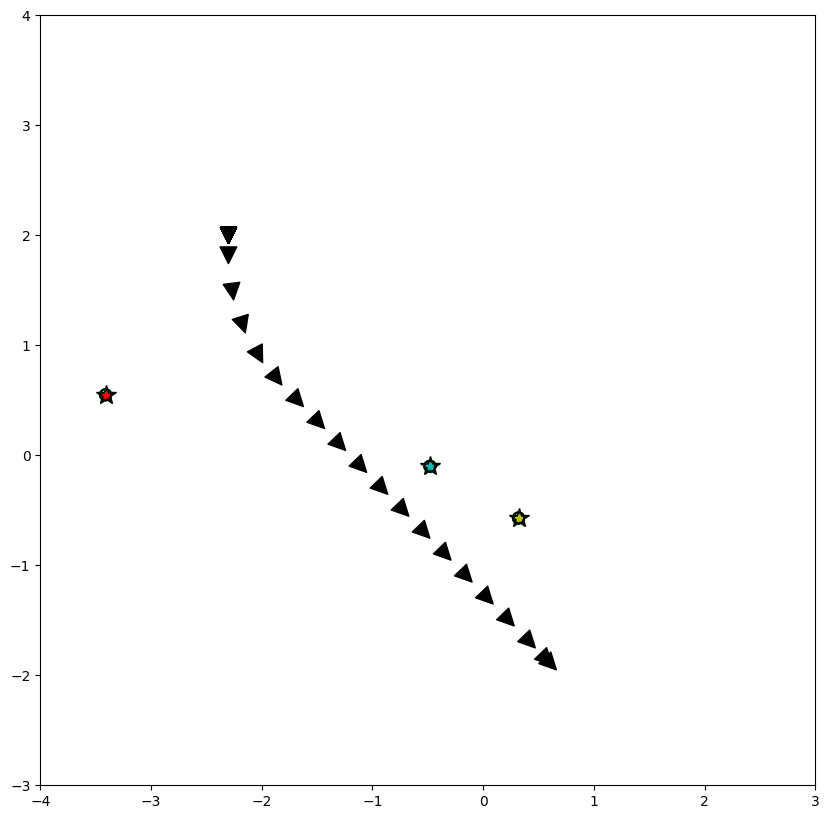

In [43]:
# Closed-loop MPC

# Dynamics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *

opti = casadi.Opti()

T = 20
H = 20
eps = 0
Delta = 1/8
L = 1


x_H10_1_cl = []
y_H10_1_cl = []
x_H10_2_cl = []
y_H10_2_cl = []
x_H10_3_cl = []
y_H10_3_cl = []

# If you run this code once, please comment the below for loop.
for i in range(T):
    x_H10_1_cl.append(original_x_1[0:T] + x_H10_1[i])
    y_H10_1_cl.append(original_y_1[0:T] + y_H10_1[i])
    x_H10_2_cl.append(original_x_2[0:T] + x_H10_2[i])
    y_H10_2_cl.append(original_y_2[0:T] + y_H10_2[i])
    x_H10_3_cl.append(original_x_3[0:T] + x_H10_3[i])
    y_H10_3_cl.append(original_y_3[0:T] + y_H10_3[i])

print(len(x_H10_1_cl))
print(len(x_H10_1_cl[0]))


print("d vals")
print(d_20_1)
print(d_20_2)
print(d_20_3)


xref = 0.9
yref = -2.2

x_state = [-2.3]*T
y_state = [2]*T
v_state = [0]*T
theta_state = [0]*T
uv_state = [0]*T
delta_state = [0]*T

x_current = -2.3
y_current = 2

x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)

uv = opti.variable(T)
delta = opti.variable(T)

opti.subject_to(x[0] == x_current)
opti.subject_to(y[0] == y_current)
opti.subject_to(V[0] == 0)
opti.subject_to(theta[0] == -pi/2)


opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 5)
opti.set_initial(theta[0], -pi/2)

p_opts = {"expand":True}
s_opts = {"max_iter": 5000}
opti.solver('ipopt', p_opts, s_opts)

# for t in range(T):
for t in range(T):
    print("Step: " + str(t))
    obj = 0
    opti.subject_to(opti.bounded(-pi/6, delta[0], pi/6))
    opti.subject_to(opti.bounded(-20, uv[0], 20))
    
    for i in range(1, T):
        opti.subject_to(opti.bounded(0, V[i], 100))
        opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
        opti.subject_to(opti.bounded(-20, uv[i], 20))

        opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
        opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
        opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
        opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
        
        # obj += uv[i-1]**2
        obj += V[i]**2

    opti.minimize(obj)
    
    for tau in range(H):
        opti.subject_to(sqrt((x[tau]-x_H10_1_cl[t][T+tau])**2+(y[tau]-y_H10_1_cl[t][T+tau])**2) >= d_20_1[t][tau]+eps)
        opti.subject_to(sqrt((x[tau]-x_H10_2_cl[t][T+tau])**2+(y[tau]-y_H10_2_cl[t][T+tau])**2) >= d_20_2[t][tau]+eps)
        opti.subject_to(sqrt((x[tau]-x_H10_3_cl[t][T+tau])**2+(y[tau]-y_H10_3_cl[t][T+tau])**2) >= d_20_3[t][tau]+eps)

    print("Obst 1 x,y,d")
    print(x_H10_1_cl[t])
    print(y_H10_1_cl[t])
    print(d_20_1[t])

    print("Obst 2 x,y,d")
    print(x_H10_2_cl[t])
    print(y_H10_2_cl[t])
    print(d_20_2[t])

    print("Obst 1 x,y,d")
    print(x_H10_3_cl[t])
    print(y_H10_3_cl[t])
    print(d_20_3[t])


    # for i in range(T):
    #     opti.subject_to(sqrt((x[i]-predict_x1[i+T])**2+(y[i]-predict_y1[i+T])**2) >= d20_value_H20_1[i]+eps)
    #     opti.subject_to(sqrt((x[i]-predict_x2[i+T])**2+(y[i]-predict_y2[i+T])**2) >= d20_value_H20_2[i]+eps)
    #     opti.subject_to(sqrt((x[i]-predict_x3[i+T])**2+(y[i]-predict_y3[i+T])**2) >= d20_value_H20_3[i]+eps)

    
    # opti.subject_to(x[T-t-1]-xref == 0)
    # opti.subject_to(y[T-t-1]-yref == 0)
    opti.subject_to((x[T-t-1]-xref)**2 + (y[T-t-1]-yref)**2 <= 0.4**2)
    # opti.subject_to(V[T-t-1] <= 1)

    sol = opti.solve()

    x_current = sol.value(x)[1]
    y_current = sol.value(y)[1]
    v_current = sol.value(V)[1]
    theta_current = sol.value(theta)[1]
    uv_current = sol.value(uv)[0]
    delta_current = sol.value(delta)[0]

    # if t == 0:
    print("Closed loop first iter soln:")
    print(sol.value(x))
    print(sol.value(y))
    print(sol.value(V))
    print(sol.value(theta))
    print(sol.value(uv))
    print(sol.value(delta))

    x_state.append(x_current)
    y_state.append(y_current)
    v_state.append(v_current)
    theta_state.append(theta_current)
    uv_state.append(uv_current)
    delta_state.append(delta_current)
    
    x = opti.variable(T)
    y = opti.variable(T)
    V = opti.variable(T)
    theta = opti.variable(T)

    uv = opti.variable(T)
    delta = opti.variable(T)
    
    opti.subject_to(x[0] == x_current)
    opti.subject_to(y[0] == y_current)
    opti.subject_to(V[0] == v_current)
    opti.subject_to(theta[0] == theta_current)


    opti.set_initial(x[0], x_current)
    opti.set_initial(y[0], y_current)
    opti.set_initial(V[0], v_current)
    opti.set_initial(theta[0], theta_current)
    
    

print("x_states: " + str(x_state))
print("y_states: " + str(y_state))
print("v_states: " + str(v_state))
print("theta_states: " + str(theta_state))
print("uv_states: " + str(uv_state))
print("delta_states: " + str(delta_state))

cost = 0
for i in range(T):
    cost += v_state[T+i]**2

print("Obj value: " + str(cost))

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-4, 3),
            ylim =(-3, 4))
ts = np.linspace(0,2*pi,100)

arrow = axis.annotate("", xy=(0, 0), xytext=(0, 0), arrowprops={"facecolor": "black"})

p1_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p2_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p3_line, = axis.plot([], [], '*', color = 'k', markersize = 15)

r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)

c1_line, = axis.plot([], [], '-', color = 'g')
c2_line, = axis.plot([], [], '-', color = 'g')
c3_line, = axis.plot([], [], '-', color = 'g')

af1_line, = axis.plot([], [], '*', color = 'r')
af2_line, = axis.plot([], [], '*', color = 'c')
af3_line, = axis.plot([], [], '*', color = 'y')

ch1_line, = axis.plot([], [], color = 'k')
ch2_line, = axis.plot([], [], color = 'k')
ch3_line, = axis.plot([], [], color = 'k')

x_robot, y_robot = [], []

x_pred1, y_pred1 = [], []
x_pred2, y_pred2 = [], []
x_pred3, y_pred3 = [], []

x1_circle, y1_circle = [], []
x2_circle, y2_circle = [], []
x3_circle, y3_circle = [], []

x_af1, y_af1 = [], []
x_af2, y_af2 = [], []
x_af3, y_af3 = [], []

def init(): 
    p1_line.set_data([], [])
    p2_line.set_data([], [])
    p3_line.set_data([], [])
    
    r_line.set_data([], [])
    
    c1_line.set_data([], [])
    c2_line.set_data([], [])
    c3_line.set_data([], [])
    
    af1_line.set_data([], [])
    af2_line.set_data([], [])
    af3_line.set_data([], [])
    
    ch1_line.set_data([], [])
    ch2_line.set_data([], [])
    ch3_line.set_data([], [])
    
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line,

def animate(i):
    global arrow
    if i <= T-1:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= T:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred1, y_pred1 = [], []
    x_pred2, y_pred2 = [], []
    x_pred3, y_pred3 = [], []
    if i >= T:
        x_p1 = x_H10_1_cl[i-T][T]
        y_p1 = y_H10_1_cl[i-T][T]
        x_p2 = x_H10_2_cl[i-T][T]
        y_p2 = y_H10_2_cl[i-T][T]
        x_p3 = x_H10_3_cl[i-T][T]
        y_p3 = y_H10_3_cl[i-T][T]        

        x_pred1.append(x_p1)
        y_pred1.append(y_p1)
        x_pred2.append(x_p2)
        y_pred2.append(y_p2)
        x_pred3.append(x_p3)
        y_pred3.append(y_p3)
        
        p1_line.set_data(x_pred1, y_pred1)
        p2_line.set_data(x_pred2, y_pred2)
        p3_line.set_data(x_pred3, y_pred3)
        
    elif i <= T-1:
        x_p1 = x_H10_1_cl[0][i]
        y_p1 = y_H10_1_cl[0][i]
        x_p2 = x_H10_2_cl[0][i]
        y_p2 = y_H10_2_cl[0][i]
        x_p3 = x_H10_3_cl[0][i]
        y_p3 = y_H10_3_cl[0][i]
        
        x_pred1.append(x_p1)
        y_pred1.append(y_p1)
        x_pred2.append(x_p2)
        y_pred2.append(y_p2)
        x_pred3.append(x_p3)
        y_pred3.append(y_p3)
        
        p1_line.set_data(x_pred1, y_pred1)
        p2_line.set_data(x_pred2, y_pred2)
        p3_line.set_data(x_pred3, y_pred3)
        
    x_af1, y_af1 = [], []
    x_af2, y_af2 = [], []
    x_af3, y_af3 = [], []
    if T+10 <= i <= T+T-1:
        for j in range(T+H-i):
            x_a1 = x_H10_1_cl[i-T][T+j]
            y_a1 = y_H10_1_cl[i-T][T+j]
            x_a2 = x_H10_2_cl[i-T][T+j]
            y_a2 = y_H10_2_cl[i-T][T+j]
            x_a3 = x_H10_3_cl[i-T][T+j]
            y_a3 = y_H10_3_cl[i-T][T+j]
            
            x_af1.append(x_a1)
            y_af1.append(y_a1)
            x_af2.append(x_a2)
            y_af2.append(y_a2)
            x_af3.append(x_a3)
            y_af3.append(y_a3)
            
            af1_line.set_data(x_af1, y_af1)
            af2_line.set_data(x_af2, y_af2)
            af3_line.set_data(x_af3, y_af3)
            
    if T <= i <= T+H-1:
        for j in range(H+T-i):
            x_a1 = x_H10_1_cl[i-T][T+j]
            y_a1 = y_H10_1_cl[i-T][T+j]
            x_a2 = x_H10_2_cl[i-T][T+j]
            y_a2 = y_H10_2_cl[i-T][T+j]
            x_a3 = x_H10_3_cl[i-T][T+j]
            y_a3 = y_H10_3_cl[i-T][T+j]
            
            x_af1.append(x_a1)
            y_af1.append(y_a1)
            x_af2.append(x_a2)
            y_af2.append(y_a2)
            x_af3.append(x_a3)
            y_af3.append(y_a3)
            
            af1_line.set_data(x_af1, y_af1)
            af2_line.set_data(x_af2, y_af2)
            af3_line.set_data(x_af3, y_af3)
            
    x1_circle, y1_circle = [], []
    x2_circle, y2_circle = [], []
    x3_circle, y3_circle = [], []
    if T+10 <= i <= T+T-1:
        for j in range(T+H-i):
            c_x1 = d_20_1[i-T][j] * np.cos(ts) + x_H10_1_cl[i-T][T+j]
            c_y1 = d_20_1[i-T][j] * np.sin(ts) + y_H10_1_cl[i-T][T+j]
            c_x2 = d_20_2[i-T][j] * np.cos(ts) + x_H10_2_cl[i-T][T+j]
            c_y2 = d_20_2[i-T][j] * np.sin(ts) + y_H10_2_cl[i-T][T+j]
            c_x3 = d_20_3[i-T][j] * np.cos(ts) + x_H10_3_cl[i-T][T+j]
            c_y3 = d_20_3[i-T][j] * np.sin(ts) + y_H10_3_cl[i-T][T+j]
            
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            x2_circle.append(c_x2)
            y2_circle.append(c_y2)
            x3_circle.append(c_x3)
            y3_circle.append(c_y3)
            
            c1_line.set_data(x1_circle, y1_circle)
            c2_line.set_data(x2_circle, y2_circle)
            c3_line.set_data(x3_circle, y3_circle)
            
    if T <= i <= T+H-1:
        for j in range(H+T-i):
            c_x1 = d_20_1[i-T][j] * np.cos(ts) + x_H10_1_cl[i-T][T+j]
            c_y1 = d_20_1[i-T][j] * np.sin(ts) + y_H10_1_cl[i-T][T+j]
            c_x2 = d_20_2[i-T][j] * np.cos(ts) + x_H10_2_cl[i-T][T+j]
            c_y2 = d_20_2[i-T][j] * np.sin(ts) + y_H10_2_cl[i-T][T+j]
            c_x3 = d_20_3[i-T][j] * np.cos(ts) + x_H10_3_cl[i-T][T+j]
            c_y3 = d_20_3[i-T][j] * np.sin(ts) + y_H10_3_cl[i-T][T+j]
            
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            x2_circle.append(c_x2)
            y2_circle.append(c_y2)
            x3_circle.append(c_x3)
            y3_circle.append(c_y3)
            
            c1_line.set_data(x1_circle, y1_circle)
            c2_line.set_data(x2_circle, y2_circle)
            c3_line.set_data(x3_circle, y3_circle)
            
    xh1_circle, yh1_circle = [], []
    xh2_circle, yh2_circle = [], []
    xh3_circle, yh3_circle = [], []
    if i >= T:
        ch_x1 = d_20_1[i-T][0] * np.cos(ts) + x_H10_1_cl[i-T][T]
        ch_y1 = d_20_1[i-T][0] * np.sin(ts) + y_H10_1_cl[i-T][T]
        ch_x2 = d_20_2[i-T][0] * np.cos(ts) + x_H10_2_cl[i-T][T]
        ch_y2 = d_20_2[i-T][0] * np.sin(ts) + y_H10_2_cl[i-T][T]
        ch_x3 = d_20_3[i-T][0] * np.cos(ts) + x_H10_3_cl[i-T][T]
        ch_y3 = d_20_3[i-T][0] * np.sin(ts) + y_H10_3_cl[i-T][T]
        
        xh1_circle.append(ch_x1)
        yh1_circle.append(ch_y1)
        xh2_circle.append(ch_x2)
        yh2_circle.append(ch_y2)
        xh3_circle.append(ch_x3)
        yh3_circle.append(ch_y3)
        
        ch1_line.set_data(xh1_circle, yh1_circle)
        ch2_line.set_data(xh2_circle, yh2_circle)
        ch3_line.set_data(xh3_circle, yh3_circle)
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line, arrow
    # return p3_line, r_line, c3_line, af3_line, ch3_line, arrow


# for i in range(T+20):
for i in range(T+20):
    
    # if i <= 5:
    #     plt.legend(['Current_Obstacle_1', 'Current_Obstacle_2', 'Current_Obstacle_3', 
    #                 'Robot', 'Safe_Area_1', 'Safe_Area_2', 'Safe_Area_3', 'Predicted_Obstacle_1', 
    #                 'Predicted_Obstacle_2', 'Predicted_Obstacle_3', 'Current_Safe_Area_1', 
    #                 'Current_Safe_Area_2', 'Current_Safe_Area_3'], fontsize = 10)

    #     plt.xlabel('Position x')
    #     plt.ylabel('Position y')
    #     plt.title("Closed-loop")
    # else:
    #     break

    animate(i)

    plt.savefig("/home/hardik/Desktop/Research/social-navigation/conformal_prediction/figures/closedLoop_maxNorm/fig_%02i.png" % i)



# plt.legend(['Current_Obstacle_1', 'Current_Obstacle_2', 'Current_Obstacle_3', 
#             'Robot', 'Safe_Area_1', 'Safe_Area_2', 'Safe_Area_3', 'Predicted_Obstacle_1', 
#             'Predicted_Obstacle_2', 'Predicted_Obstacle_3', 'Current_Safe_Area_1', 
#             'Current_Safe_Area_2', 'Current_Safe_Area_3'], fontsize = 10)

# plt.xlabel('Position x')
# plt.ylabel('Position y')
# plt.title("Closed-loop")

# anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
# gif_writer = ImageMagickWriter(fps=2)
# anim.save('closed_mpc_dynamic_three_ped.gif', writer=gif_writer)